# Connect Forest Management Model with Forest Carbon Budget Model

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import ws3.forest
import time
import gurobipy as grb
import pickle
import libcbm
import os
from util_opt import compile_events, cbm_report, compile_scenario_maxstock, plot_scenario_maxstock, run_cbm_emissionstock, run_scenario, plugin_c_curves, cbm_report_both, compare_ws3_cbm, compare_ws3_cbm_both, track_system_stock, track_system_emission, compile_scenario_minemission, plot_scenario_minemission, kpi_age, kpi_species, cmp_c_ss, cmp_c_se, results_scenarios, bootstrap_ogi, compare_kpi_age

In [2]:
base_year = 2020
horizon = 10
period_length = 10
max_age = 1000
n_steps = 100
tvy_name = 'totvol'
max_harvest = 1.0

In [3]:
# Define scenario options based on case study
scenario_options = {
    'redchris': ['no_cons','evenflow_cons', 'redchrs_AAC_90%', 'redchrs_AAC_80%', 'redchrs_AAC_70%', 'redchrs_AAC_60%', 'redchrs_AAC_50%', 'redchrs_AAC_40%', 'redchrs_AAC_30%', 'redchrs_AAC_20%', 'redchrs_AAC_10%' ],
    'goldenbear': ['no_cons', 'evenflow_cons', 'gldbr_AAC_90%', 'gldbr_AAC_80%', 'gldbr_AAC_70%', 'gldbr_AAC_60%', 'gldbr_AAC_50%', 'gldbr_AAC_40%', 'gldbr_AAC_30%', 'gldbr_AAC_20%', Start = time.time()
scenario_names = scenario_options.get(case_study, [])
for scenario_name in scenario_names:
    print(f"Running for {case_study}_{obj_mode}_{scenario_name}...")
    results_scenarios(fm, 
                      clt_percentage, 
                      credibility, 
                      budget_input, 
                      n_steps, 
                      max_harvest, 
                      scenario_name, 
                      displacement_effect, 
                      hwp_pool_effect_value, 
                      release_immediately_value, 
                      case_study, 
                      obj_mode,                   
                      pickle_output_base=False, 
                      pickle_output_alter=False)
print('It took', round((time.time() - Start) / 60, 1), "minutes to run all scenarios.")],
    'equitysilver': [ 'no_cons','evenflow_cons', 'eqtslvr_AAC_90%', 'eqtslvr_AAC_80%', 'eqtslvr_AAC_70%', 'eqtslvr_AAC_60%', 'eqtslvr_AAC_50%', 'eqtslvr_AAC_40%', 'eqtslvr_AAC_30%', 'eqtslvr_AAC_20%', 'eqtslvr_AAC_10%'],
    'test': ['no_cons', 'evenflow_cons', 'bau_redchrs']
}

# Function to handle case study selection and update scenario dropdown
def select_case_study(case_study):
    print(f"Selected case study: {case_study}")
    # Update the scenario dropdown based on the selected case study
    scenario_dropdown.options = scenario_options.get(case_study, [])
    scenario_dropdown.value = scenario_options[case_study][0]  # Set a default value

# Case study dropdown
case_study_dropdown = widgets.Dropdown(
    options=['redchris', 'goldenbear', 'equitysilver', 'test'],
    value='goldenbear',
    description='Case Study:'
)
case_study_dropdown.observe(lambda change: select_case_study(change['new']), names='value')
display(case_study_dropdown)

# Function to handle scenario selection
def select_scenario(scenario_name):
    print(f"Selected scenario: {scenario_name}")

# Scenario dropdown
scenario_dropdown = widgets.Dropdown(
    options=scenario_options['redchris'],  # Set initial options based on default case study
    value=scenario_options['redchris'][1],  # Set initial value
    description='Scenario:'
)
scenario_dropdown.observe(lambda change: select_scenario(change['new']), names='value')
display(scenario_dropdown)

# Function to handle objective functon
def select_obj(obj_mode):
    print(f"Selected objective: {obj_mode}")
obj_dropdown = widgets.Dropdown(
    options=['max_hv', 'min_ha', 'max_st', 'min_em'],
    value='max_st',
    description='Objective:'
)
display(obj_dropdown)
obj_dropdown.observe(lambda change: select_obj(change['new']), names='value')

Dropdown(description='Case Study:', index=1, options=('redchris', 'goldenbear', 'equitysilver', 'test'), value…

Dropdown(description='Scenario:', index=1, options=('no_cons', 'evenflow_cons', 'redchrs_AAC_90%', 'redchrs_AA…

Dropdown(description='Objective:', index=2, options=('max_hv', 'min_ha', 'max_st', 'min_em'), value='max_st')

In [4]:
# Initialize main widget components 
hwp_pool_effect = widgets.FloatSlider(min=0, max=1, step=1, description='HWP_effect', value=1, layout=widgets.Layout(margin='10px 0'))
release_immediately = widgets.FloatSlider(min=0, max=1, step=1, description='Release immediately', value=1, layout=widgets.Layout(margin='10px 0'))
displacement_effect = widgets.FloatSlider(min=0, max=1, step=1, description='Displacement', value=1, layout=widgets.Layout(margin='10px 0'))
clt_percentage = widgets.FloatSlider(min=0, max=1, step=0.1, description='CLT_percent:', value=0.5, layout=widgets.Layout(margin='10px 0'))
credibility = widgets.FloatSlider(min=0, max=1, step=0.1, description='Credibility:', value=1, layout=widgets.Layout(margin='10px 0'))
# max_harvest = widgets.FloatSlider(min=0, max=1, step=0.05, description='Max_harvest:', value=1.0, layout=widgets.Layout(margin='10px 0'))
budget_input = widgets.FloatText(value=10000000, description='Budget:', layout=widgets.Layout(margin='10px 0'))

release_immediately.layout.display = 'none' if hwp_pool_effect.value != 0 else 'block'
displacement_effect.layout.display = 'block' if hwp_pool_effect.value != 0 else 'none'
clt_percentage.layout.display = 'block' if hwp_pool_effect.value != 0 and displacement_effect.value != 0 else 'none'
credibility.layout.display = 'block' if hwp_pool_effect.value != 0 and displacement_effect.value != 0 else 'none'

container = widgets.VBox([
    hwp_pool_effect, release_immediately, displacement_effect, clt_percentage, credibility, budget_input  
    # ,max_harvest
])

display(container)

def update_widgets(change):
    hwp_pool_effect_value = hwp_pool_effect.value
    displacement_effect_value = displacement_effect.value

    release_immediately.layout.display = 'block' if hwp_pool_effect_value == 0 else 'none'
    displacement_effect.layout.display = 'block' if hwp_pool_effect_value != 0 else 'none'

    clt_percentage.layout.display = 'block' if hwp_pool_effect_value != 0 and displacement_effect_value != 0 else 'none'
    credibility.layout.display = 'block' if hwp_pool_effect_value != 0 and displacement_effect_value != 0 else 'none'

hwp_pool_effect.observe(update_widgets, names='value')
displacement_effect.observe(update_widgets, names='value')

In [5]:
#Start Calculating the Running Time
Start = time.time()

In [6]:
case_study = case_study_dropdown.value
scenario_name = scenario_dropdown.value
obj_mode = obj_dropdown.value
hwp_pool_effect_value = hwp_pool_effect.value
release_immediately_value = release_immediately.value if hwp_pool_effect_value == 0 else 0
displacement_effect = displacement_effect.value if hwp_pool_effect_value != 0 else 0
clt_percentage = clt_percentage.value if displacement_effect != 0 else 0
credibility = credibility.value if displacement_effect != 0 else 0
# max_harvest = max_harvest.value
budget_input = budget_input.value

In [7]:
# Define case study mappings and retrieve model details based on case study
case_study_options = {
    'redchris': {
        'model_name': 'redchris',
        'model_path': './data/woodstock_model_files_redchris'
    },
    'goldenbear': {
        'model_name': 'goldenbear',
        'model_path': './data/woodstock_model_files_goldenbear'
    },
    'equitysilver': {
        'model_name': 'equitysilver',
        'model_path': './data/woodstock_model_files_equitysilver'
    },
    'test': {
        'model_name': 'redchris',
        'model_path': './data/woodstock_model_files_redchris_test'
    }
}

model_info = case_study_options.get(case_study)

if model_info:
    model_name = model_info['model_name']
    model_path = model_info['model_path']
else:
    print('The case study name is not valid')


In [8]:
# Create and Run `ForestModel` instance
fm = ws3.forest.ForestModel(model_name=model_name,
                            model_path=model_path,
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)
fm.import_landscape_section()
fm.import_areas_section()
fm.import_yields_section()
fm.import_actions_section()
fm.import_transitions_section()
fm.initialize_areas()
fm.add_null_action()
fm.reset_actions()
fm.grow()

In [9]:
# Flag 'harvest' as a harvesting action in the ws3 model
harvest_acode='harvest'
fm.actions[harvest_acode].is_harvest = True

In [10]:
# Read curves
file_directory = "./inputs/curves"
file_names = [f"{case_study}_c_curves_p.pkl", f"{case_study}_c_curves_f.pkl"]
loaded_data = {}

for filename in file_names:
    file_path = os.path.join(file_directory, filename)
    with open(file_path, 'rb') as file:
        loaded_data[filename] = pickle.load(file)
    print(f"Loaded data from {file_path}")

c_curves_p = loaded_data.get(f"{case_study}_c_curves_p.pkl")
c_curves_f = loaded_data.get(f"{case_study}_c_curves_f.pkl")

Loaded data from ./inputs/curves/goldenbear_c_curves_p.pkl
Loaded data from ./inputs/curves/goldenbear_c_curves_f.pkl


In [11]:
# Plug carbon and old groth yield curves into forest model
plugin_c_curves(fm, c_curves_p, c_curves_f)
bootstrap_ogi(fm)

found match for mask ('?', '?', '?', '?', '12', '12')
found match for mask ('?', '?', '?', '?', '30', '30')
found match for mask ('?', '?', '?', '?', '10', '10')
found match for mask ('?', '?', '?', '?', '12', '12')
found match for mask ('?', '?', '?', '?', '28', '28')
found match for mask ('?', '?', '?', '?', '30', '30')
found match for mask ('?', '?', '?', '?', '10', '10')
found match for mask ('?', '?', '?', '?', '11', '11')
found match for mask ('?', '?', '?', '?', '12', '12')
found match for mask ('?', '?', '?', '?', '28', '28')
found match for mask ('?', '?', '?', '?', '29', '29')
found match for mask ('?', '?', '?', '?', '30', '30')
found match for mask ('?', '?', '?', '?', '37', '37')
found match for mask ('?', '?', '?', '?', '38', '38')
found match for mask ('?', '?', '?', '?', '39', '39')
found match for mask ('?', '?', '?', '?', '25', '25')
found match for mask ('?', '?', '?', '?', '27', '27')
found match for mask ('?', '?', '?', '?', '7', '7')
found match for mask ('?', '?'

Running for goldenbear_max_st_no_cons...
running no_cons scenario
Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-09
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3905 rows, 36130 columns and 36130 nonzeros
Model fingerprint: 0x1069e219
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+01, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 3905 rows and 36130 columns
Presolve time: 0.54s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.9721627e+07   0.000000e+00   0.000000e+00      1s

Solved in 0 iterations and 0.83 seconds (0.01 work units)
Optimal objective  3.972162737e+07


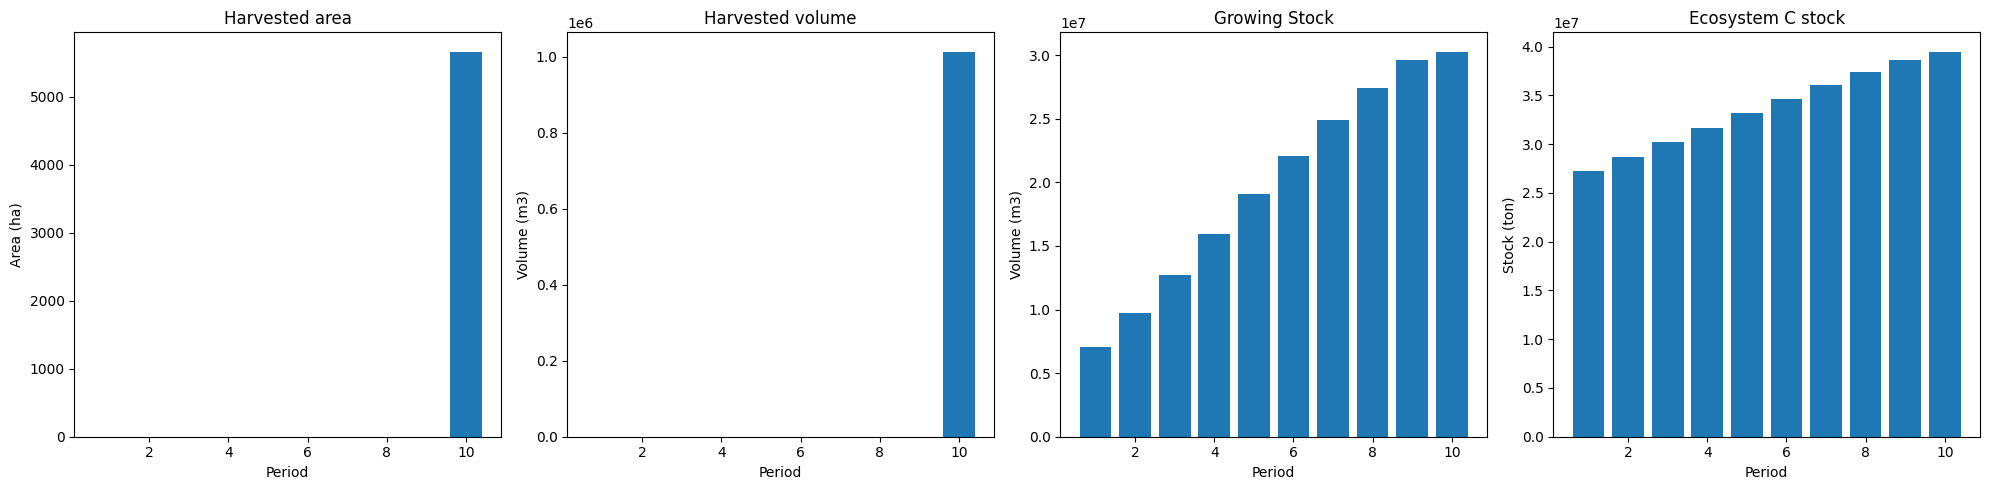

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_no_cons_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  1072
The economic indicator (the provincial government revenues) is:  36566
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


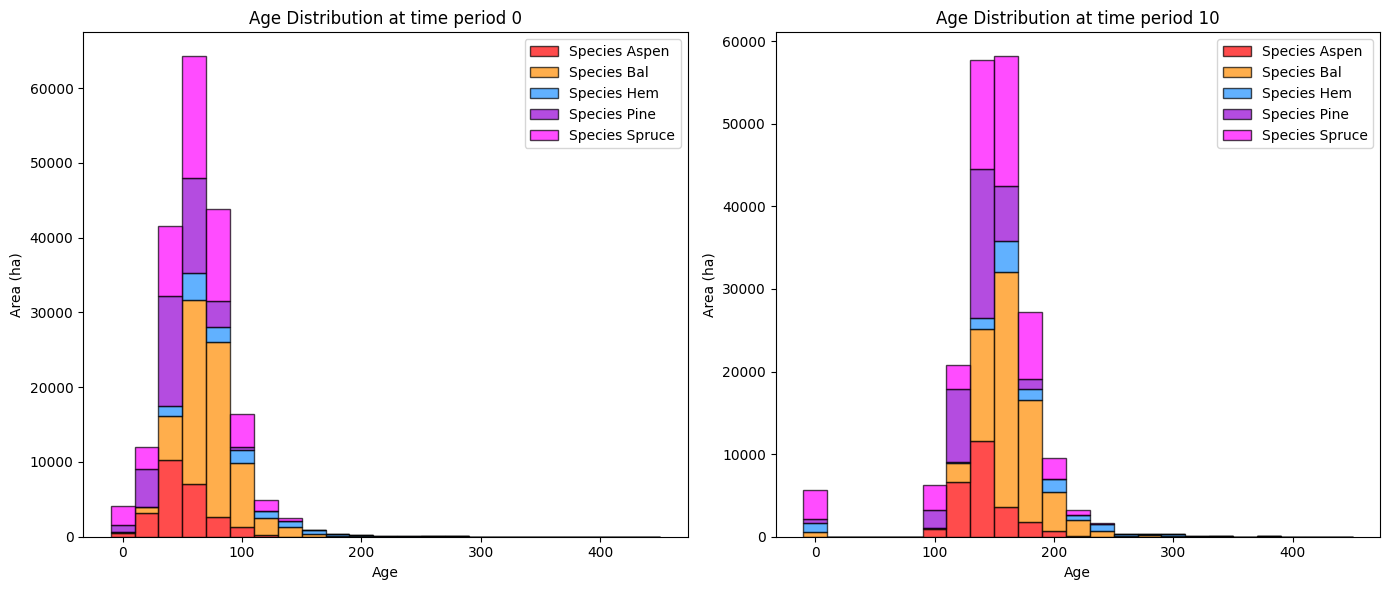

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_no_cons_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   7970.151398   7967.442865
Bal     278.565372  15963.007735  15684.442363
Aspen   273.490478  13191.618272  12918.127794
Pine      0.000000   7631.887200   7631.887200
Hem     419.699331   3929.593538   3509.894208

Old growth has **increased** by 47711.79 hectares from time period 0 to time period 10.


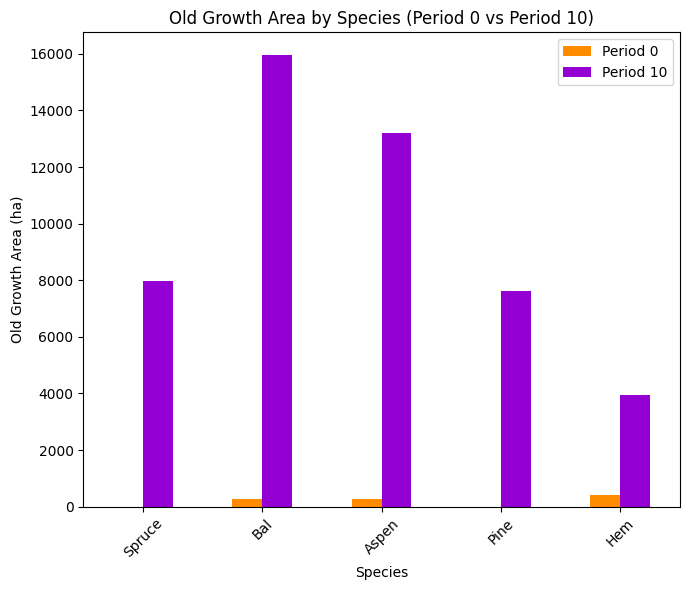

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_no_cons_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.9455
Shannon Evenness Index for time period 10: 0.9252

Diversity has **decreased** by 2.04% from time 0 to time 10.


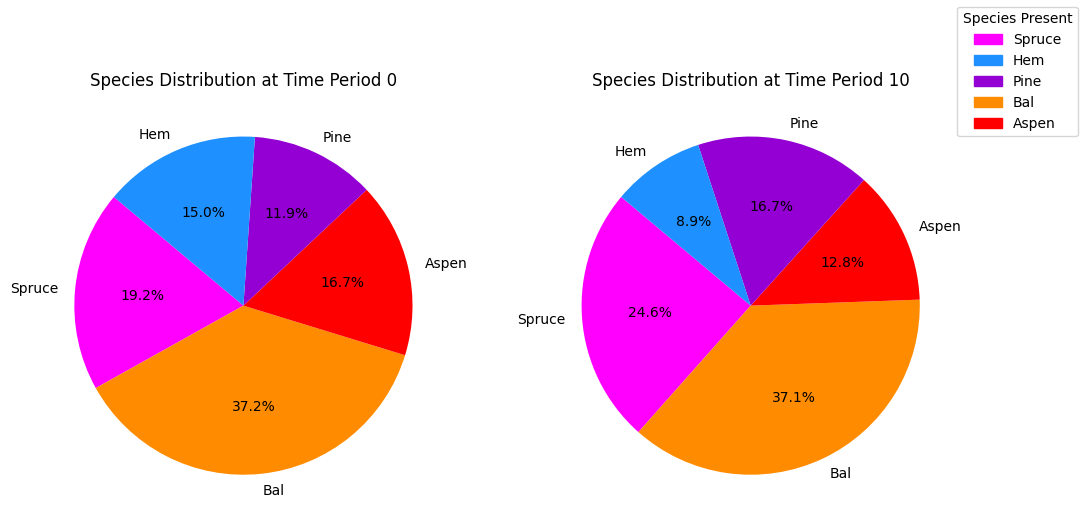

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_st_no_cons_species_pie.pdf
running business as usual scenario for the Golden Bear mine site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0xf8fbe06d
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e+01, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 2031 columns
Presolve time: 0.12s
Presolved: 1911 rows, 34099 columns, 409165 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00

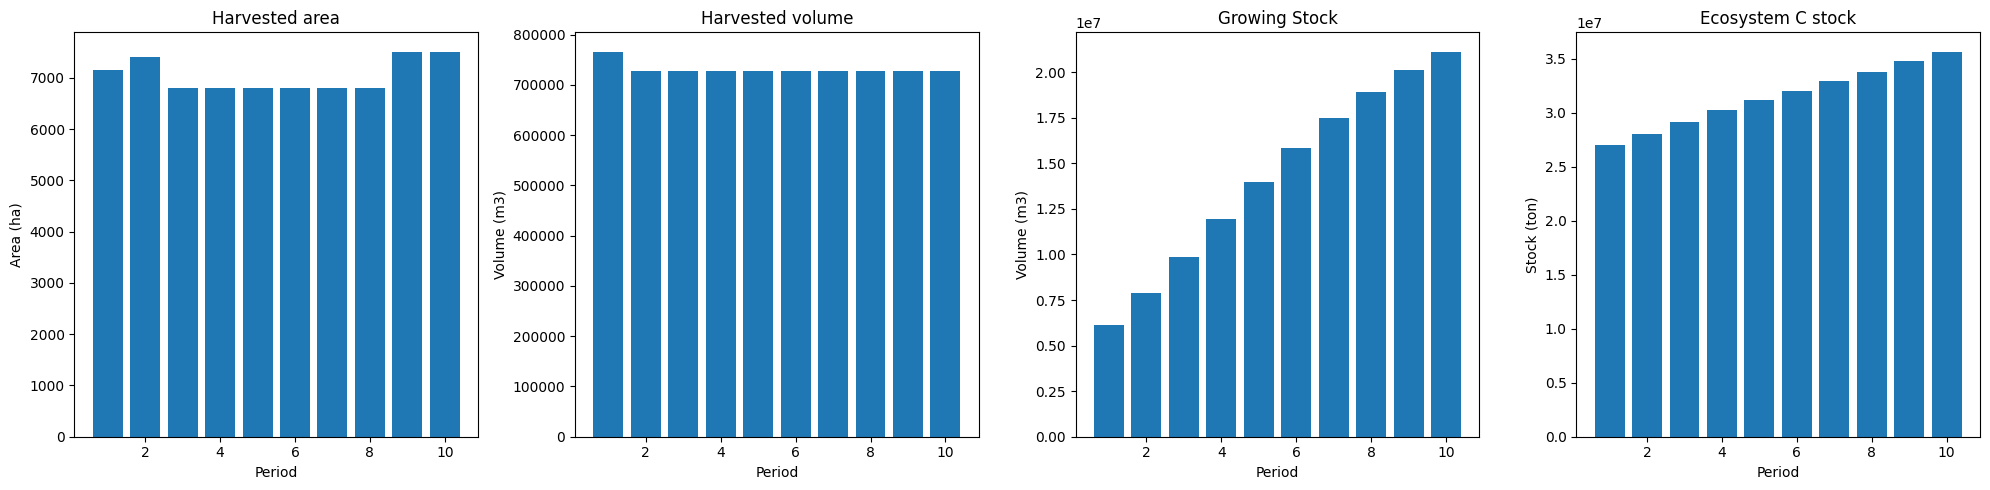

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_bau_gldbr_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  7734
The economic indicator (the provincial government revenues) is:  263762
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


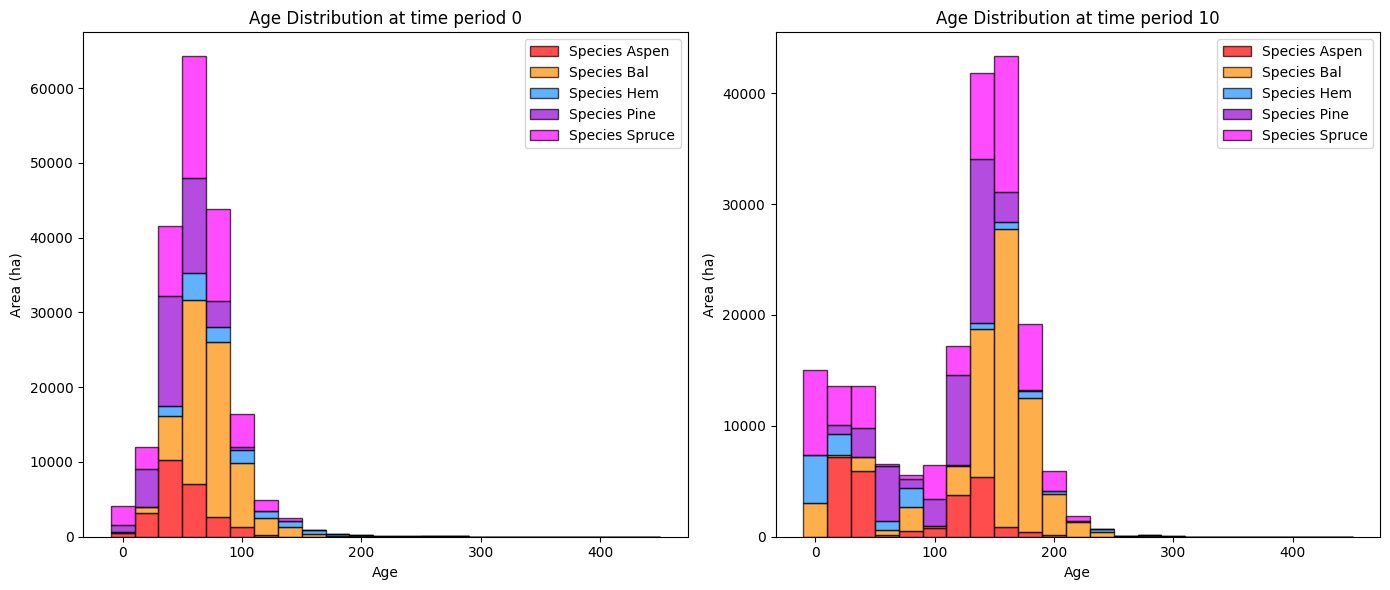

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_bau_gldbr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   4738.556382   4735.847848
Bal     278.565372  11823.627962  11545.062590
Aspen   273.490478   3610.557489   3337.067011
Pine      0.000000   3707.791886   3707.791886
Hem     419.699331    830.482584    410.783253

Old growth has **increased** by 23736.55 hectares from time period 0 to time period 10.


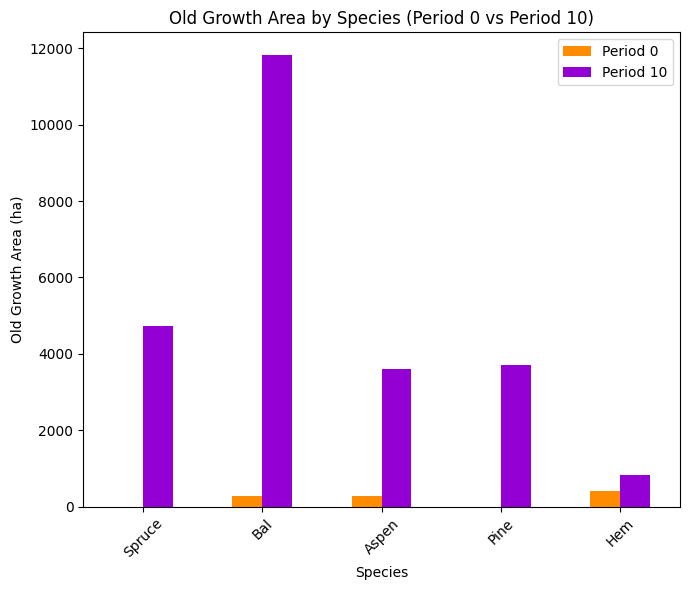

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_bau_gldbr_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.9455
Shannon Evenness Index for time period 10: 0.8181

Diversity has **decreased** by 12.74% from time 0 to time 10.


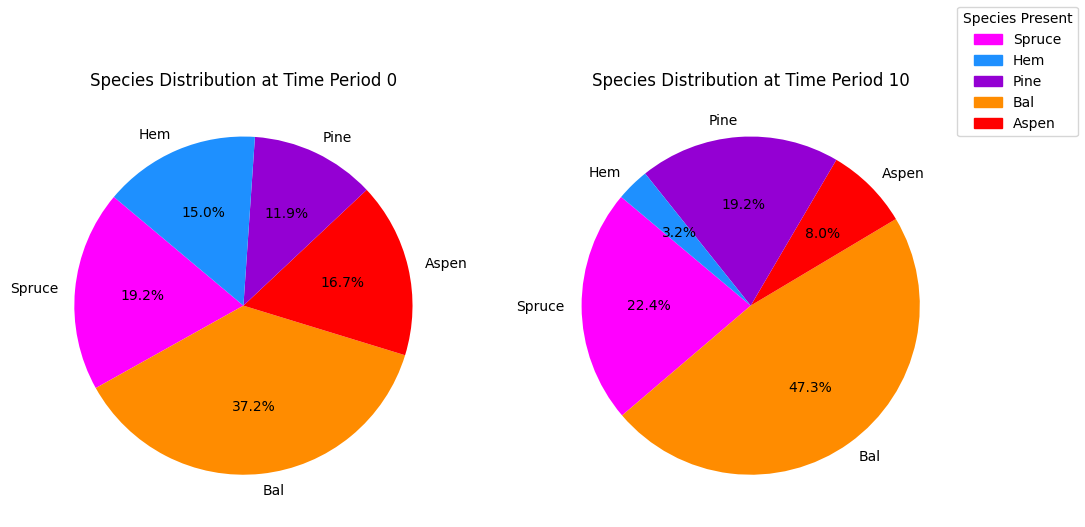

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_st_bau_gldbr_species_pie.pdf


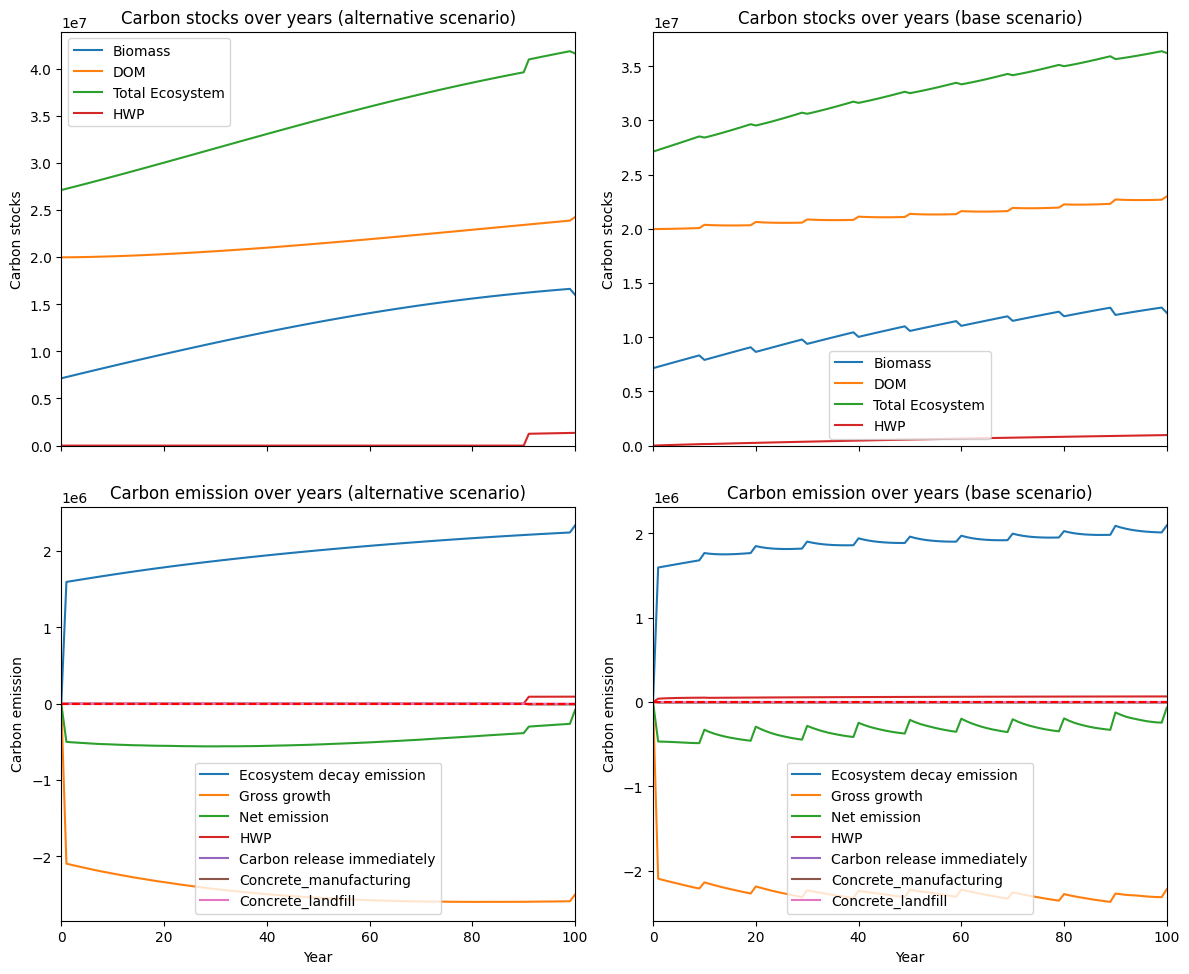

---------------------------------------------------------------------------------------
Net emission difference -15735588.782631934
Net emission base scenario -32702620.346034106
Net emission alternative scenario -48438209.12866604
dollar_per_ton is:  0.6355021180419663
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Spruce  0.0  3231.595017  3231.595017
Bal     0.0  4139.379773  4139.379773
Aspen   0.0  9581.060783  9581.060783
Pine    0.0  3924.095315  3924.095315
Hem     0.0  3099.110954  3099.110954

Overall, the old growth area has **increased** by 23975.24 hectares in the alternative scenario compared to the base scenario.


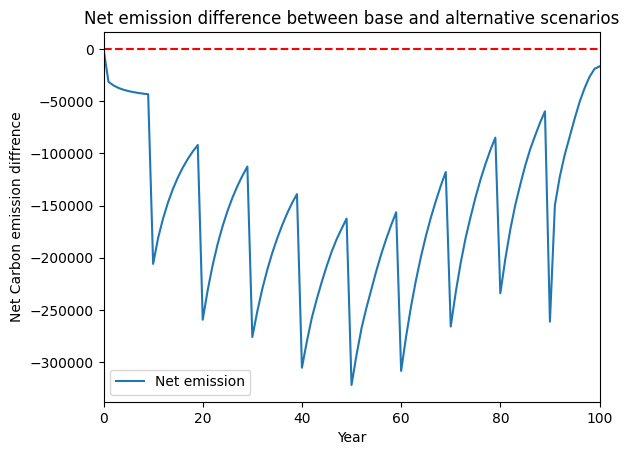

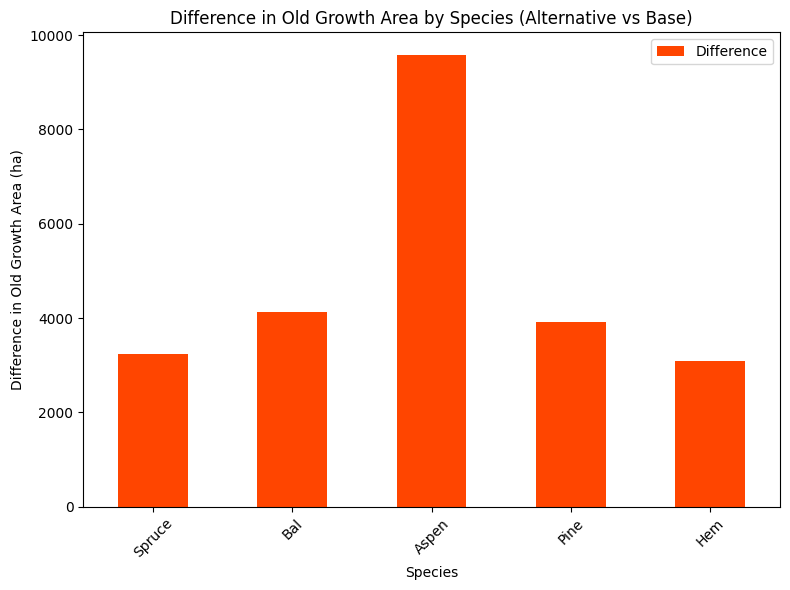

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_kpi_age_difference.pdf


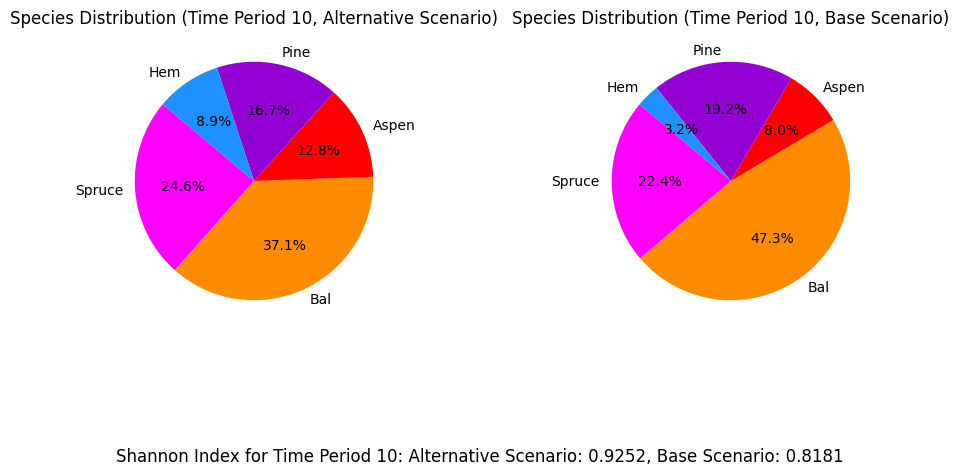

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_st_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for goldenbear_max_st_evenflow_cons...
running even flow constraints scenario
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3945 rows, 36130 columns and 430076 nonzeros
Model fingerprint: 0xd66dd655
Coefficient statistics:
  Matrix range     [1e-02, 9e+04]
  Objective range  [2e+01, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 2035 rows and 2031 columns
Presolve time: 0.12s
Presolved: 1910 rows, 34099 columns, 402875 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering ti

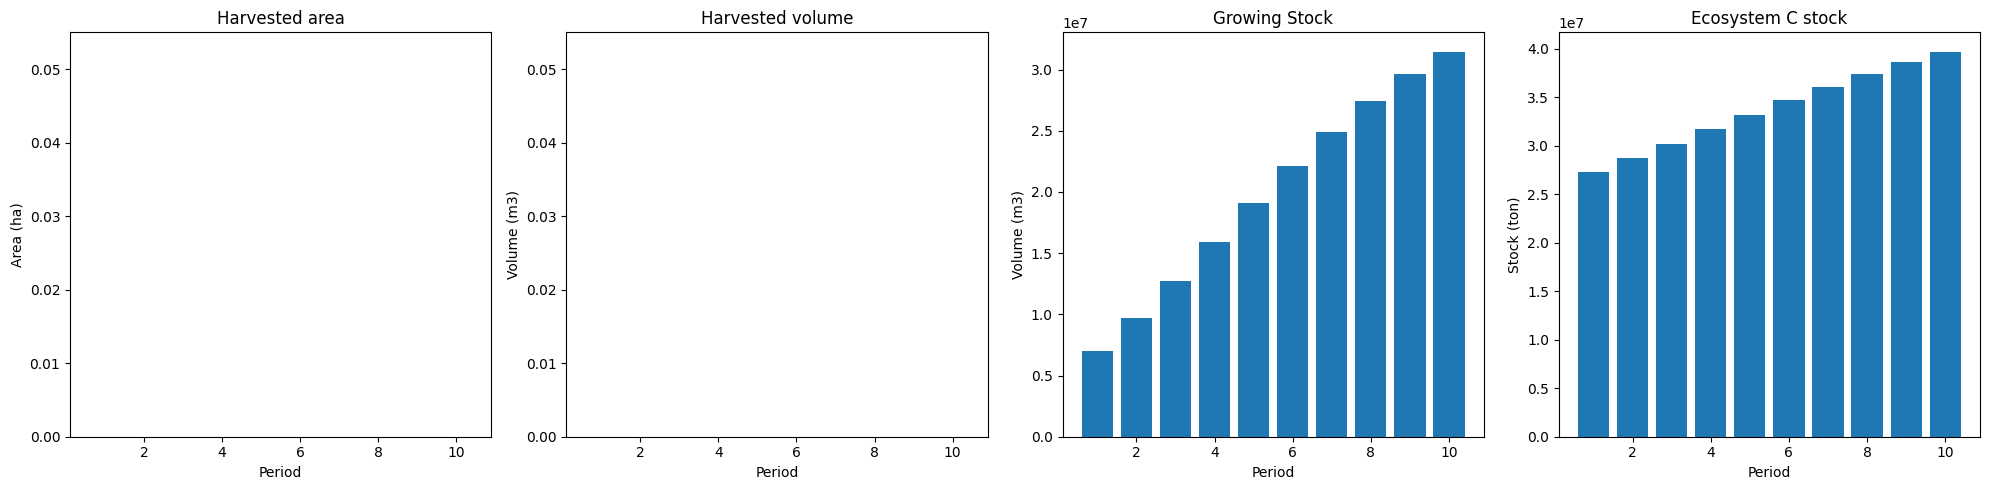

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_evenflow_cons_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  0
The economic indicator (the provincial government revenues) is:  0
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


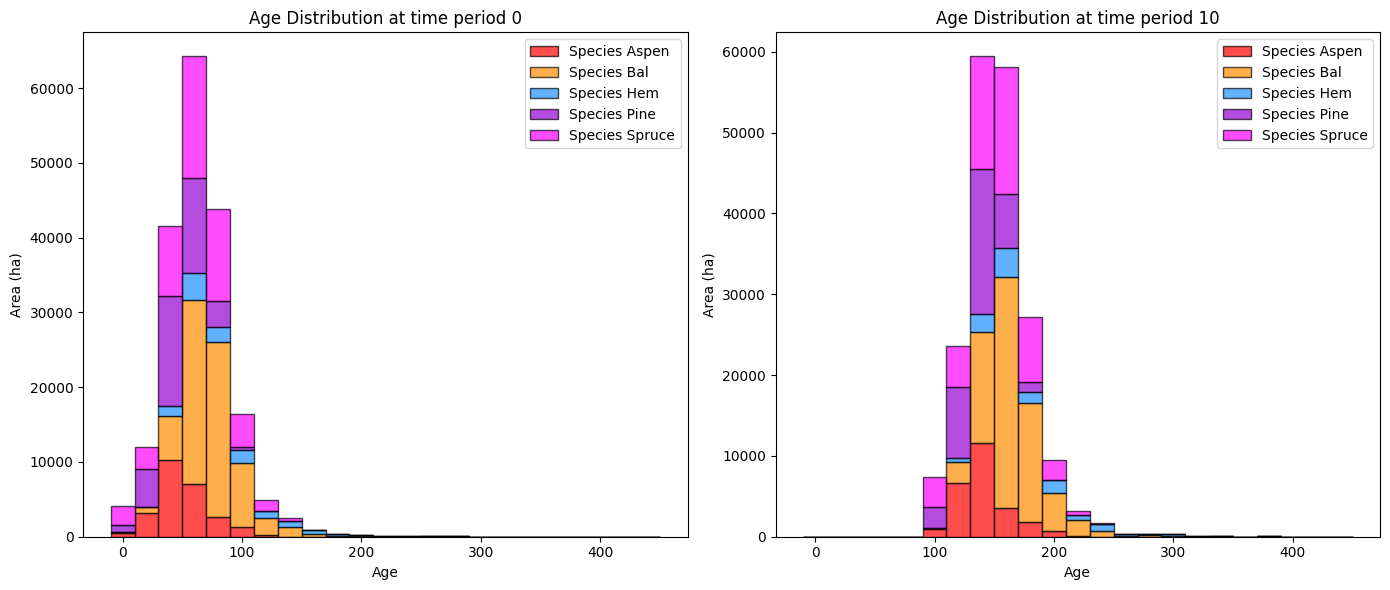

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_evenflow_cons_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   8040.264040   8037.555506
Bal     278.565372  15963.007735  15684.442363
Aspen   273.490478  13191.618272  12918.127794
Pine      0.000000   7631.887200   7631.887200
Hem     419.699331   3929.593538   3509.894208

Old growth has **increased** by 47781.91 hectares from time period 0 to time period 10.


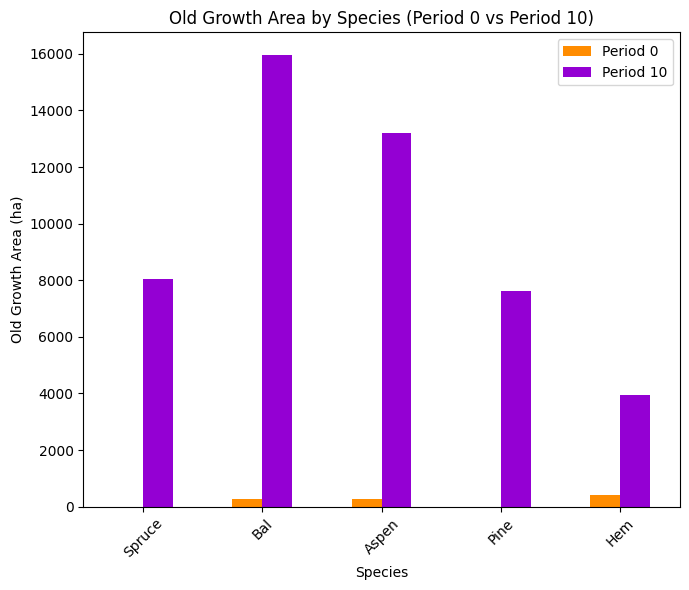

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_evenflow_cons_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.9455
Shannon Evenness Index for time period 10: 0.9285

Diversity has **decreased** by 1.71% from time 0 to time 10.


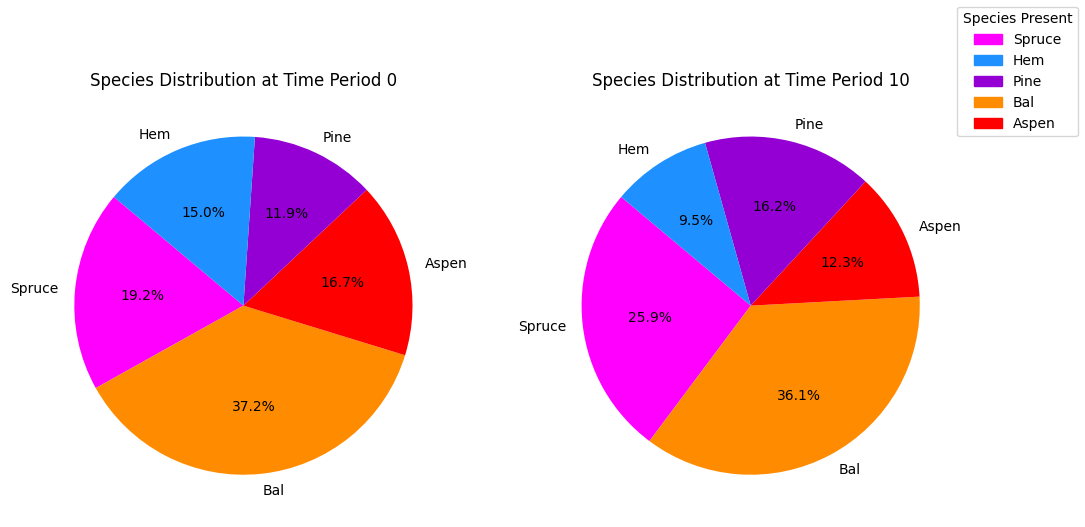

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_st_evenflow_cons_species_pie.pdf
running business as usual scenario for the Golden Bear mine site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0xf8fbe06d
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e+01, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 2031 columns
Presolve time: 0.13s
Presolved: 1911 rows, 34099 columns, 409165 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time

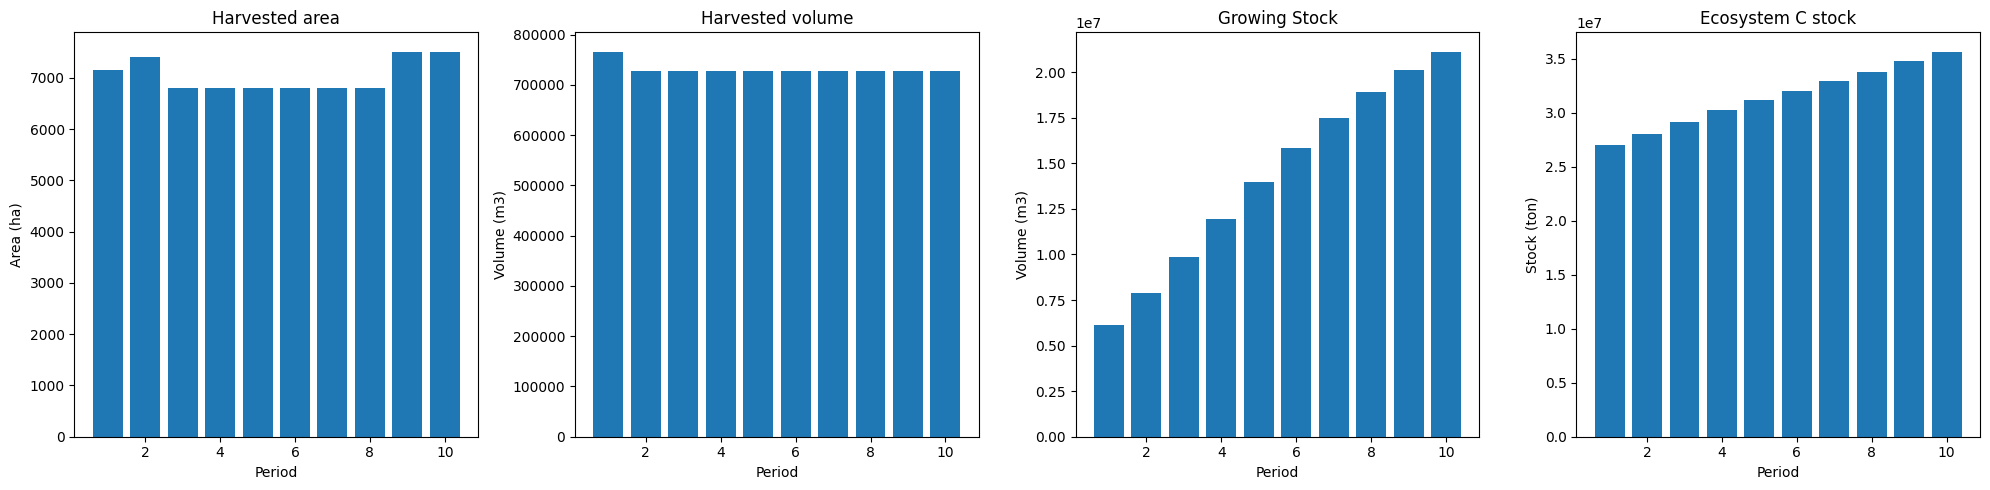

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_bau_gldbr_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  7734
The economic indicator (the provincial government revenues) is:  263762
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


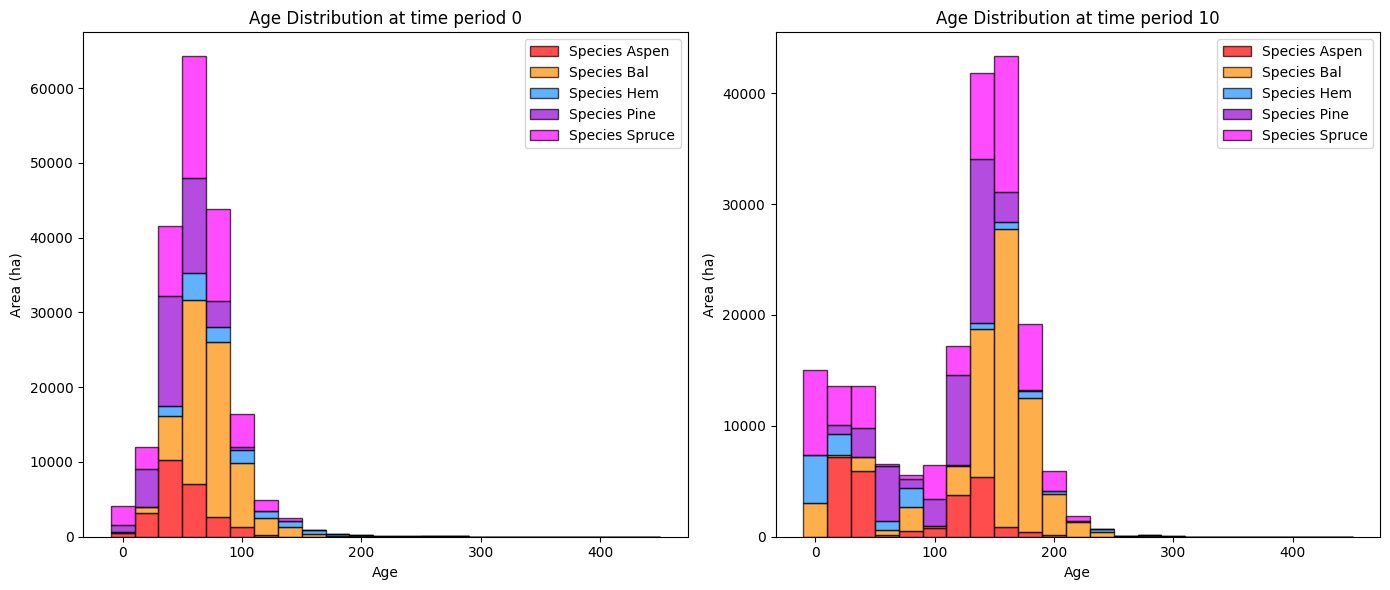

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_bau_gldbr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   4738.556382   4735.847848
Bal     278.565372  11823.627962  11545.062590
Aspen   273.490478   3610.557489   3337.067011
Pine      0.000000   3707.791886   3707.791886
Hem     419.699331    830.482584    410.783253

Old growth has **increased** by 23736.55 hectares from time period 0 to time period 10.


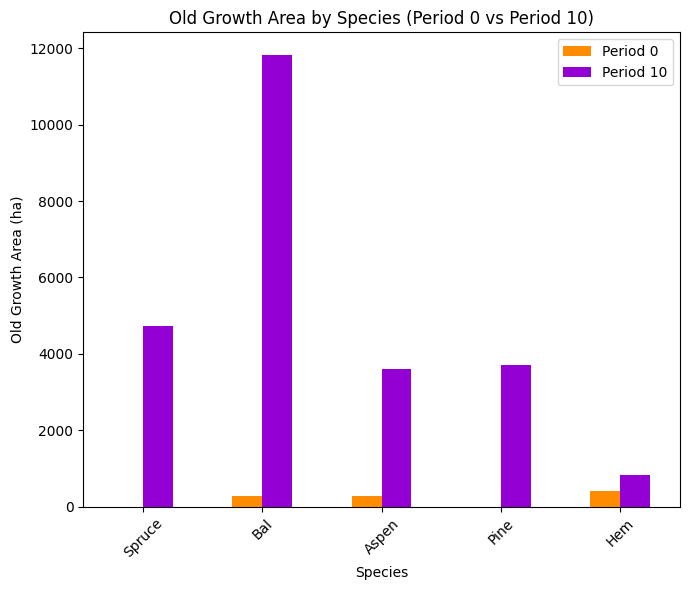

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_bau_gldbr_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.9455
Shannon Evenness Index for time period 10: 0.8181

Diversity has **decreased** by 12.74% from time 0 to time 10.


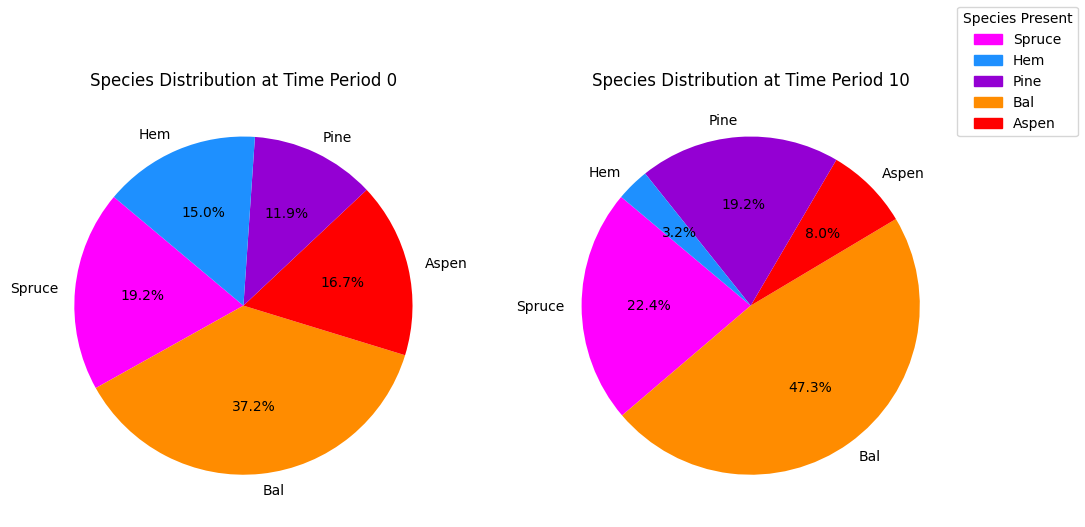

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_st_bau_gldbr_species_pie.pdf


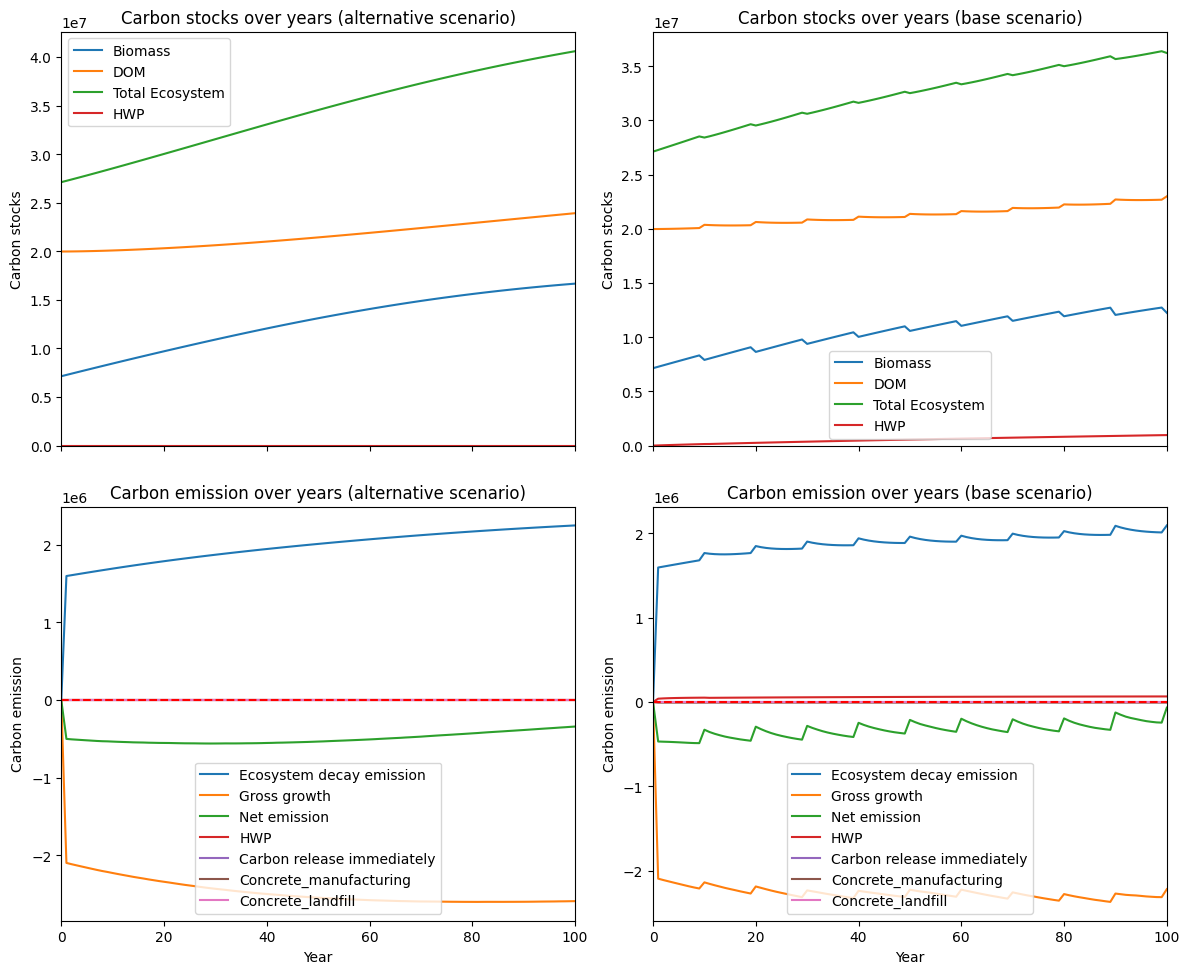

---------------------------------------------------------------------------------------
Net emission difference -16724701.341645956
Net emission base scenario -32702620.346034106
Net emission alternative scenario -49427321.687680066
dollar_per_ton is:  0.5979180013875126
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Spruce  0.0  3301.707658  3301.707658
Bal     0.0  4139.379773  4139.379773
Aspen   0.0  9581.060783  9581.060783
Pine    0.0  3924.095315  3924.095315
Hem     0.0  3099.110954  3099.110954

Overall, the old growth area has **increased** by 24045.35 hectares in the alternative scenario compared to the base scenario.


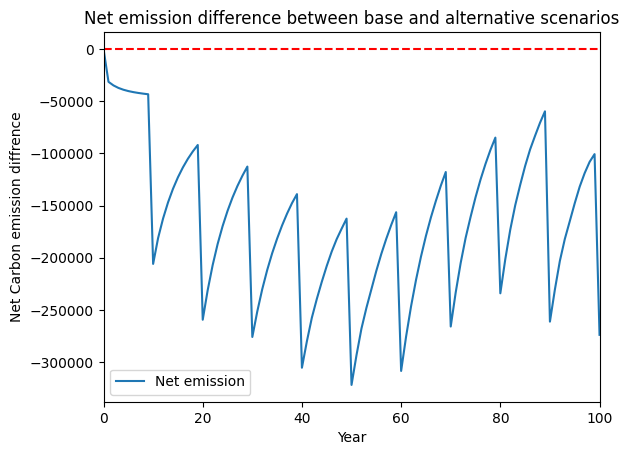

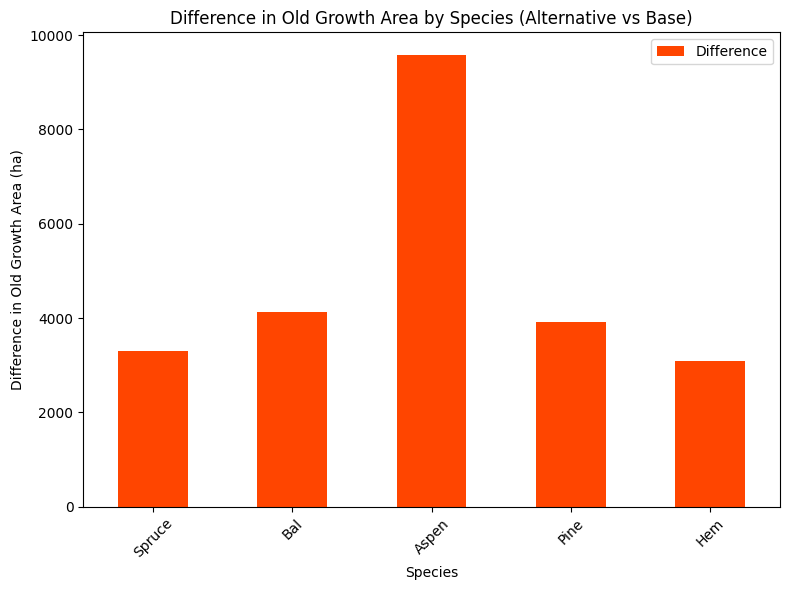

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_kpi_age_difference.pdf


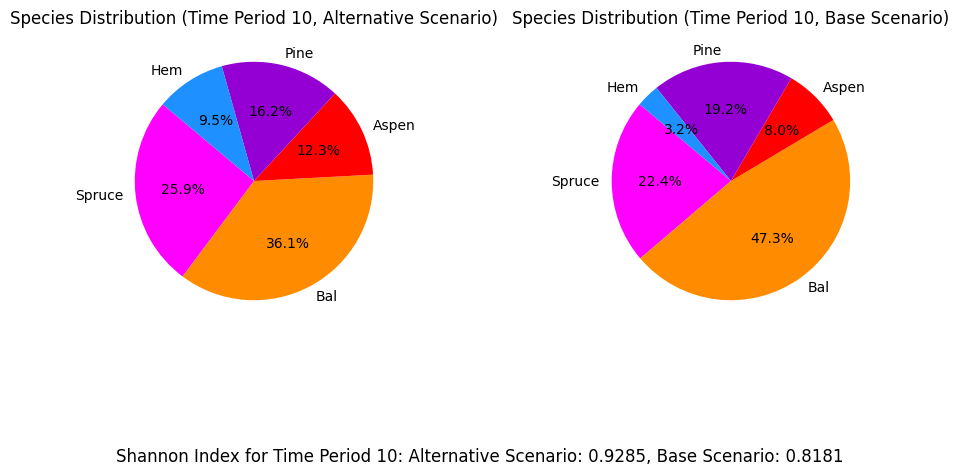

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_st_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for goldenbear_max_st_gldbr_AAC_90%...
running the scenario for the Golden Bear mining site (90%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0x53d6cc0b
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e+01, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 2031 columns
Presolve time: 0.14s
Presolved: 1911 rows, 34100 

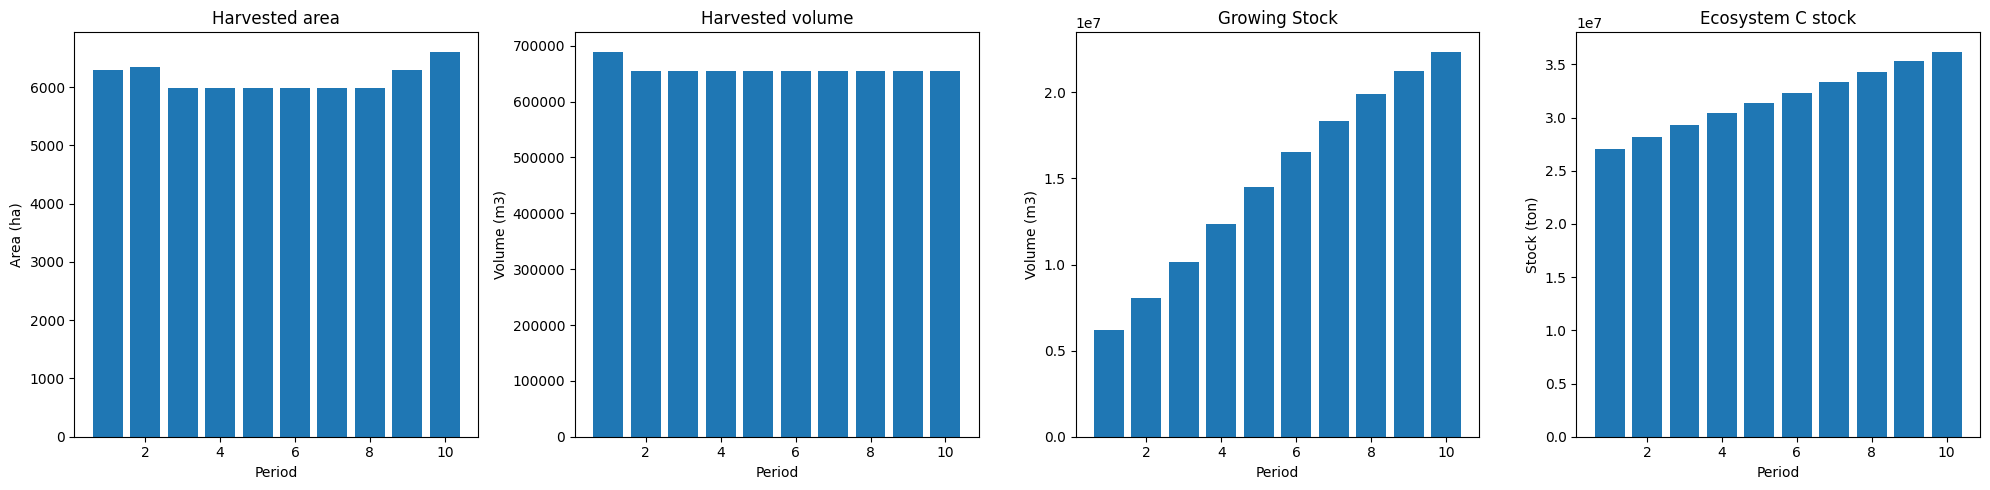

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_gldbr_AAC_90%_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  6961
The economic indicator (the provincial government revenues) is:  237385
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


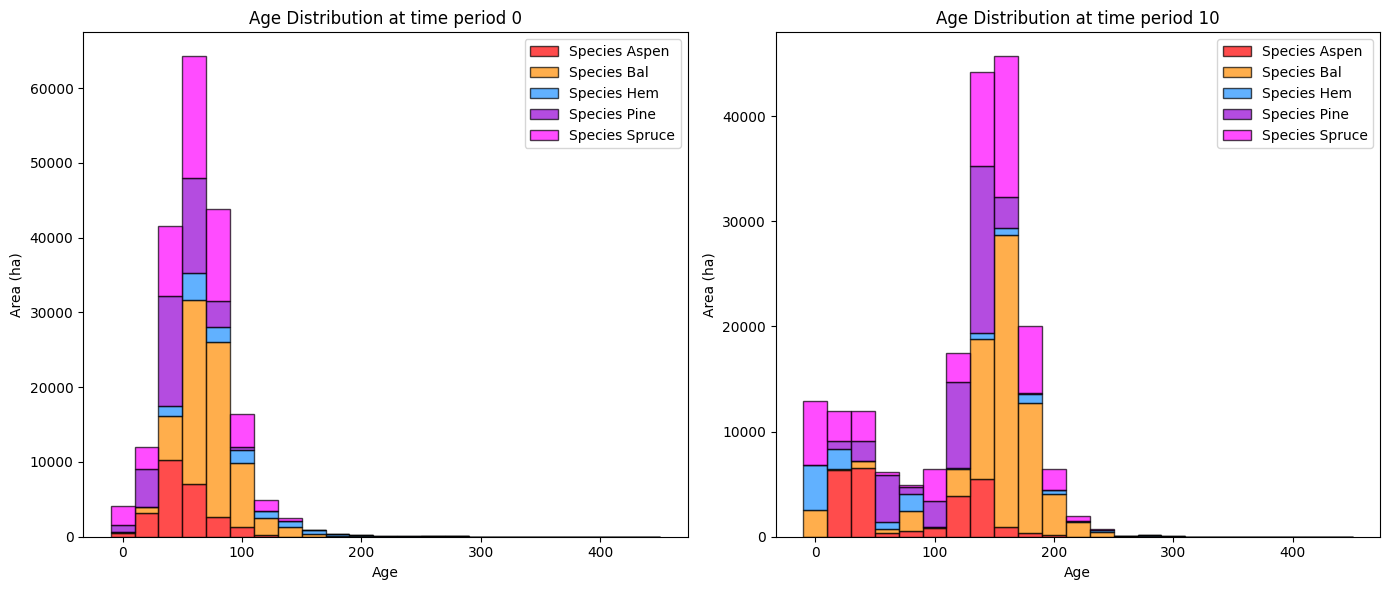

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_gldbr_AAC_90%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   5195.928963   5193.220430
Bal     278.565372  12407.449486  12128.884114
Aspen   273.490478   3645.730010   3372.239532
Pine      0.000000   4083.985649   4083.985649
Hem     419.699331    937.428575    517.729244

Old growth has **increased** by 25296.06 hectares from time period 0 to time period 10.


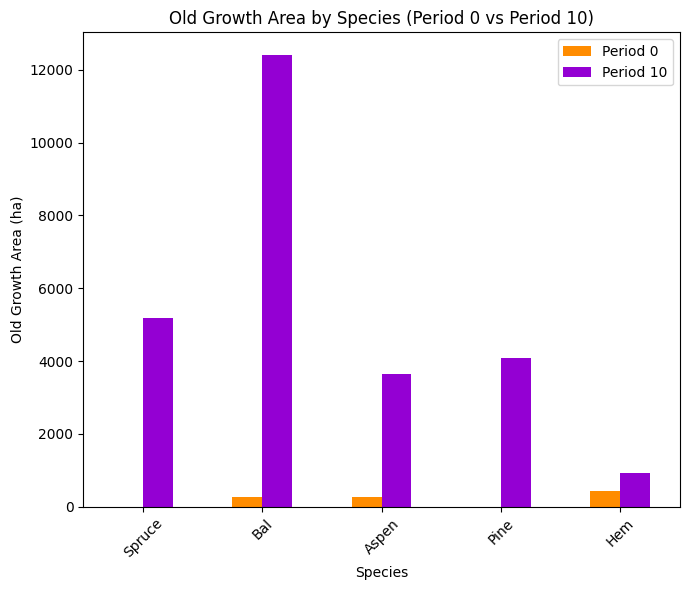

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_gldbr_AAC_90%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.9455
Shannon Evenness Index for time period 10: 0.8223

Diversity has **decreased** by 12.33% from time 0 to time 10.


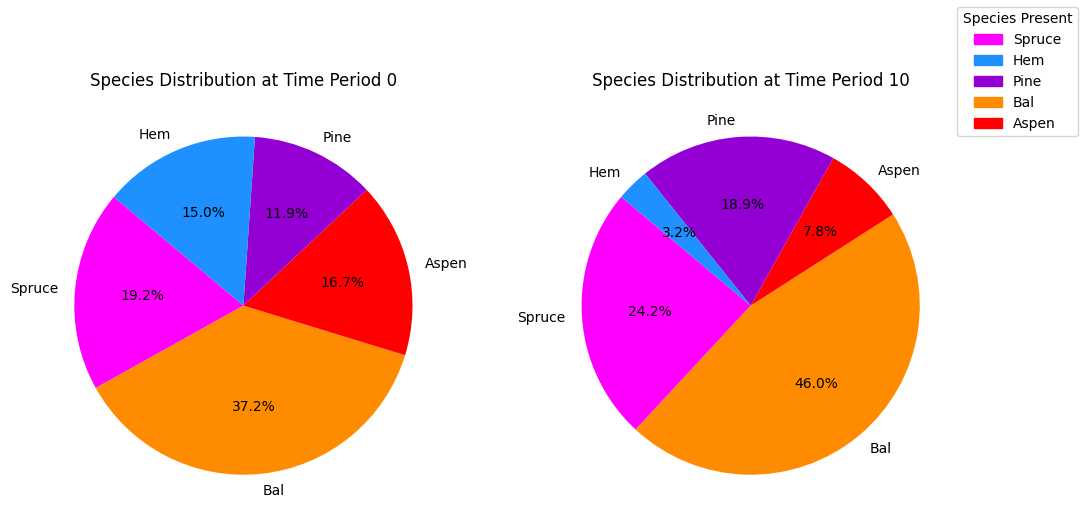

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_st_gldbr_AAC_90%_species_pie.pdf
running business as usual scenario for the Golden Bear mine site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0xf8fbe06d
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e+01, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 2031 columns
Presolve time: 0.12s
Presolved: 1911 rows, 34099 columns, 409165 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time

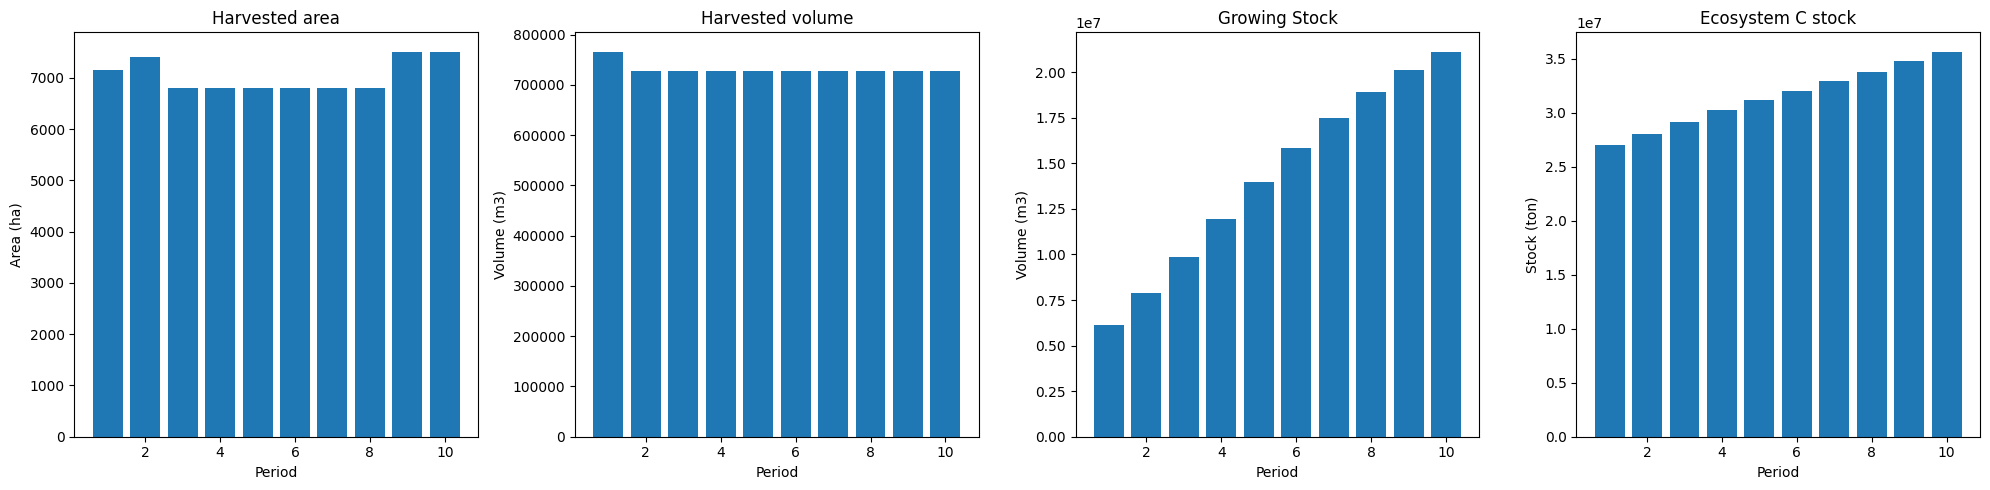

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_bau_gldbr_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  7734
The economic indicator (the provincial government revenues) is:  263762
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


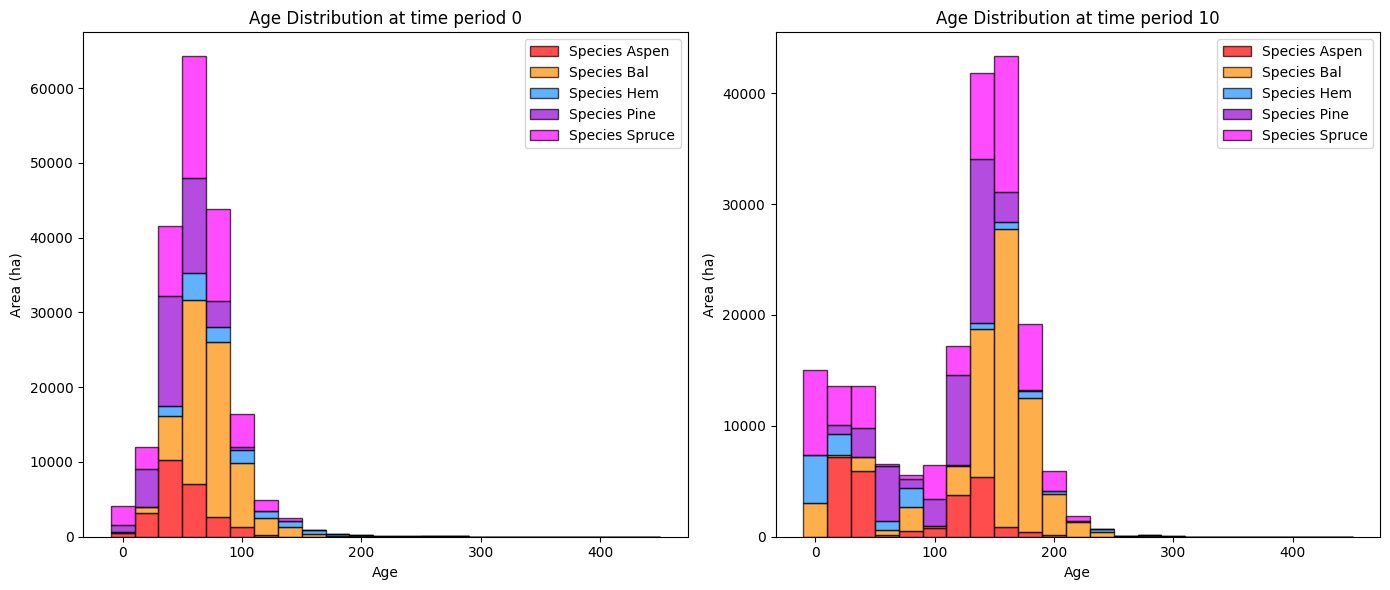

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_bau_gldbr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   4738.556382   4735.847848
Bal     278.565372  11823.627962  11545.062590
Aspen   273.490478   3610.557489   3337.067011
Pine      0.000000   3707.791886   3707.791886
Hem     419.699331    830.482584    410.783253

Old growth has **increased** by 23736.55 hectares from time period 0 to time period 10.


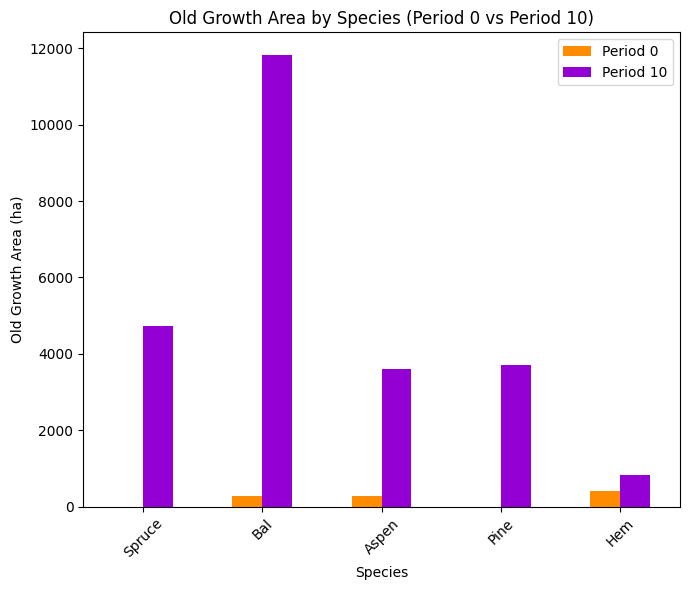

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_bau_gldbr_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.9455
Shannon Evenness Index for time period 10: 0.8181

Diversity has **decreased** by 12.74% from time 0 to time 10.


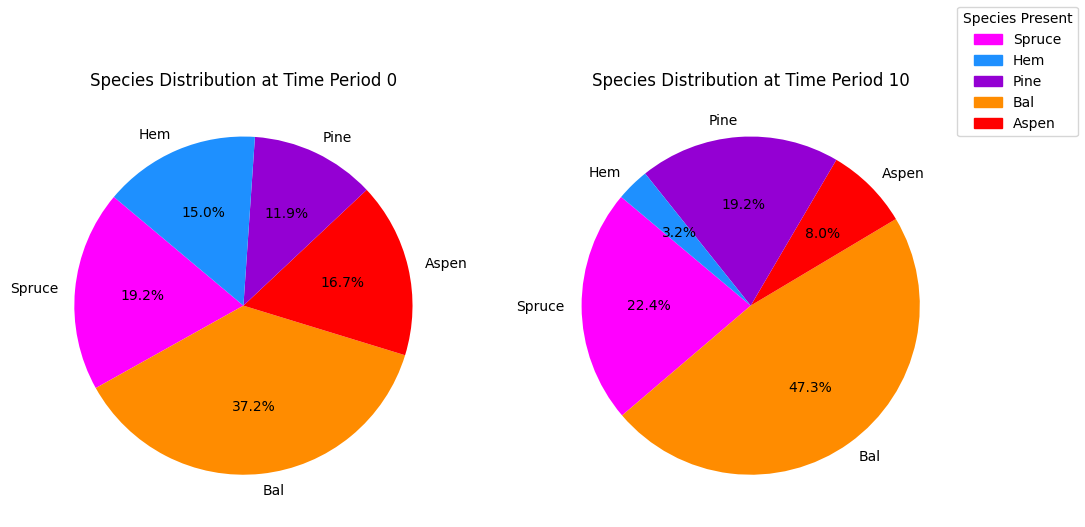

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_st_bau_gldbr_species_pie.pdf


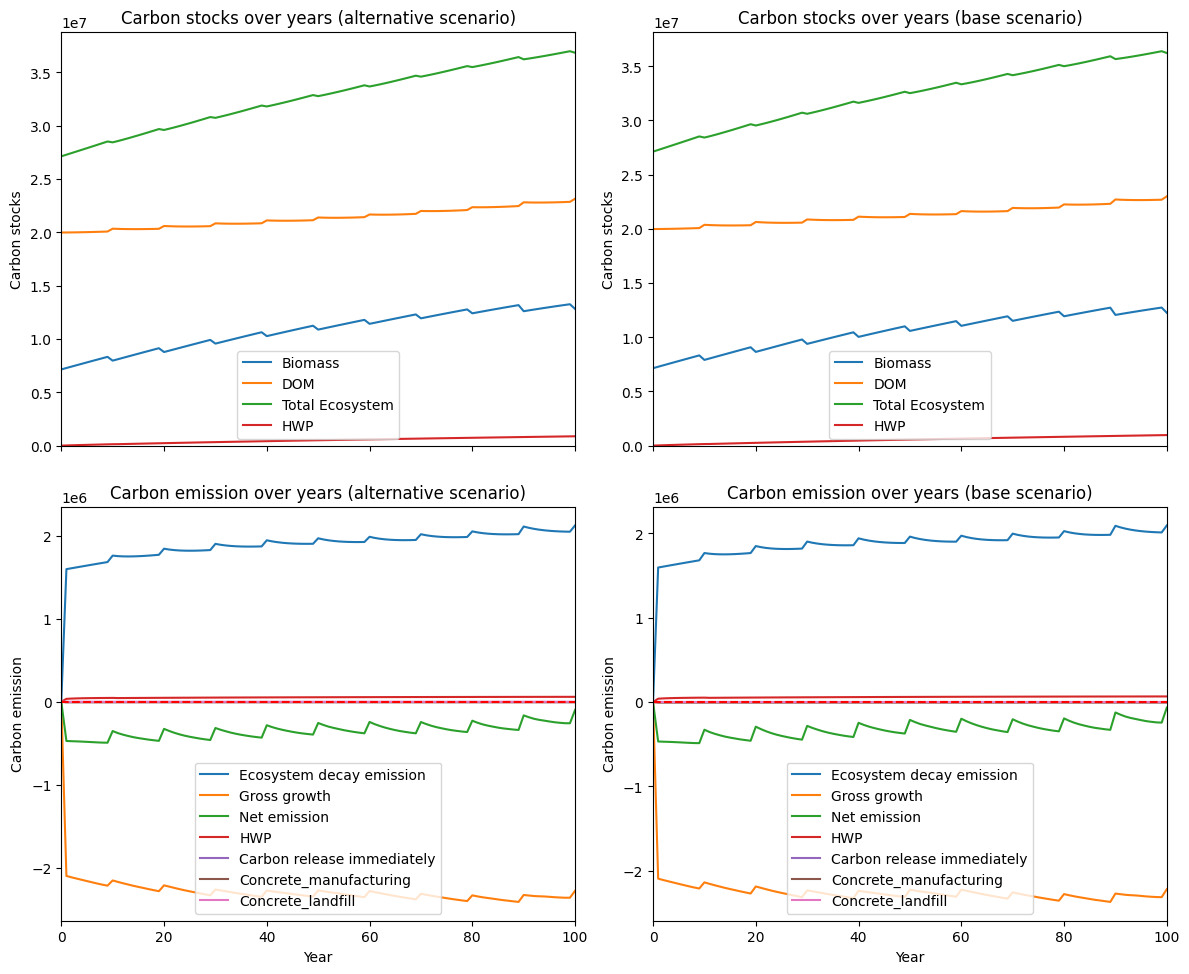

---------------------------------------------------------------------------------------
Net emission difference -2293043.173095238
Net emission base scenario -32702620.346034106
Net emission alternative scenario -34995663.51912935
dollar_per_ton is:  4.361016886787009
Comparison of Old Growth Areas (Alternative - Base)
          0          10  Difference
Spruce  0.0  457.372582  457.372582
Bal     0.0  583.821524  583.821524
Aspen   0.0   35.172521   35.172521
Pine    0.0  376.193764  376.193764
Hem     0.0  106.945991  106.945991

Overall, the old growth area has **increased** by 1559.51 hectares in the alternative scenario compared to the base scenario.


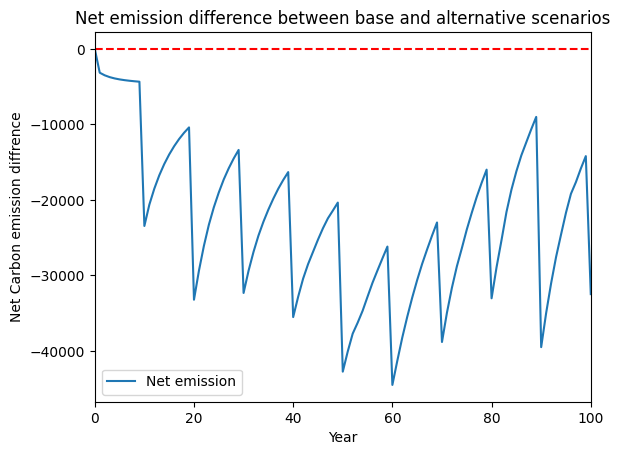

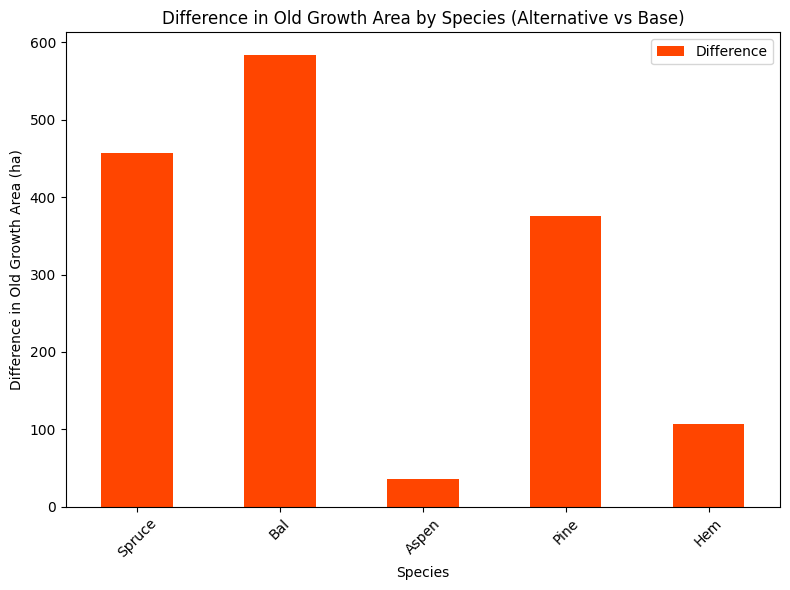

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_kpi_age_difference.pdf


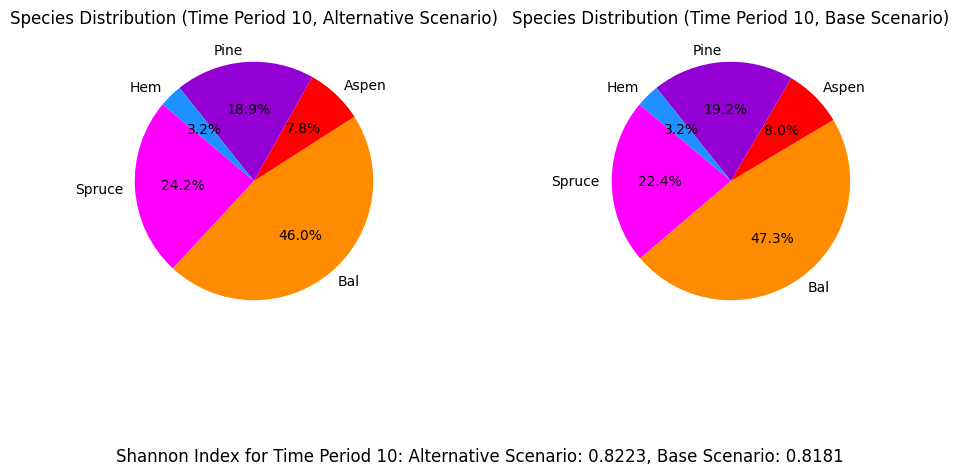

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_st_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for goldenbear_max_st_gldbr_AAC_80%...
running the scenario for the Golden Bear mining site (80%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0x5d1c329a
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e+01, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 2031 columns
Presolve time: 0.13s
Presolved: 1911 rows, 34100 

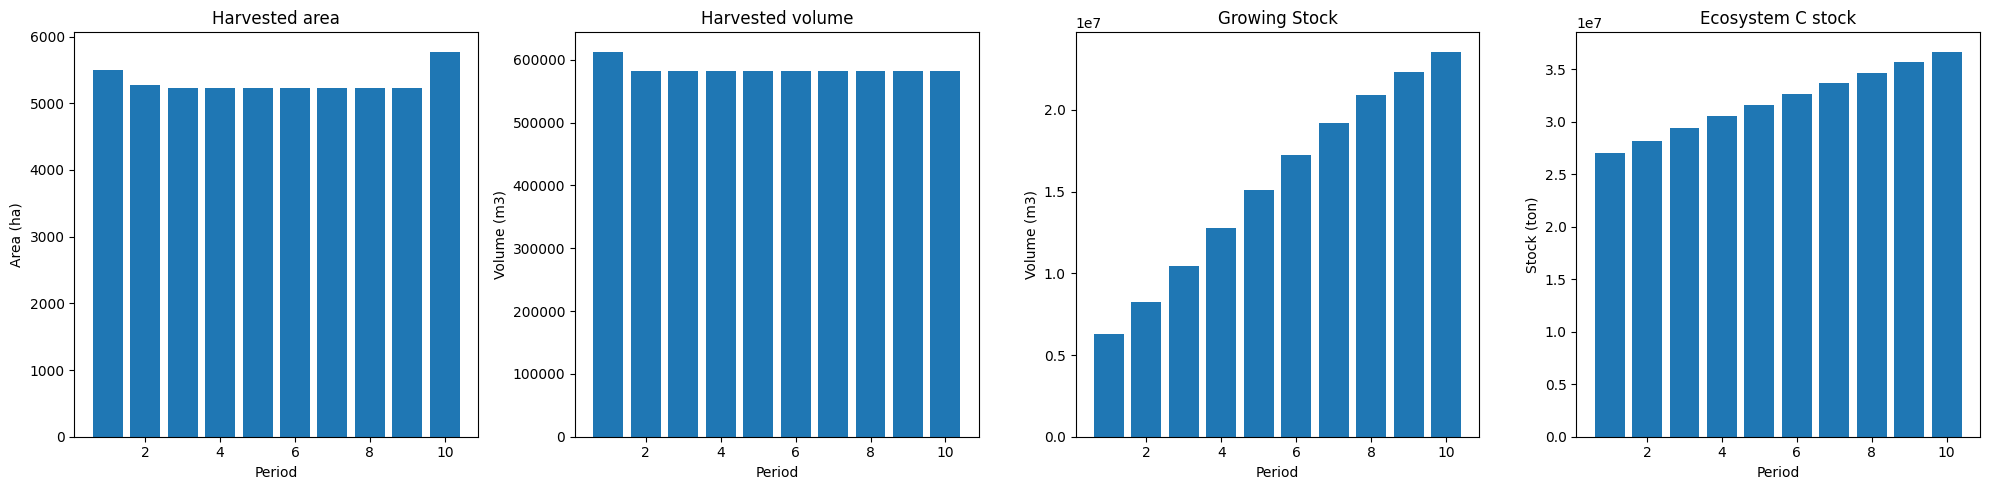

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_gldbr_AAC_80%_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  6187
The economic indicator (the provincial government revenues) is:  211009
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


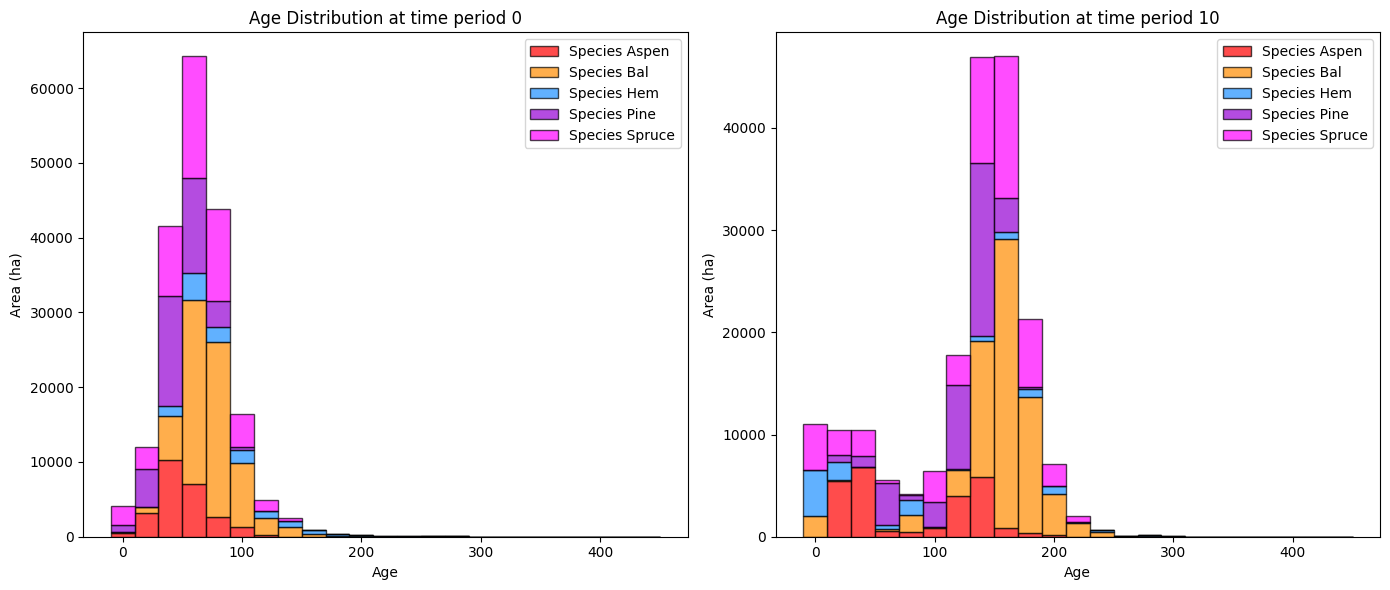

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_gldbr_AAC_80%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   5659.770057   5657.061524
Bal     278.565372  13110.895822  12832.330450
Aspen   273.490478   3795.880615   3522.390137
Pine      0.000000   4535.185984   4535.185984
Hem     419.699331   1193.446669    773.747338

Old growth has **increased** by 27320.72 hectares from time period 0 to time period 10.


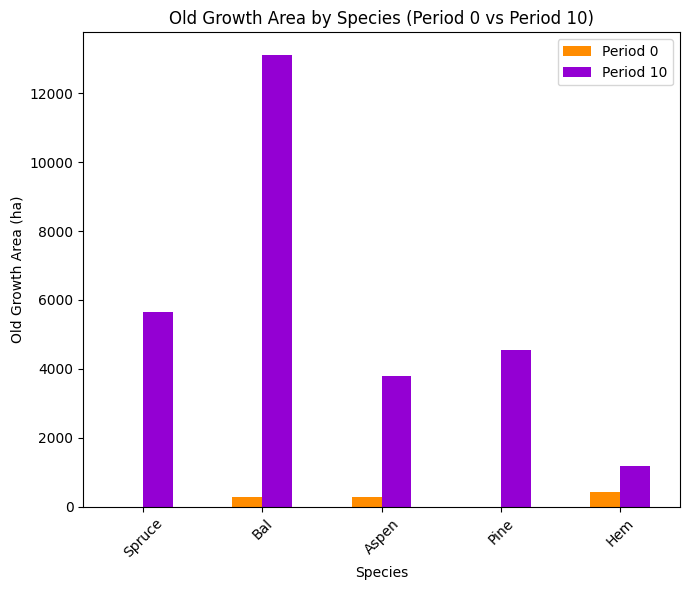

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_gldbr_AAC_80%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.9455
Shannon Evenness Index for time period 10: 0.8284

Diversity has **decreased** by 11.71% from time 0 to time 10.


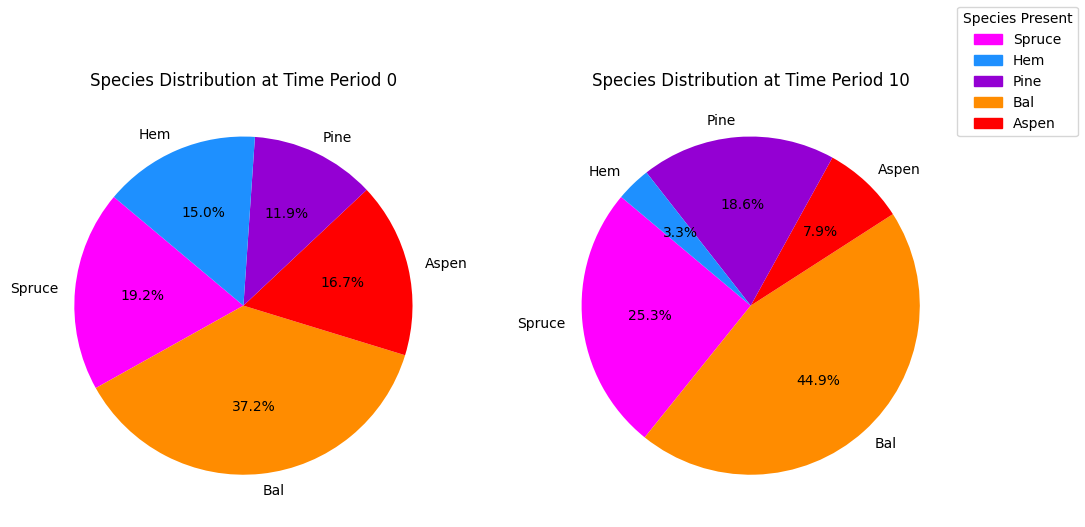

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_st_gldbr_AAC_80%_species_pie.pdf
running business as usual scenario for the Golden Bear mine site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0xf8fbe06d
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e+01, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 2031 columns
Presolve time: 0.11s
Presolved: 1911 rows, 34099 columns, 409165 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time

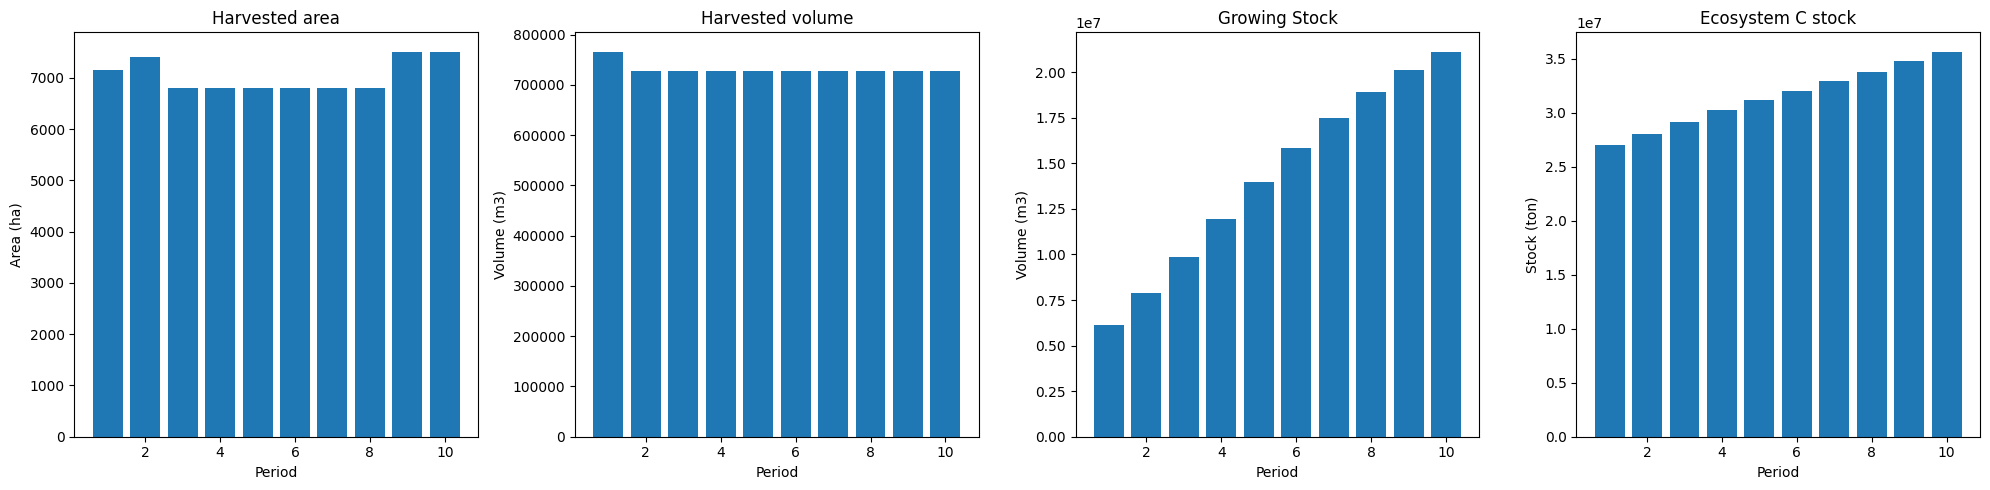

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_bau_gldbr_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  7734
The economic indicator (the provincial government revenues) is:  263762
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


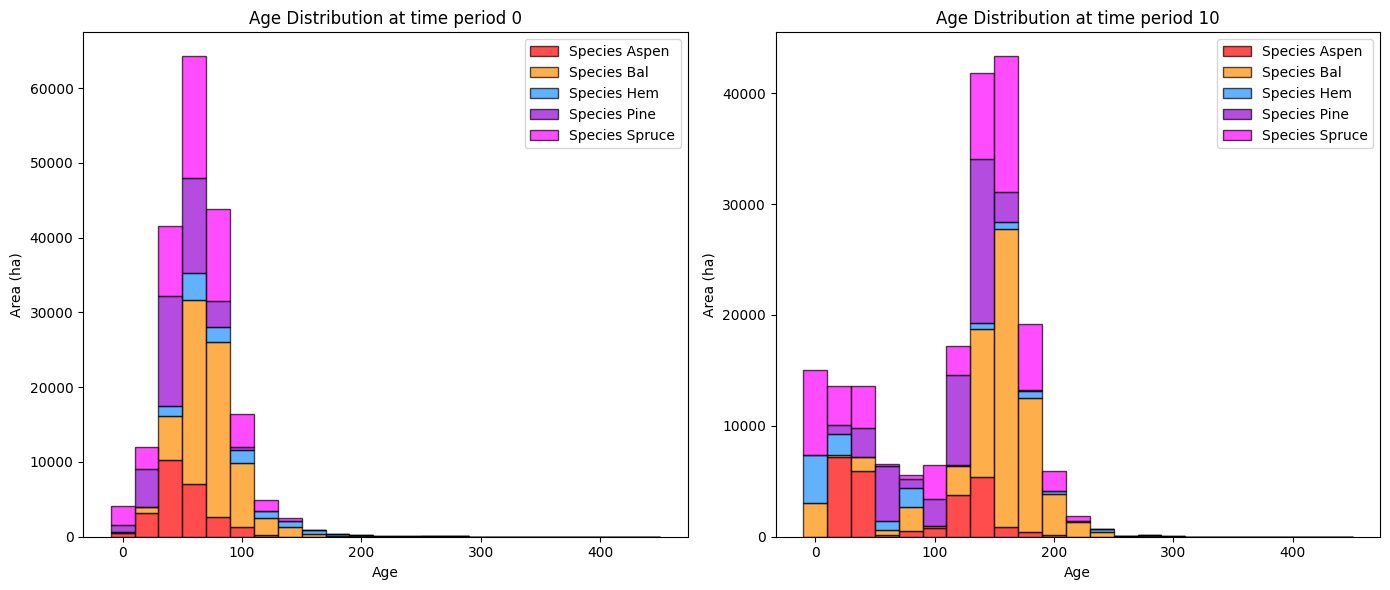

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_bau_gldbr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   4738.556382   4735.847848
Bal     278.565372  11823.627962  11545.062590
Aspen   273.490478   3610.557489   3337.067011
Pine      0.000000   3707.791886   3707.791886
Hem     419.699331    830.482584    410.783253

Old growth has **increased** by 23736.55 hectares from time period 0 to time period 10.


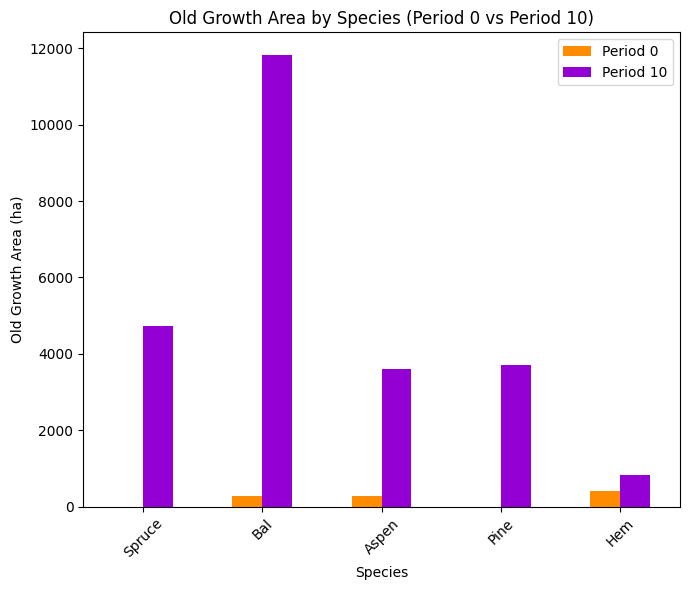

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_bau_gldbr_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.9455
Shannon Evenness Index for time period 10: 0.8181

Diversity has **decreased** by 12.74% from time 0 to time 10.


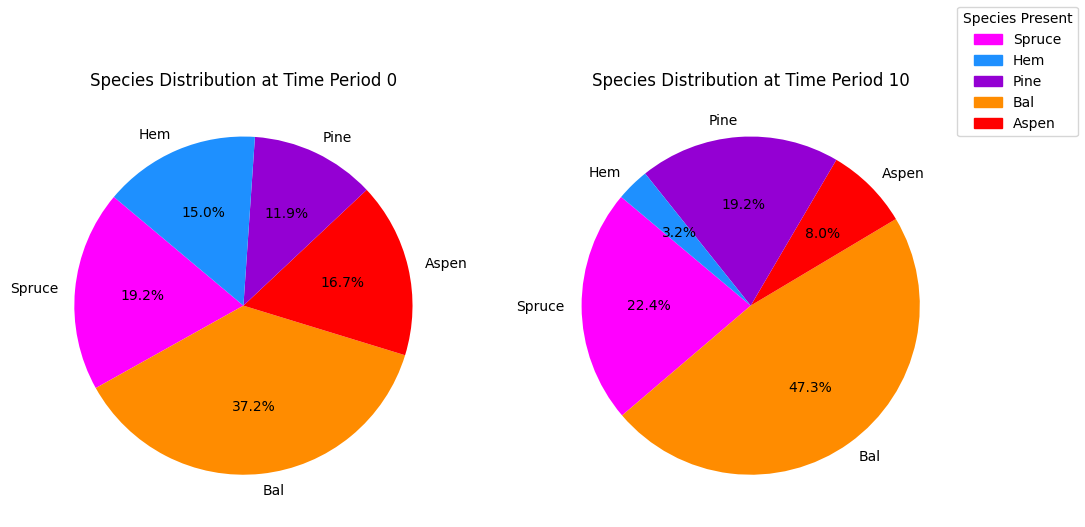

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_st_bau_gldbr_species_pie.pdf


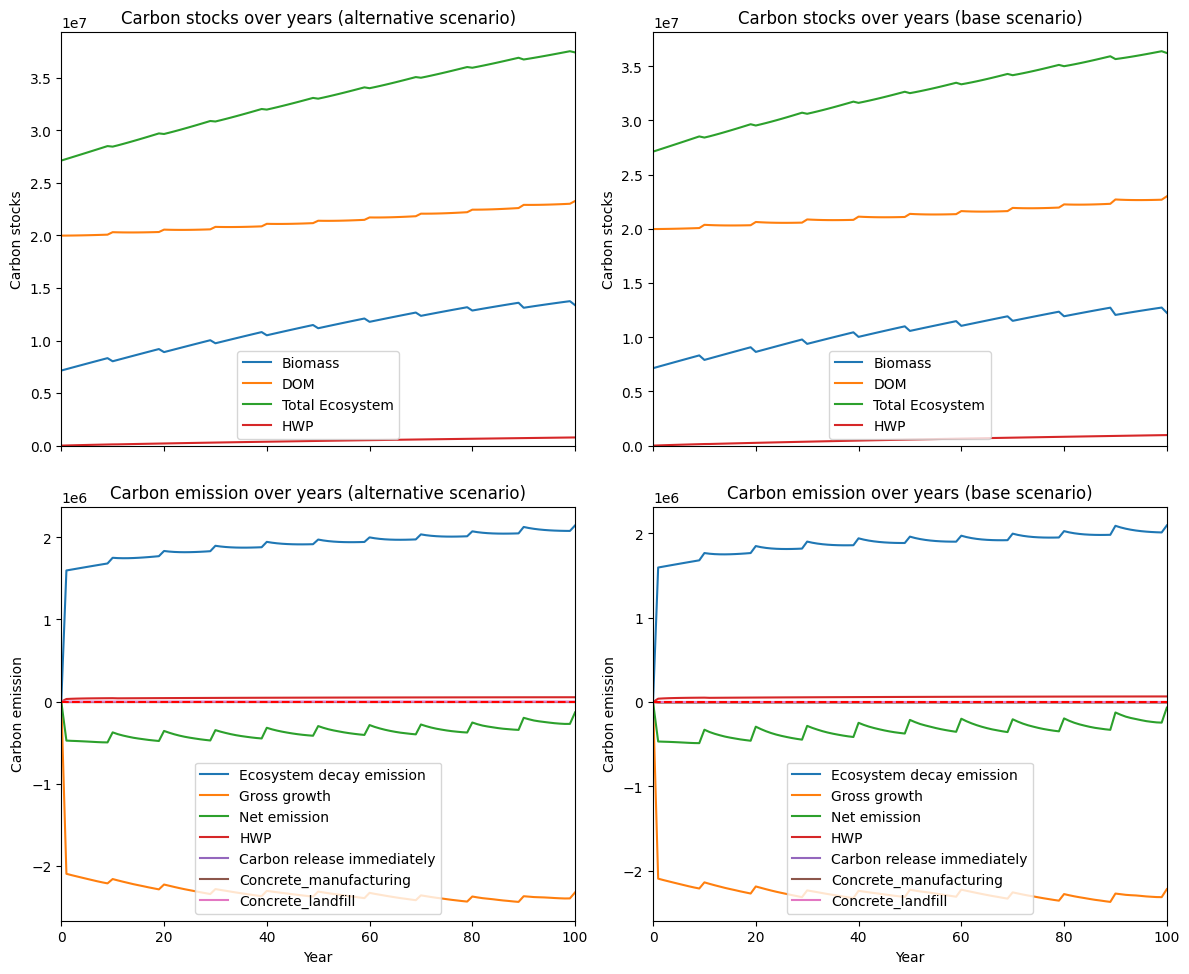

---------------------------------------------------------------------------------------
Net emission difference -4435382.180164781
Net emission base scenario -32702620.346034106
Net emission alternative scenario -37138002.52619889
dollar_per_ton is:  2.2545971449135607
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Spruce  0.0   921.213675   921.213675
Bal     0.0  1287.267860  1287.267860
Aspen   0.0   185.323126   185.323126
Pine    0.0   827.394099   827.394099
Hem     0.0   362.964085   362.964085

Overall, the old growth area has **increased** by 3584.16 hectares in the alternative scenario compared to the base scenario.


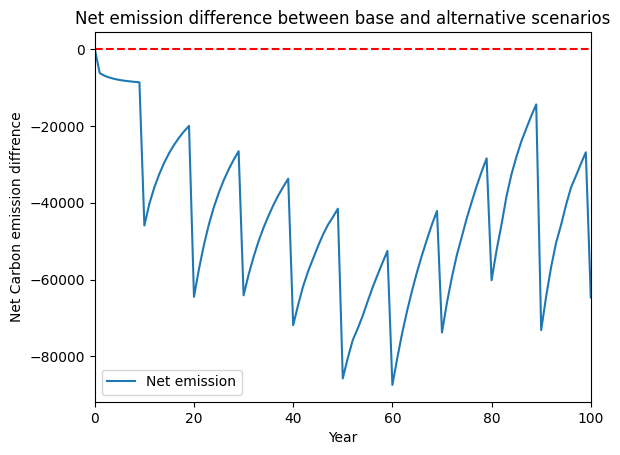

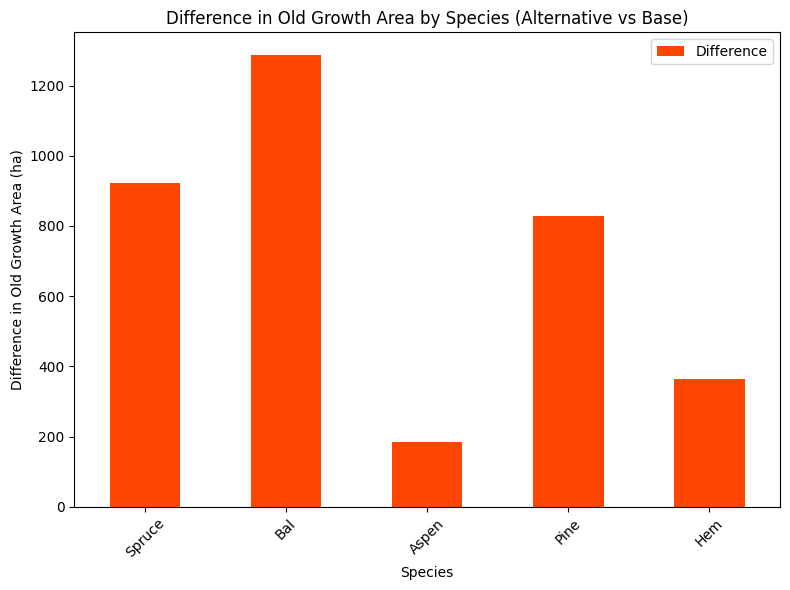

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_kpi_age_difference.pdf


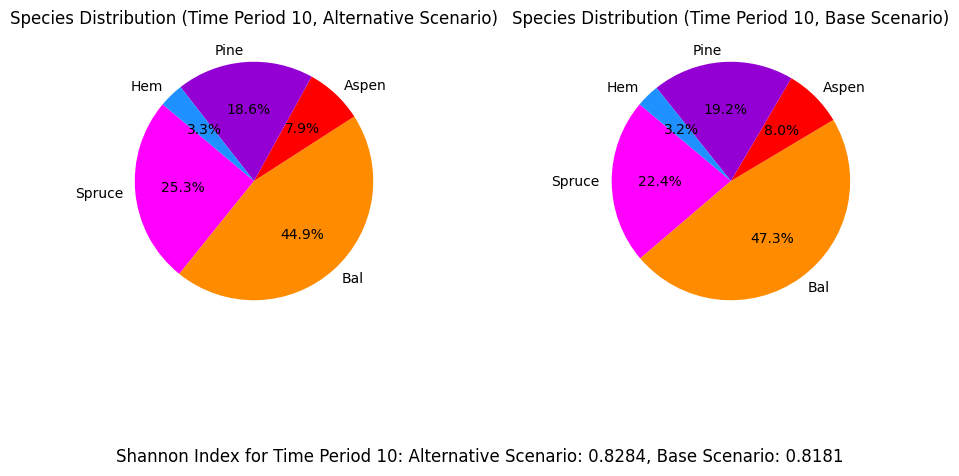

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_st_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for goldenbear_max_st_gldbr_AAC_70%...
running the scenario for the Golden Bear mining site (70%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0x78b41b73
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e+01, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 2031 columns
Presolve time: 0.13s
Presolved: 1911 rows, 34100 

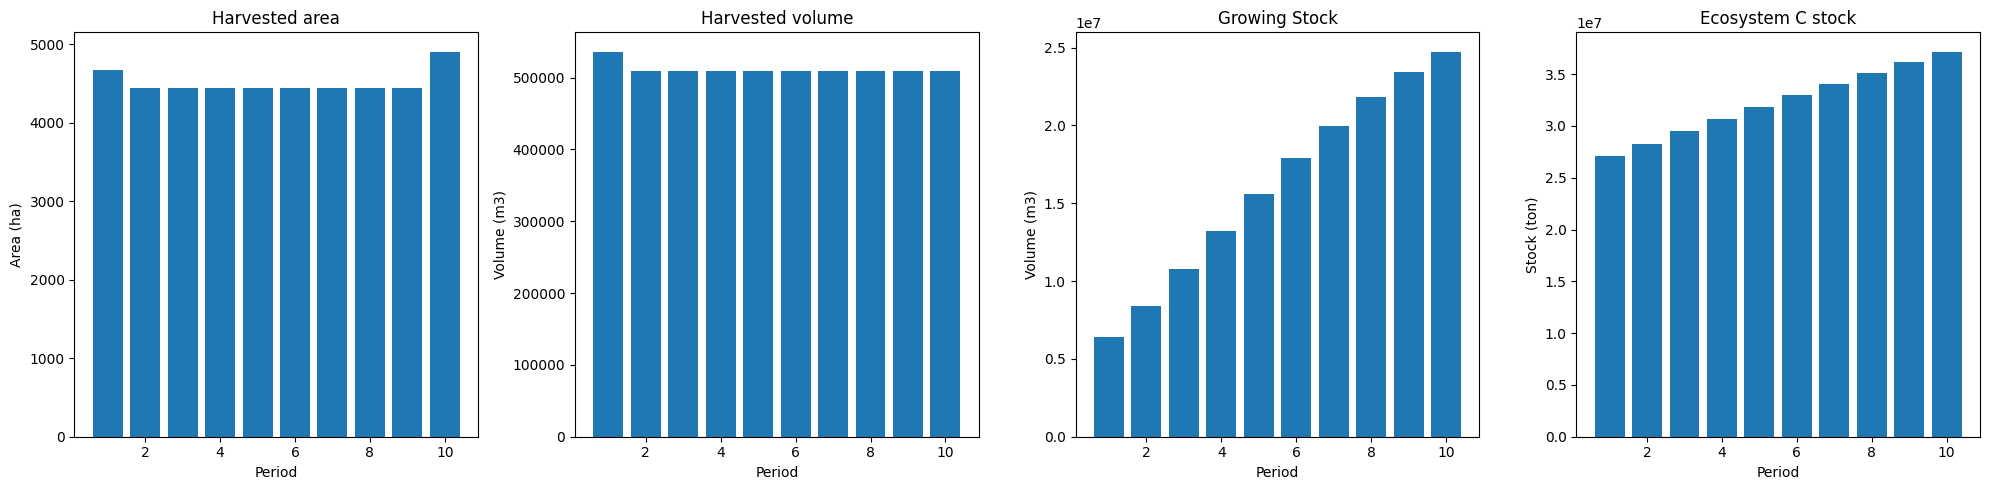

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_gldbr_AAC_70%_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  5414
The economic indicator (the provincial government revenues) is:  184633
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


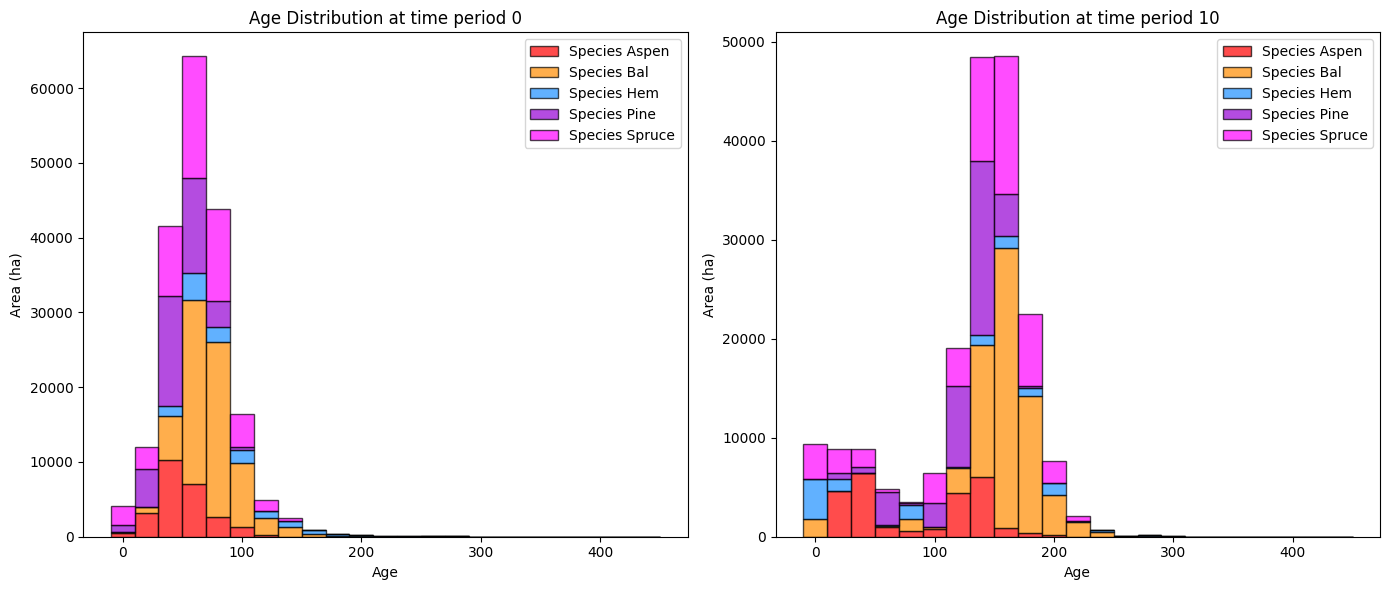

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_gldbr_AAC_70%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   5998.181720   5995.473186
Bal     278.565372  13620.473165  13341.907793
Aspen   273.490478   4013.439512   3739.949034
Pine      0.000000   5154.939546   5154.939546
Hem     419.699331   1423.894399   1004.195069

Old growth has **increased** by 29236.46 hectares from time period 0 to time period 10.


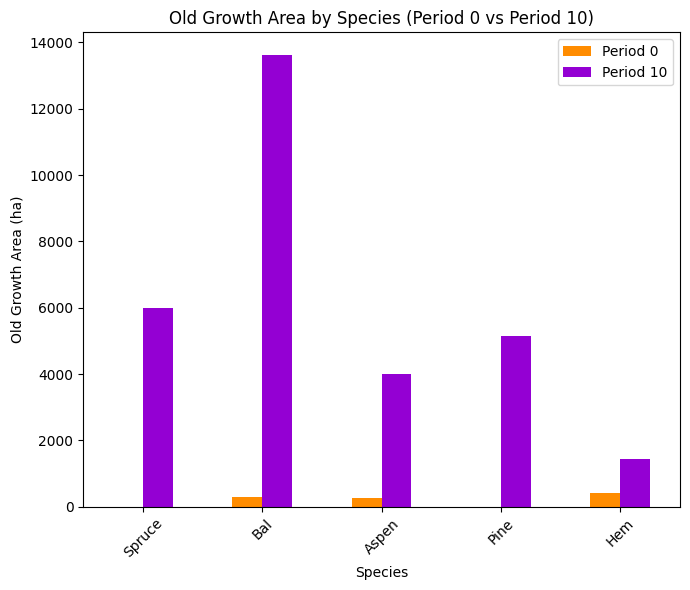

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_gldbr_AAC_70%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.9455
Shannon Evenness Index for time period 10: 0.8493

Diversity has **decreased** by 9.62% from time 0 to time 10.


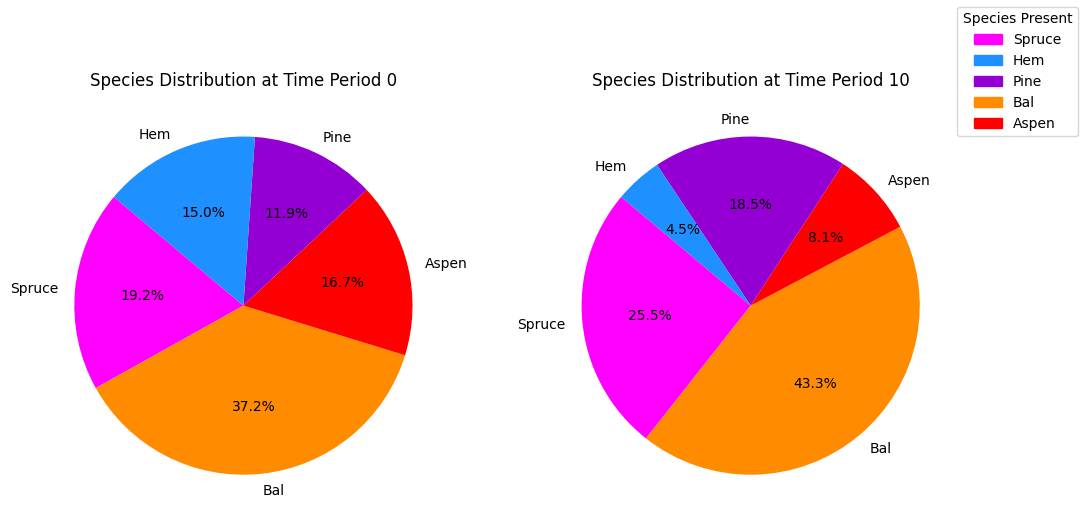

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_st_gldbr_AAC_70%_species_pie.pdf
running business as usual scenario for the Golden Bear mine site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0xf8fbe06d
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e+01, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 2031 columns
Presolve time: 0.15s
Presolved: 1911 rows, 34099 columns, 409165 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time

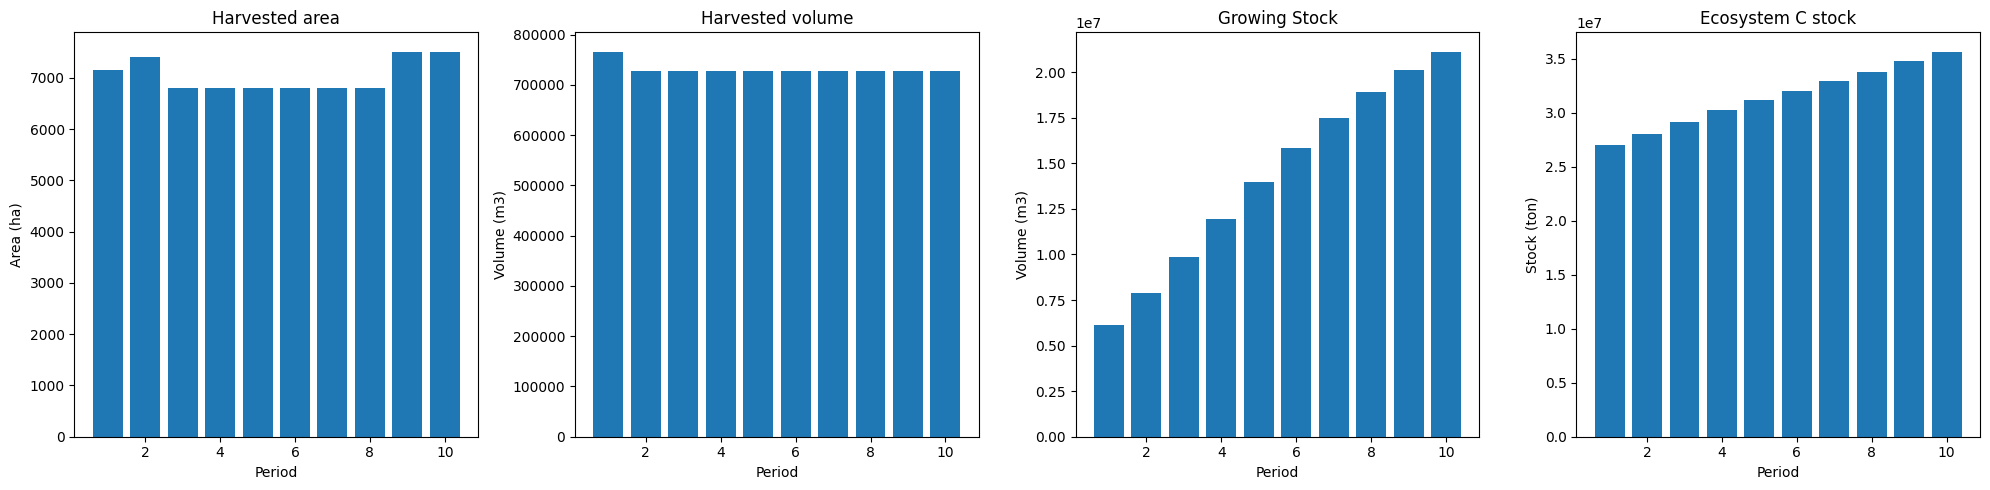

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_bau_gldbr_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  7734
The economic indicator (the provincial government revenues) is:  263762
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


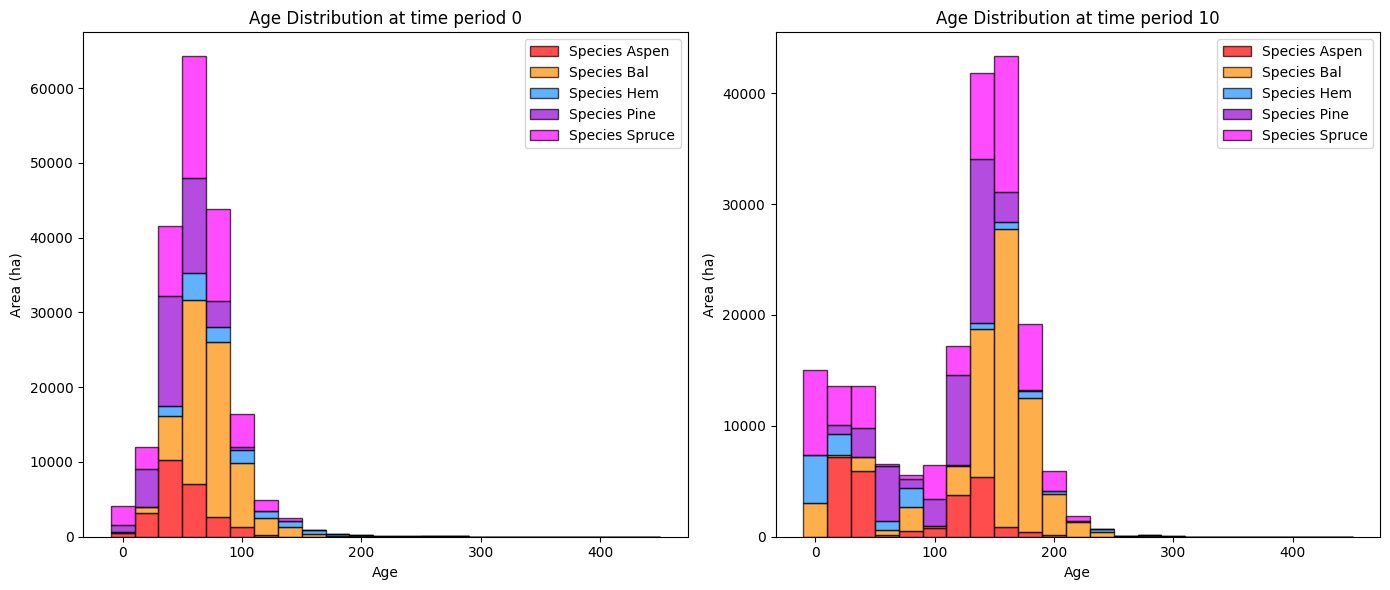

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_bau_gldbr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   4738.556382   4735.847848
Bal     278.565372  11823.627962  11545.062590
Aspen   273.490478   3610.557489   3337.067011
Pine      0.000000   3707.791886   3707.791886
Hem     419.699331    830.482584    410.783253

Old growth has **increased** by 23736.55 hectares from time period 0 to time period 10.


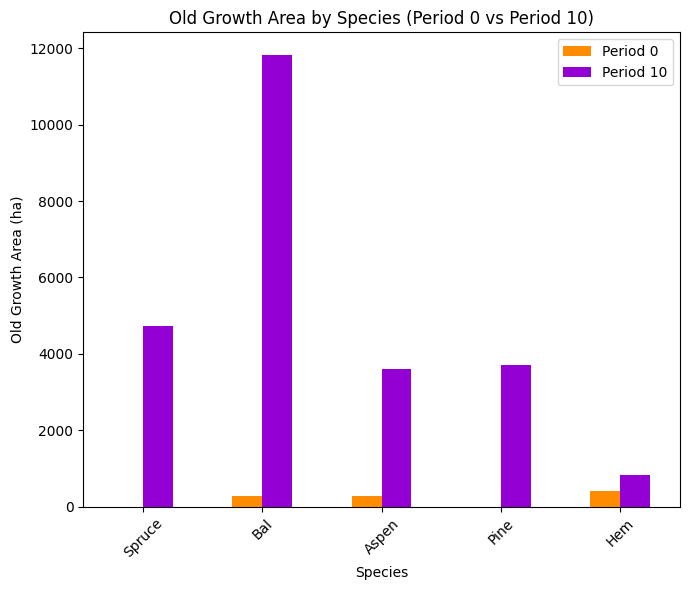

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_bau_gldbr_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.9455
Shannon Evenness Index for time period 10: 0.8181

Diversity has **decreased** by 12.74% from time 0 to time 10.


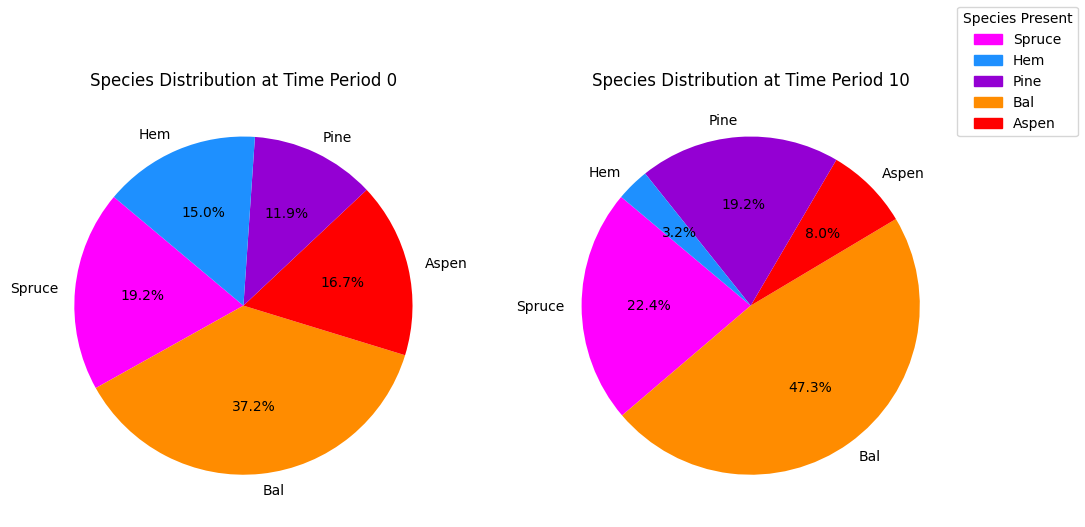

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_st_bau_gldbr_species_pie.pdf


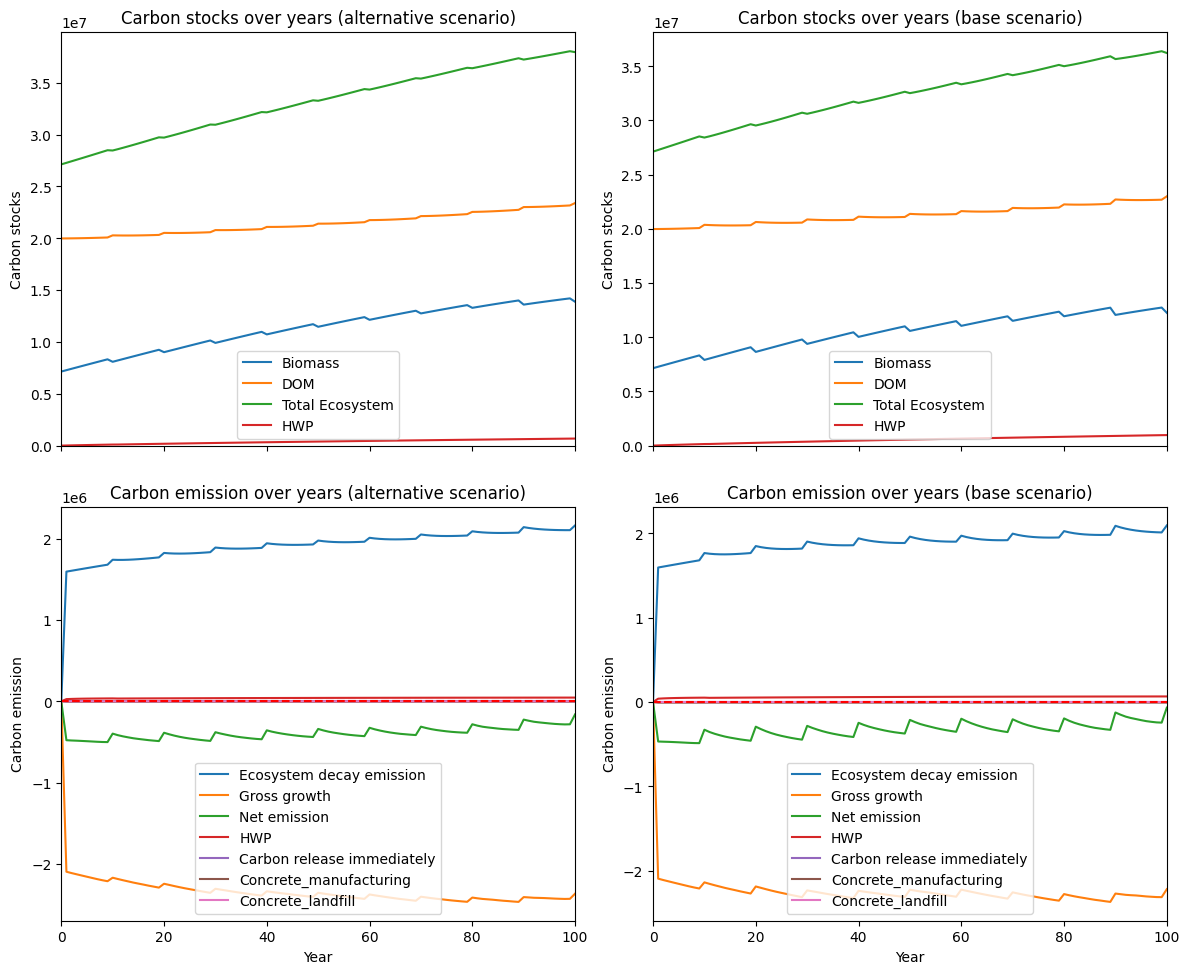

---------------------------------------------------------------------------------------
Net emission difference -6455226.383063658
Net emission base scenario -32702620.346034106
Net emission alternative scenario -39157846.72909776
dollar_per_ton is:  1.5491323474319405
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Spruce  0.0  1259.625338  1259.625338
Bal     0.0  1796.845202  1796.845202
Aspen   0.0   402.882023   402.882023
Pine    0.0  1447.147660  1447.147660
Hem     0.0   593.411815   593.411815

Overall, the old growth area has **increased** by 5499.91 hectares in the alternative scenario compared to the base scenario.


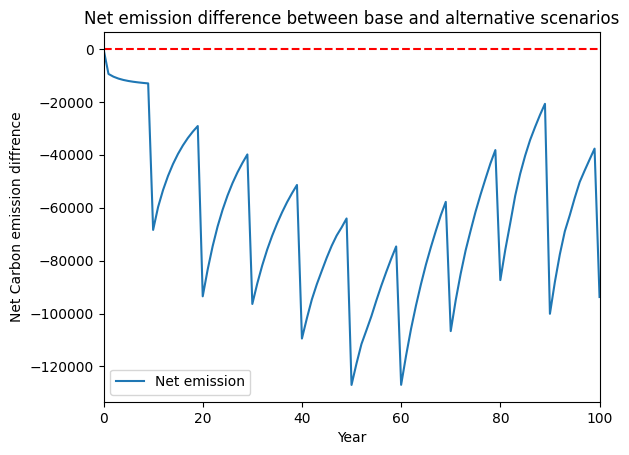

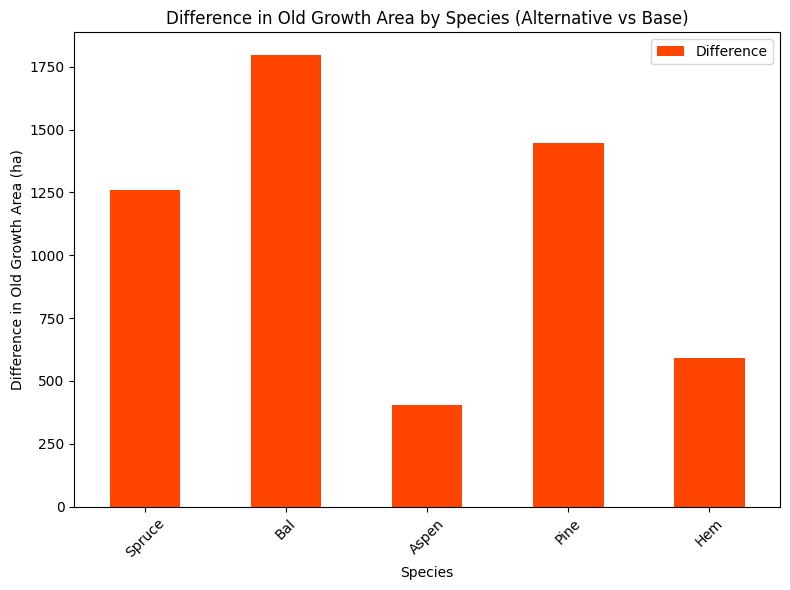

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_kpi_age_difference.pdf


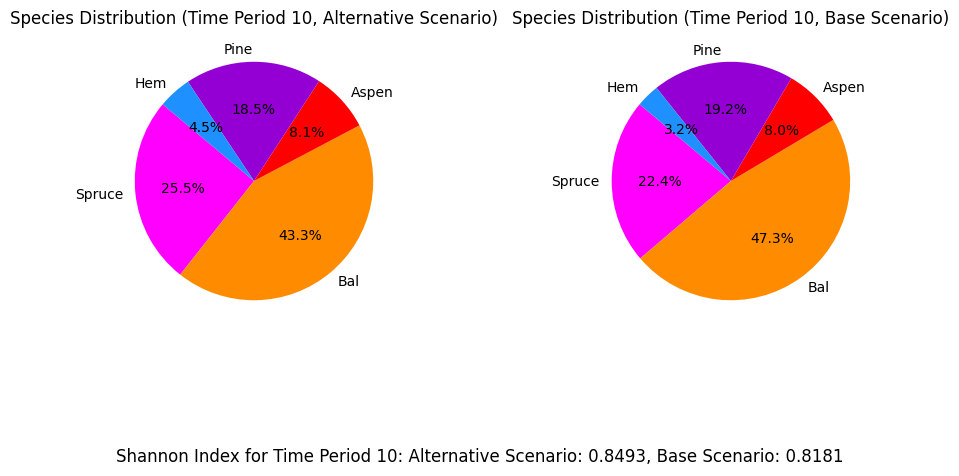

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_st_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for goldenbear_max_st_gldbr_AAC_60%...
running the scenario for the Golden Bear mining site (60%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0xeb378c7a
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e+01, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 2031 columns
Presolve time: 0.19s
Presolved: 1911 rows, 34100 

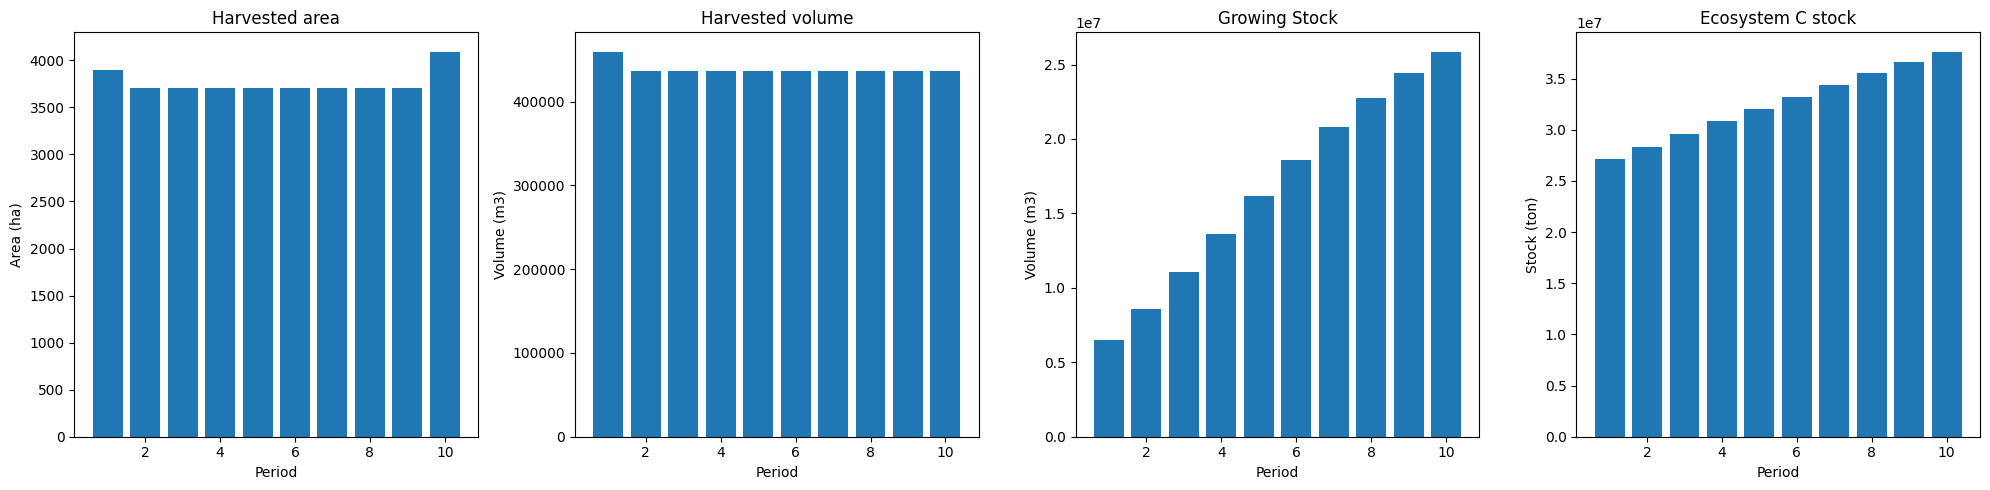

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_gldbr_AAC_60%_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  4640
The economic indicator (the provincial government revenues) is:  158257
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


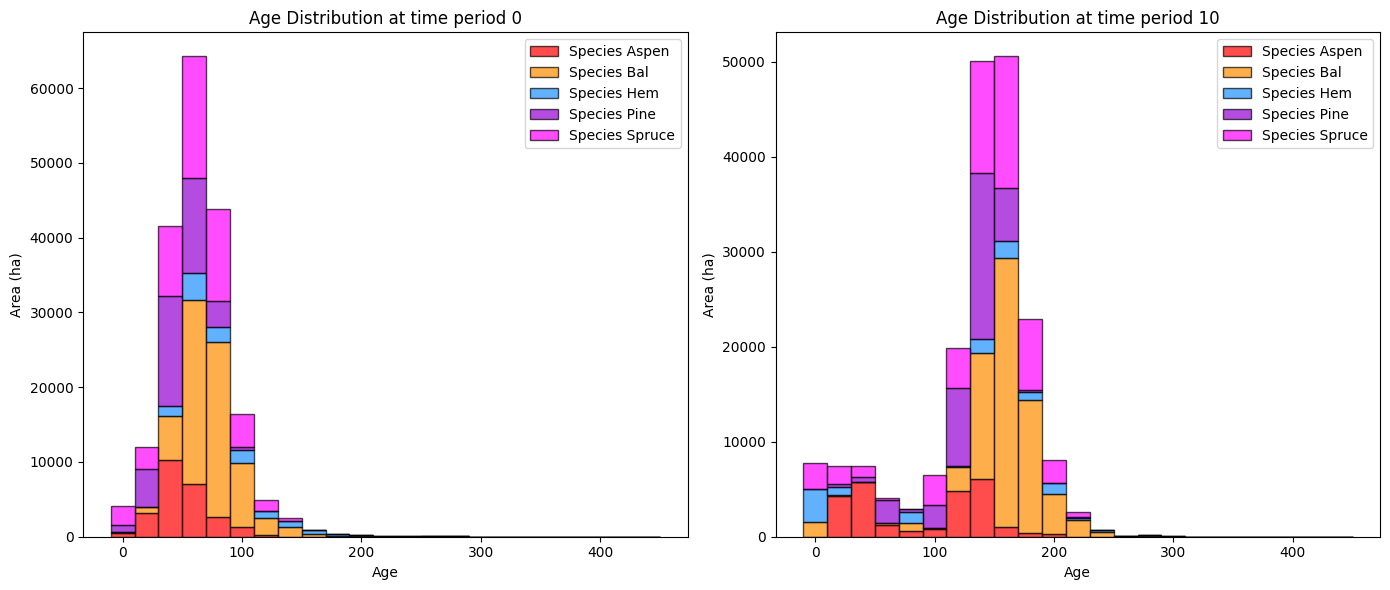

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_gldbr_AAC_60%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   6415.887733   6413.179200
Bal     278.565372  14039.825589  13761.260217
Aspen   273.490478   4315.720749   4042.230271
Pine      0.000000   5786.664808   5786.664808
Hem     419.699331   1615.182202   1195.482871

Old growth has **increased** by 31198.82 hectares from time period 0 to time period 10.


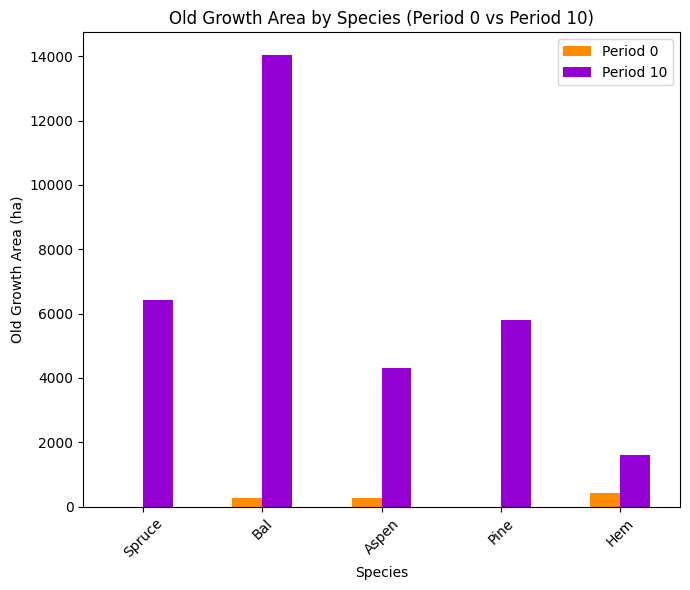

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_gldbr_AAC_60%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.9455
Shannon Evenness Index for time period 10: 0.8639

Diversity has **decreased** by 8.17% from time 0 to time 10.


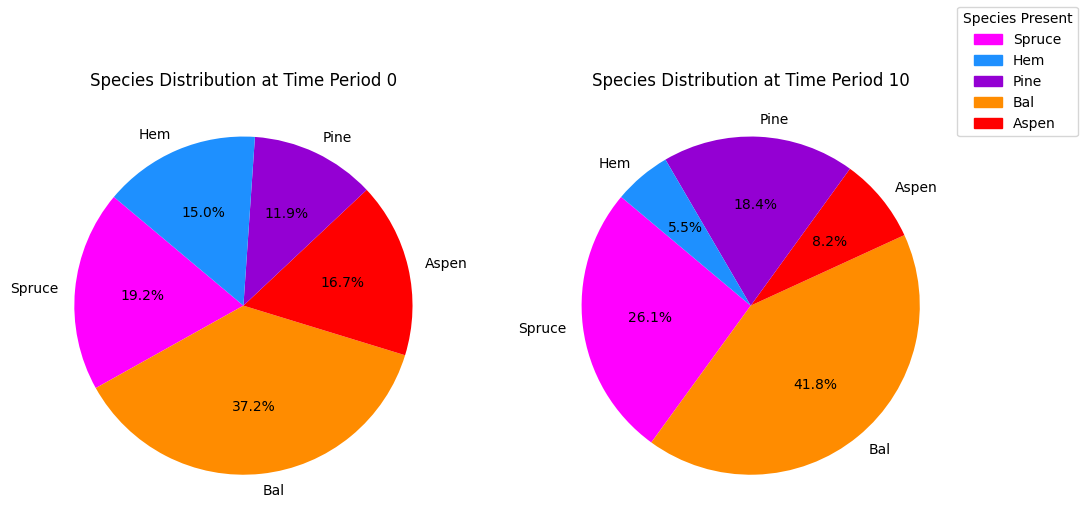

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_st_gldbr_AAC_60%_species_pie.pdf
running business as usual scenario for the Golden Bear mine site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0xf8fbe06d
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e+01, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 2031 columns
Presolve time: 0.14s
Presolved: 1911 rows, 34099 columns, 409165 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time

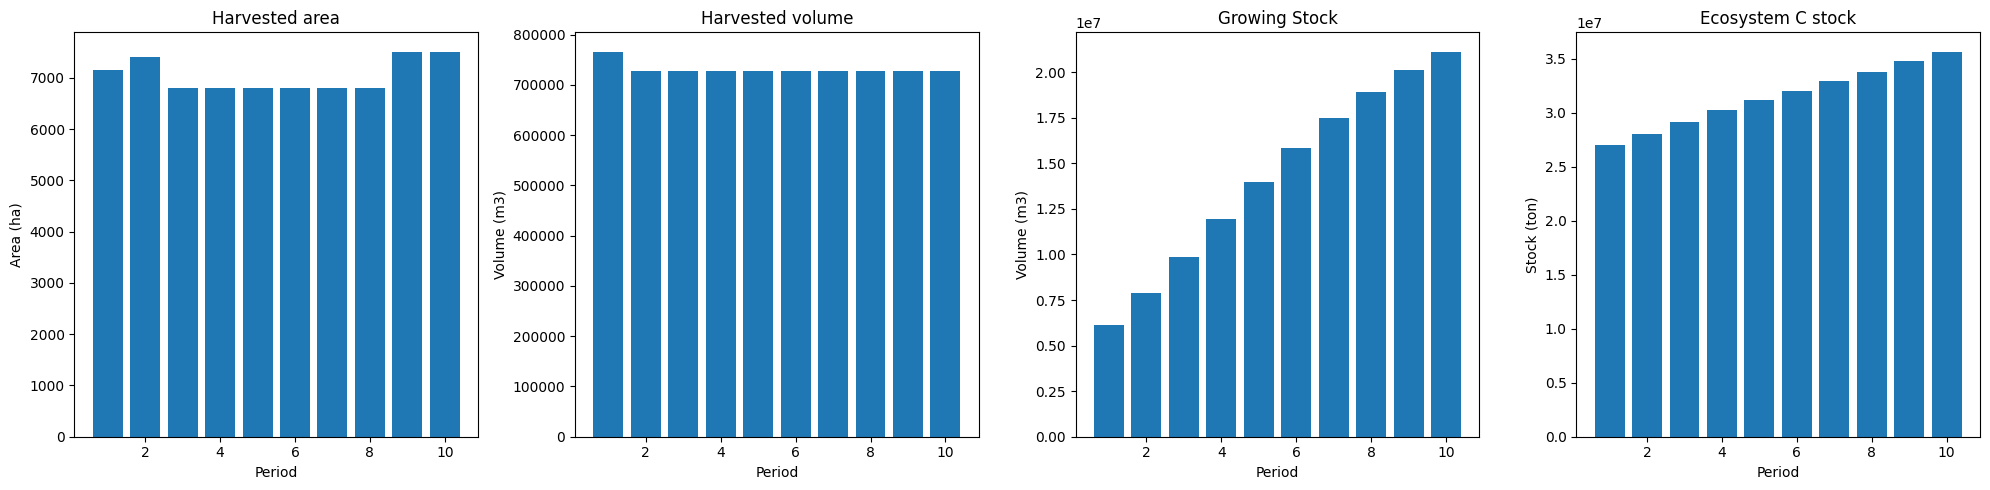

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_bau_gldbr_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  7734
The economic indicator (the provincial government revenues) is:  263762
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


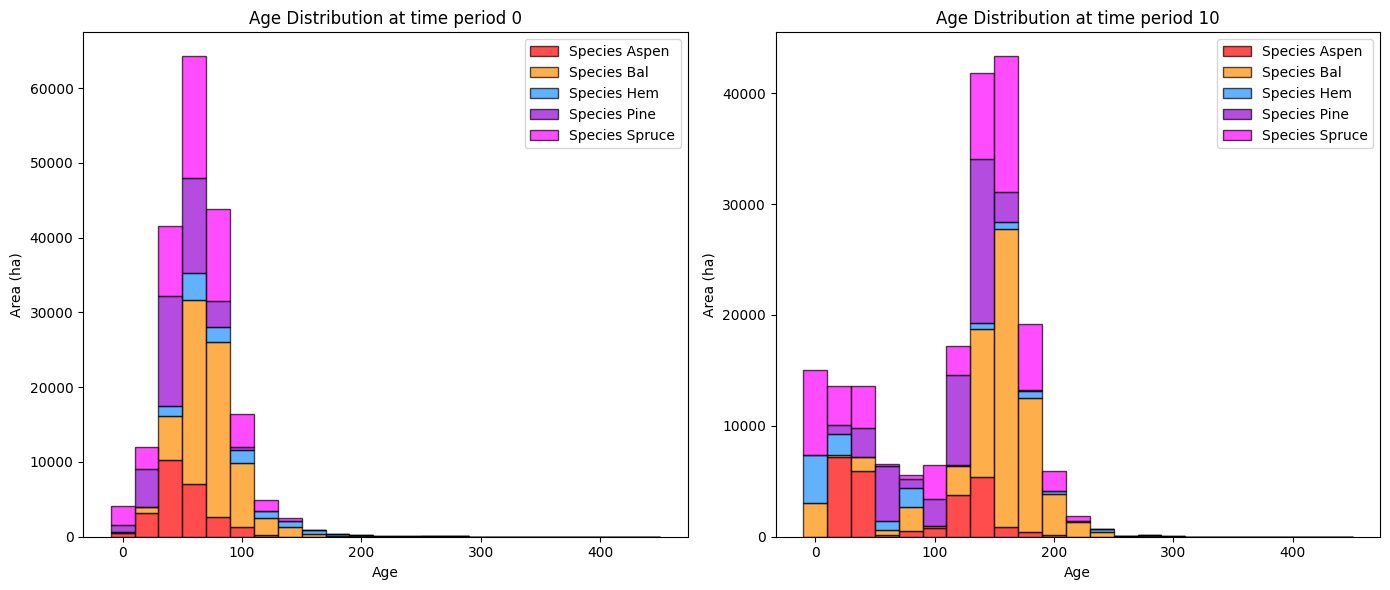

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_bau_gldbr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   4738.556382   4735.847848
Bal     278.565372  11823.627962  11545.062590
Aspen   273.490478   3610.557489   3337.067011
Pine      0.000000   3707.791886   3707.791886
Hem     419.699331    830.482584    410.783253

Old growth has **increased** by 23736.55 hectares from time period 0 to time period 10.


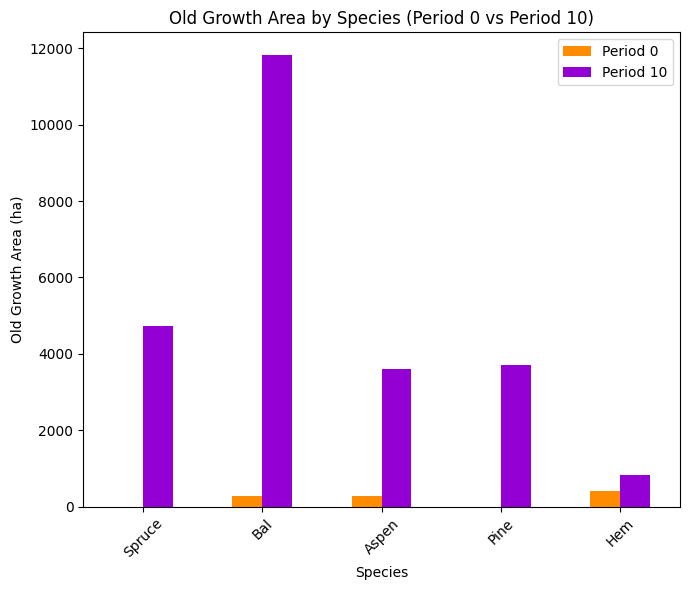

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_bau_gldbr_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.9455
Shannon Evenness Index for time period 10: 0.8181

Diversity has **decreased** by 12.74% from time 0 to time 10.


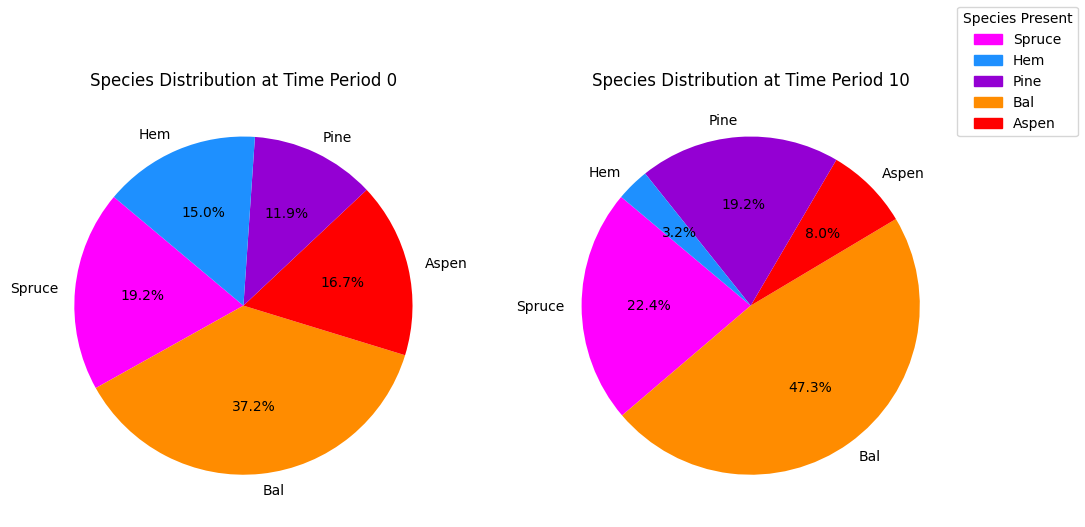

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_st_bau_gldbr_species_pie.pdf


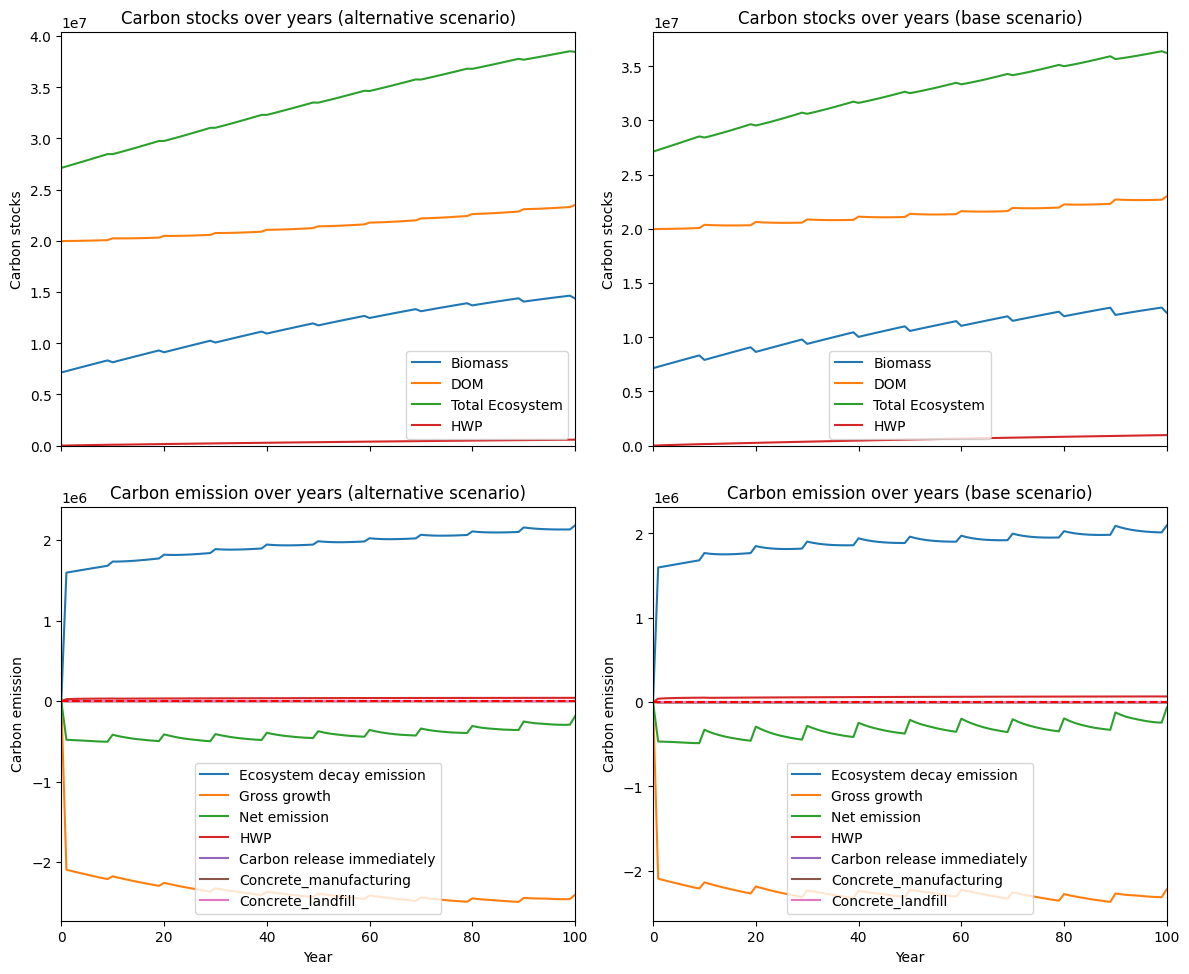

---------------------------------------------------------------------------------------
Net emission difference -8388017.953232365
Net emission base scenario -32702620.346034106
Net emission alternative scenario -41090638.29926647
dollar_per_ton is:  1.192176752095106
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Spruce  0.0  1677.331352  1677.331352
Bal     0.0  2216.197627  2216.197627
Aspen   0.0   705.163259   705.163259
Pine    0.0  2078.872922  2078.872922
Hem     0.0   784.699618   784.699618

Overall, the old growth area has **increased** by 7462.26 hectares in the alternative scenario compared to the base scenario.


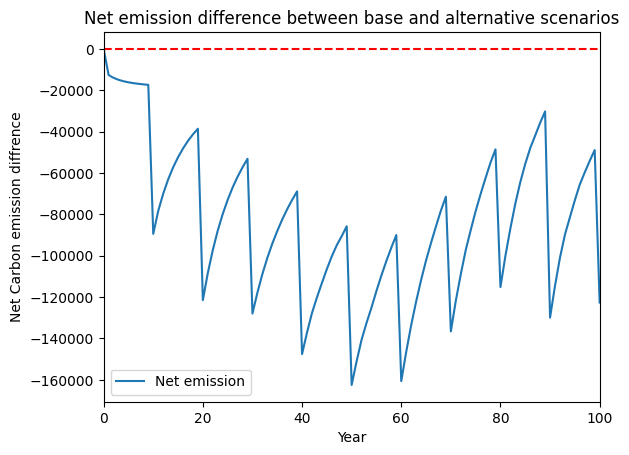

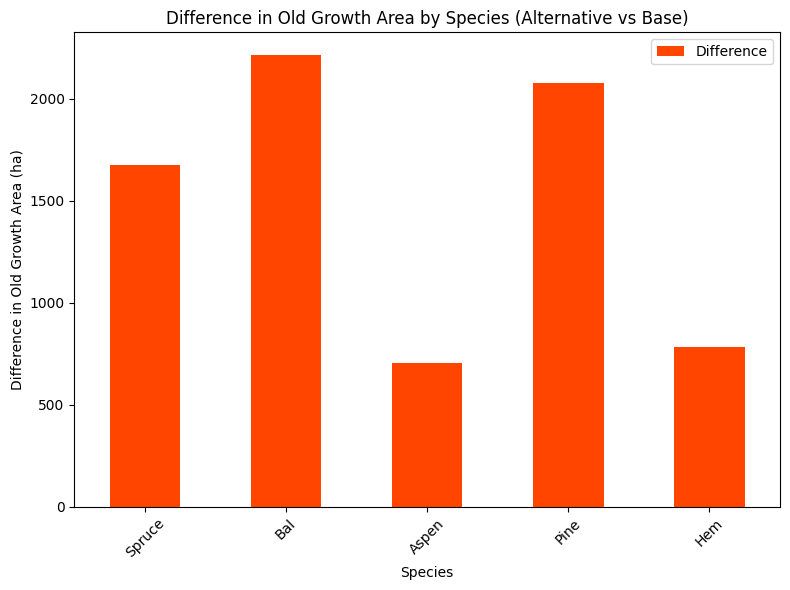

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_kpi_age_difference.pdf


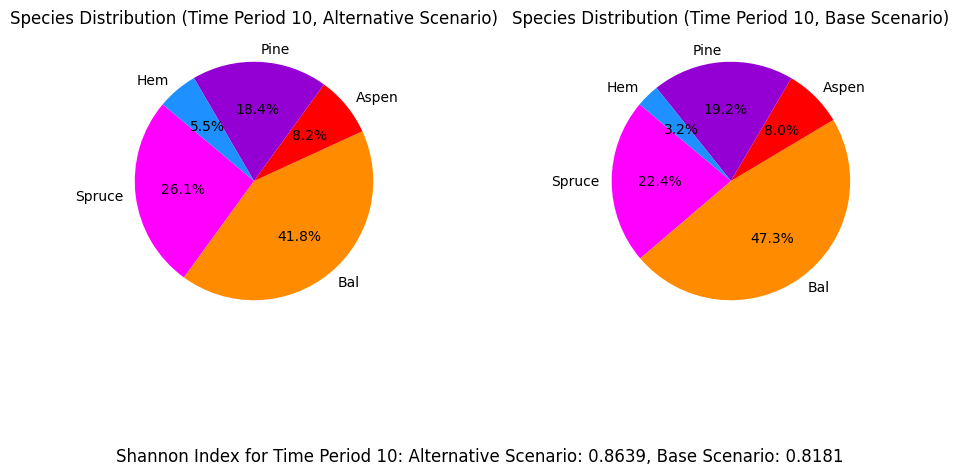

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_st_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for goldenbear_max_st_gldbr_AAC_50%...
running the scenario for the Golden Bear mining site (50%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0x0c213b9b
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e+01, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 2031 columns
Presolve time: 0.13s
Presolved: 1911 rows, 34100 

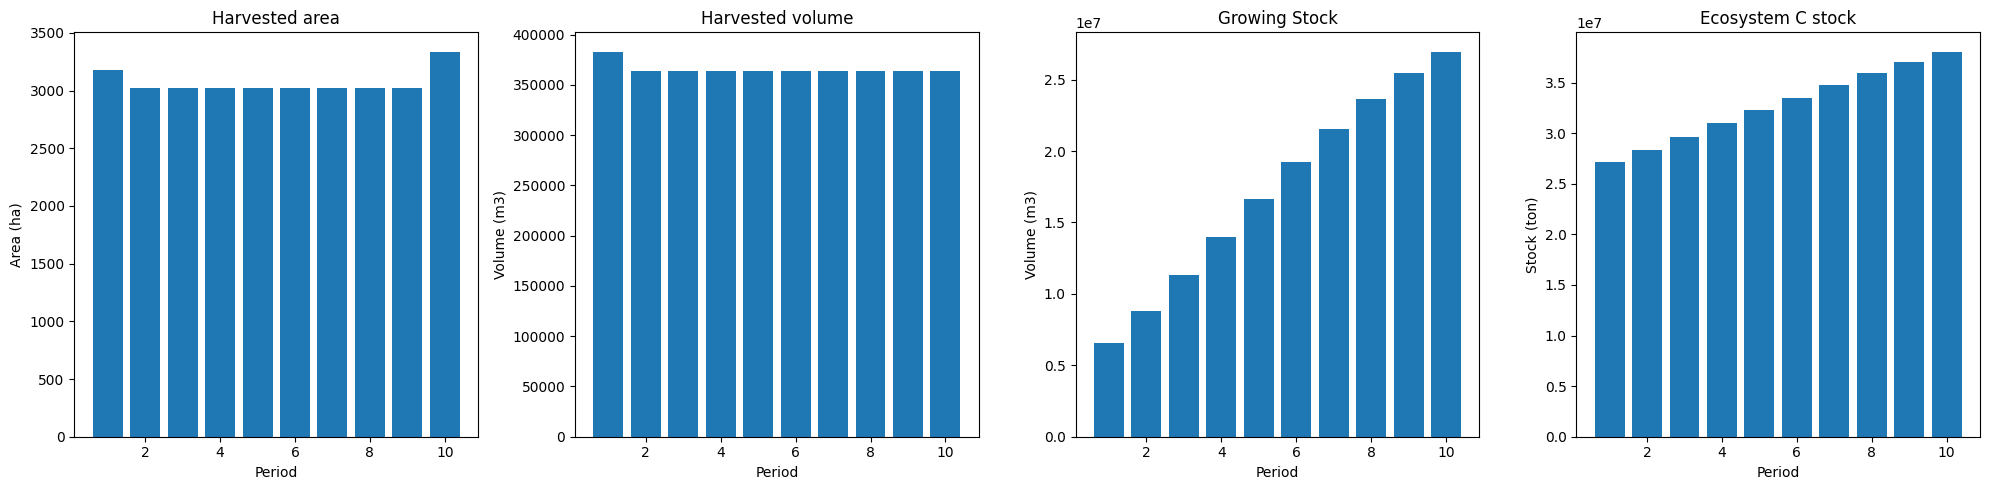

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_gldbr_AAC_50%_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  3867
The economic indicator (the provincial government revenues) is:  131881
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


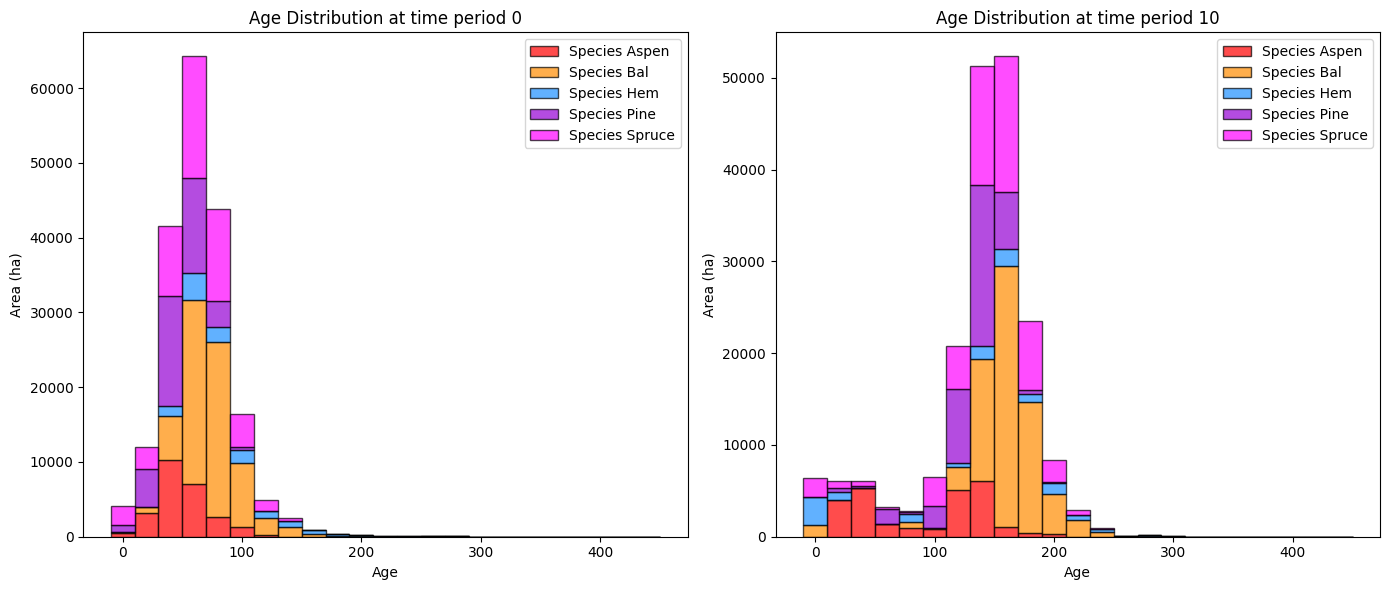

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_gldbr_AAC_50%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   6993.546037   6990.837503
Bal     278.565372  14602.204608  14323.639237
Aspen   273.490478   4444.681467   4171.190989
Pine      0.000000   6353.002514   6353.002514
Hem     419.699331   1983.896391   1564.197061

Old growth has **increased** by 33402.87 hectares from time period 0 to time period 10.


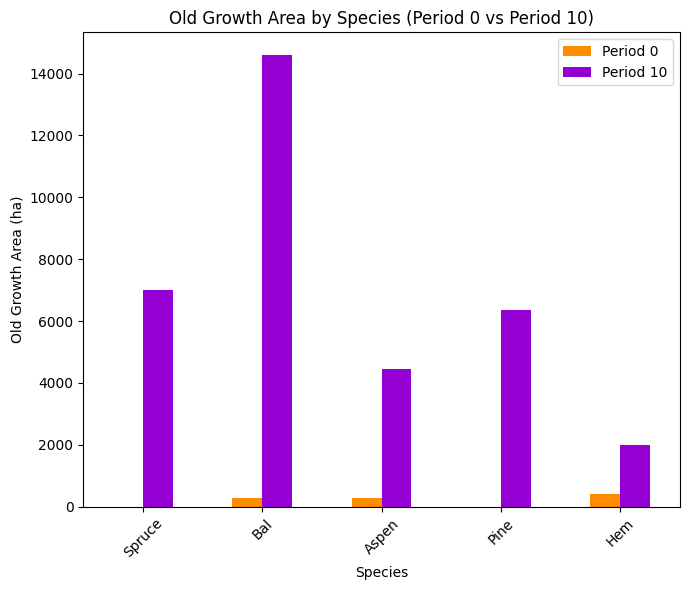

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_gldbr_AAC_50%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.9455
Shannon Evenness Index for time period 10: 0.8693

Diversity has **decreased** by 7.63% from time 0 to time 10.


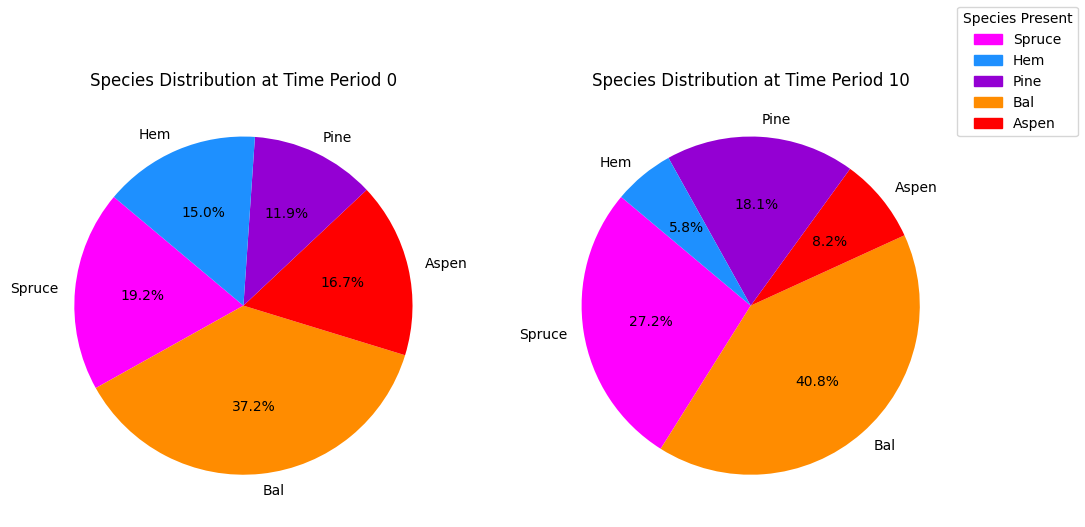

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_st_gldbr_AAC_50%_species_pie.pdf
running business as usual scenario for the Golden Bear mine site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0xf8fbe06d
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e+01, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 2031 columns
Presolve time: 0.15s
Presolved: 1911 rows, 34099 columns, 409165 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time

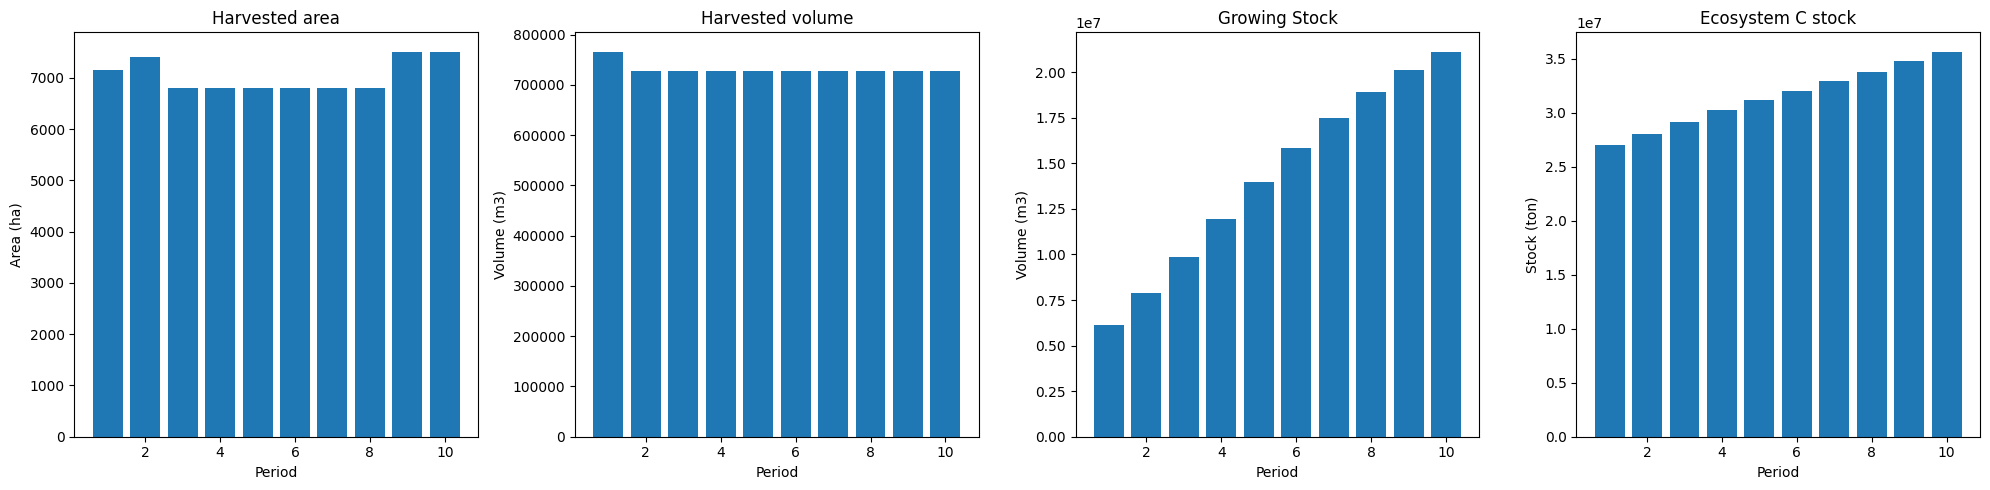

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_bau_gldbr_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  7734
The economic indicator (the provincial government revenues) is:  263762
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


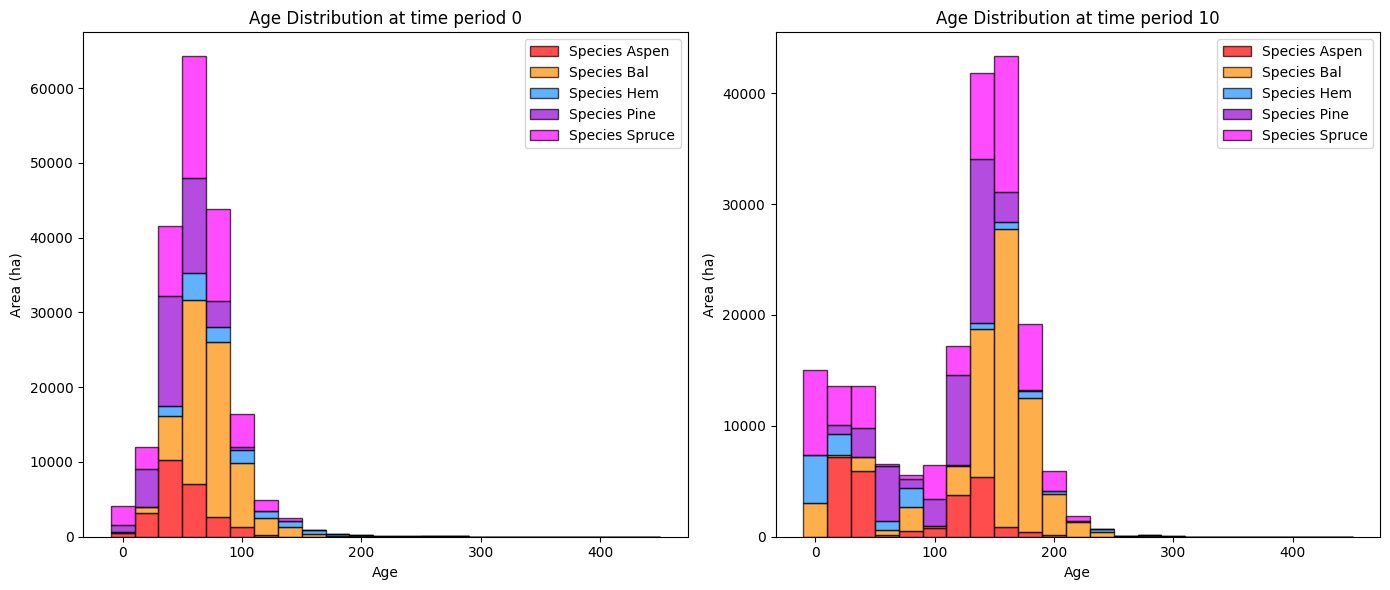

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_bau_gldbr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   4738.556382   4735.847848
Bal     278.565372  11823.627962  11545.062590
Aspen   273.490478   3610.557489   3337.067011
Pine      0.000000   3707.791886   3707.791886
Hem     419.699331    830.482584    410.783253

Old growth has **increased** by 23736.55 hectares from time period 0 to time period 10.


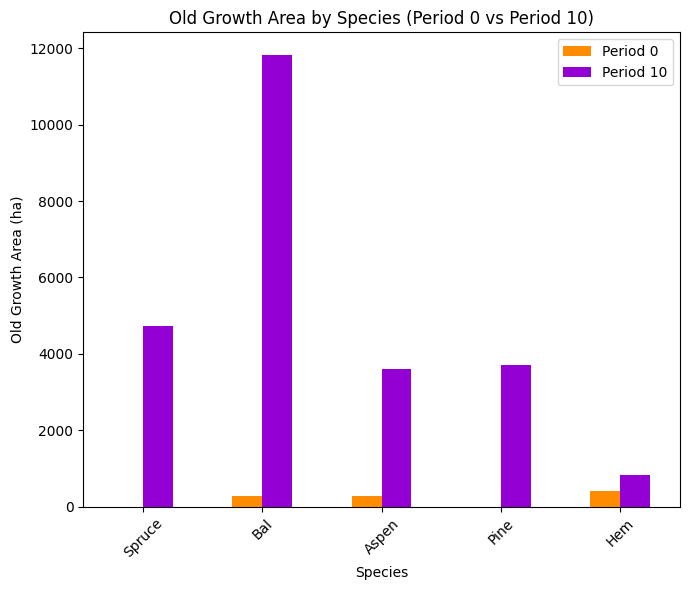

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_bau_gldbr_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.9455
Shannon Evenness Index for time period 10: 0.8181

Diversity has **decreased** by 12.74% from time 0 to time 10.


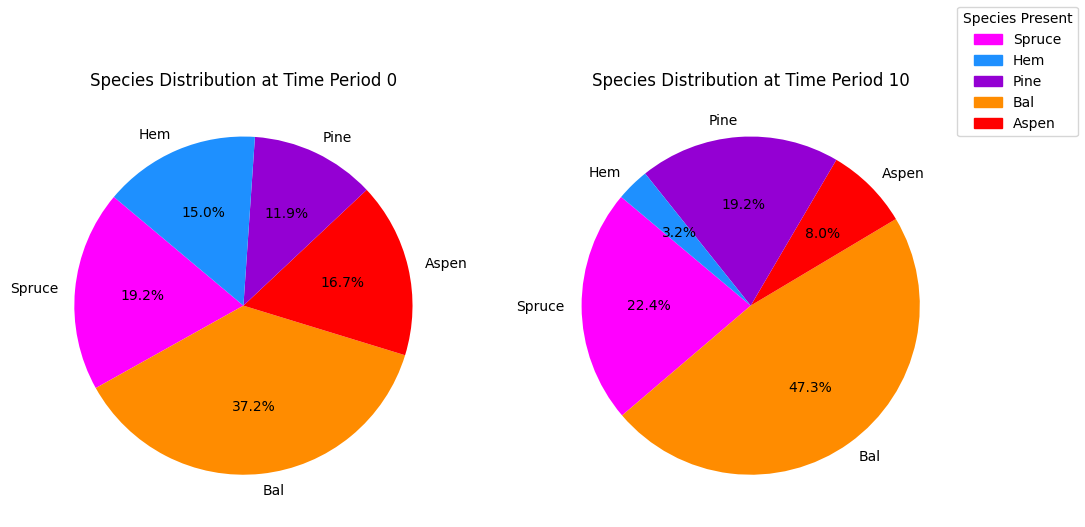

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_st_bau_gldbr_species_pie.pdf


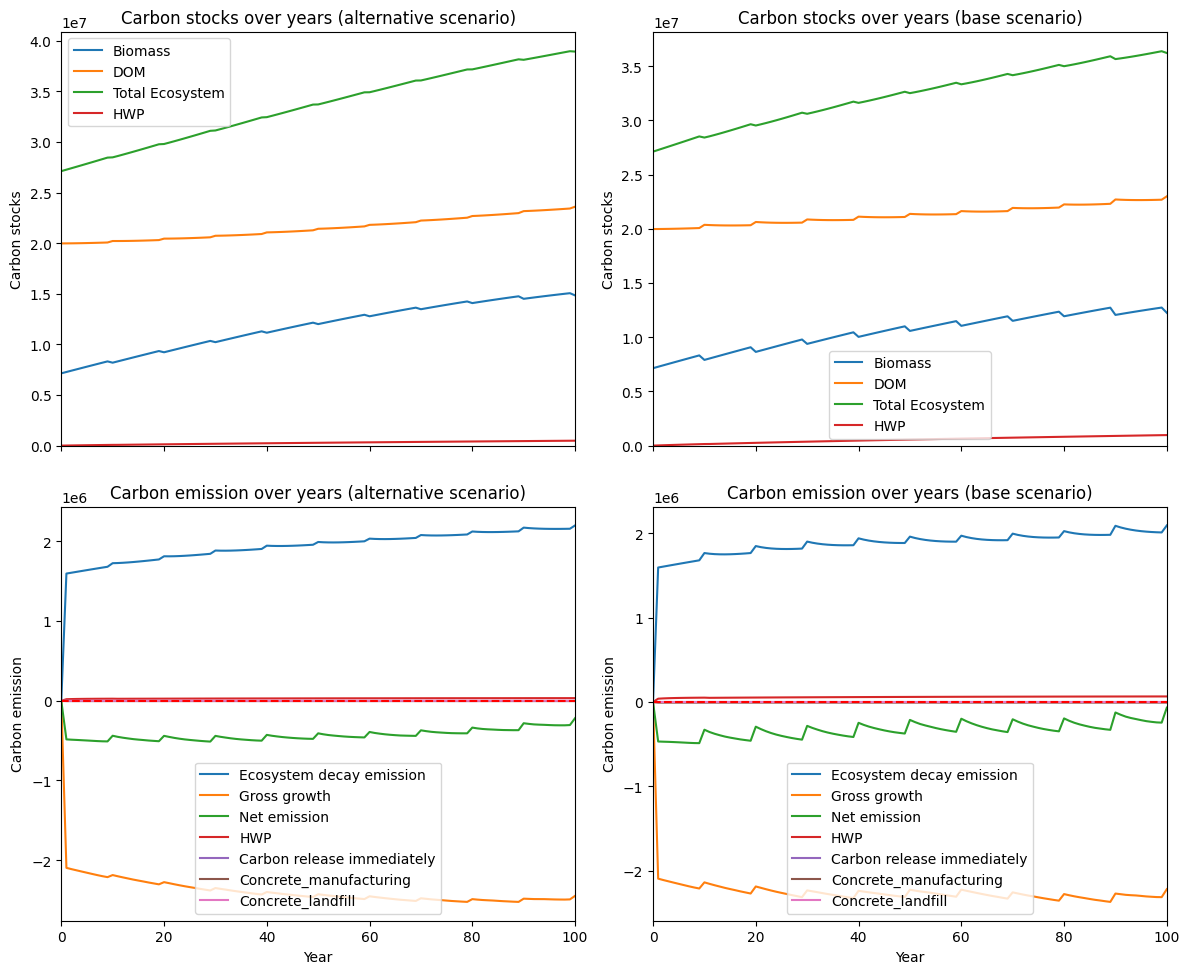

---------------------------------------------------------------------------------------
Net emission difference -10221195.144091737
Net emission base scenario -32702620.346034106
Net emission alternative scenario -42923815.490125835
dollar_per_ton is:  0.9783591702366042
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Spruce  0.0  2254.989655  2254.989655
Bal     0.0  2778.576646  2778.576646
Aspen   0.0   834.123977   834.123977
Pine    0.0  2645.210629  2645.210629
Hem     0.0  1153.413807  1153.413807

Overall, the old growth area has **increased** by 9666.31 hectares in the alternative scenario compared to the base scenario.


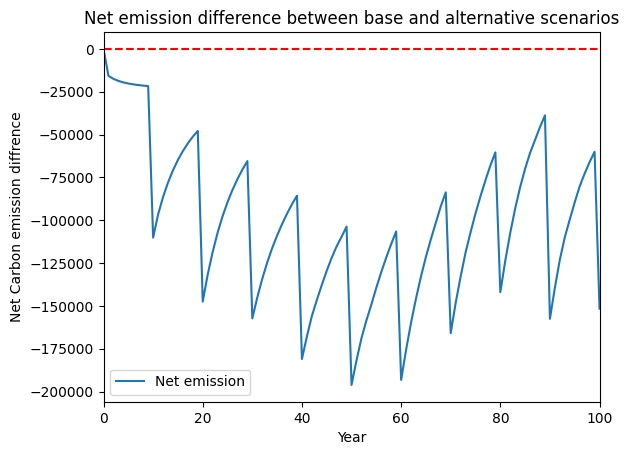

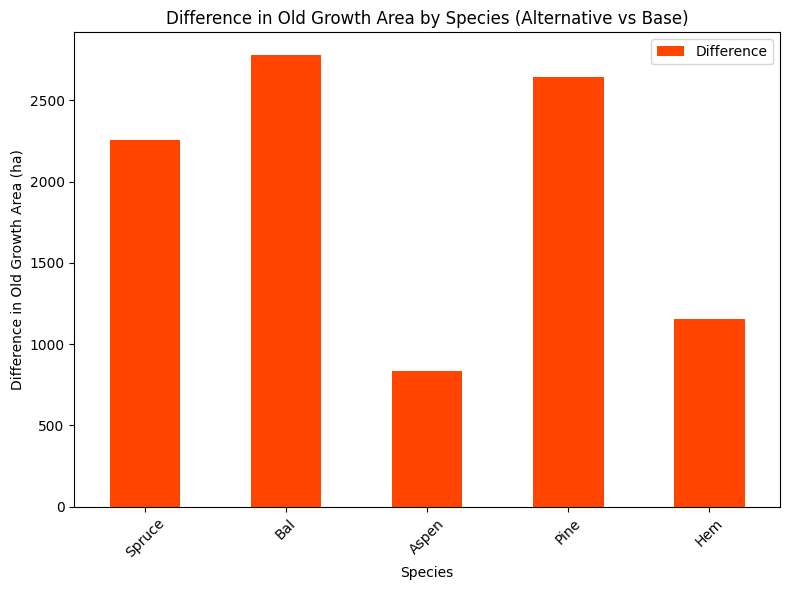

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_kpi_age_difference.pdf


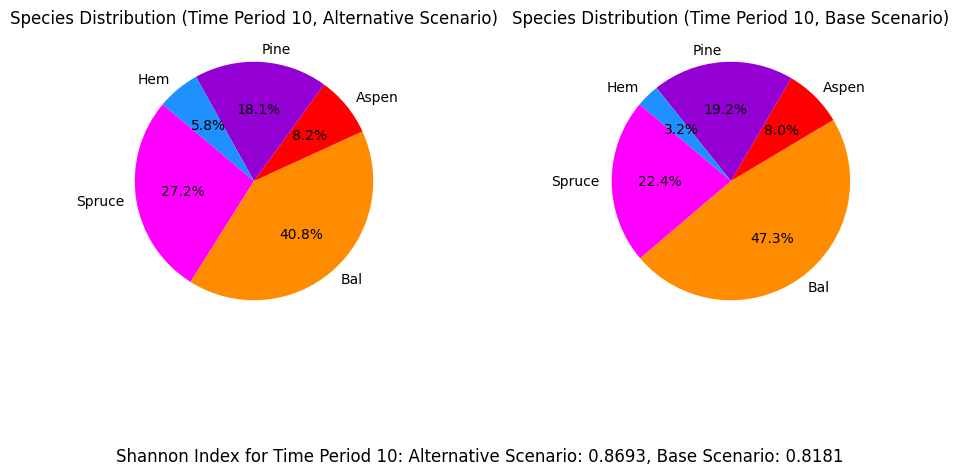

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_st_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for goldenbear_max_st_gldbr_AAC_40%...
running the scenario for the Golden Bear mining site (40%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0xd9f75c7b
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e+01, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 2031 columns
Presolve time: 0.13s
Presolved: 1911 rows, 34100 

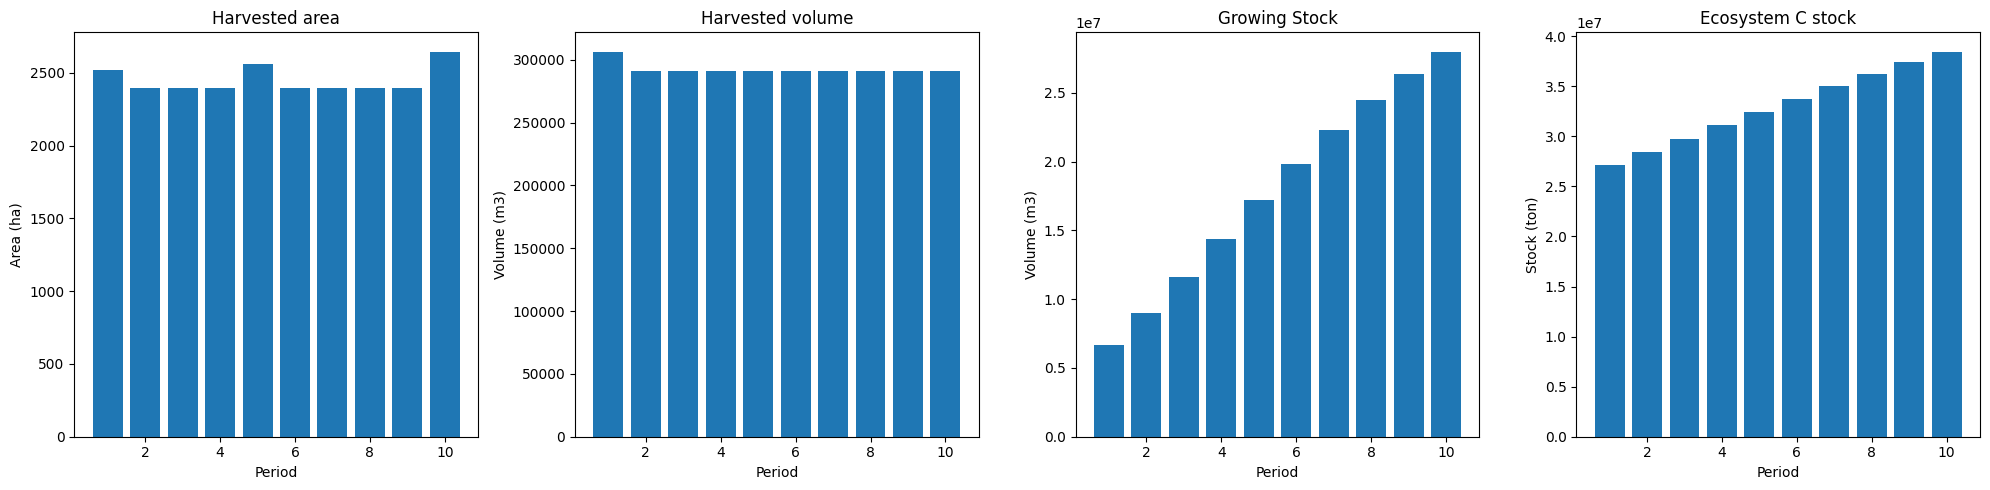

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_gldbr_AAC_40%_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  3093
The economic indicator (the provincial government revenues) is:  105504
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


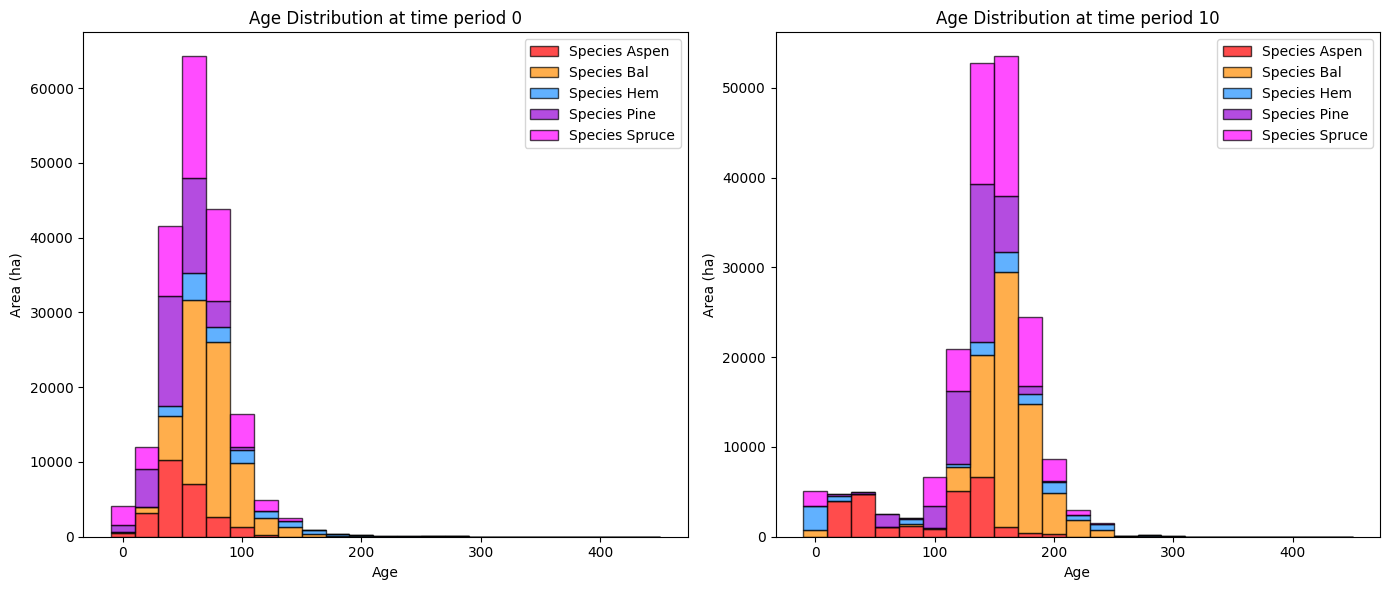

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_gldbr_AAC_40%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   7558.632920   7555.924387
Bal     278.565372  15078.173381  14799.608009
Aspen   273.490478   4745.782118   4472.291640
Pine      0.000000   6857.343919   6857.343919
Hem     419.699331   2472.635184   2052.935853

Old growth has **increased** by 35738.10 hectares from time period 0 to time period 10.


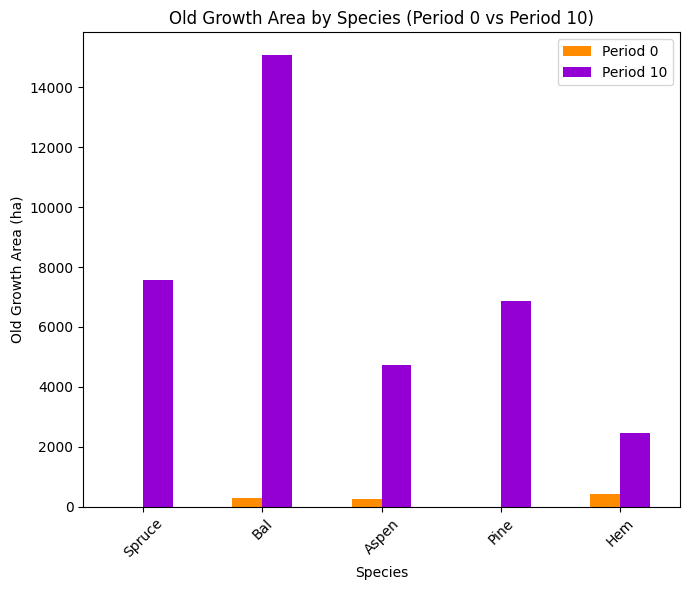

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_gldbr_AAC_40%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.9455
Shannon Evenness Index for time period 10: 0.8780

Diversity has **decreased** by 6.76% from time 0 to time 10.


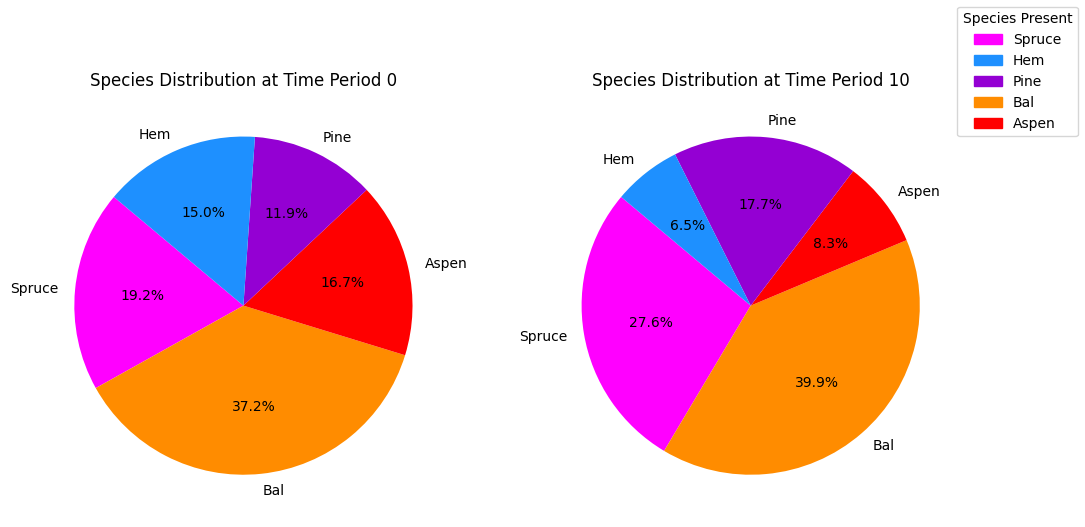

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_st_gldbr_AAC_40%_species_pie.pdf
running business as usual scenario for the Golden Bear mine site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0xf8fbe06d
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e+01, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 2031 columns
Presolve time: 0.13s
Presolved: 1911 rows, 34099 columns, 409165 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time

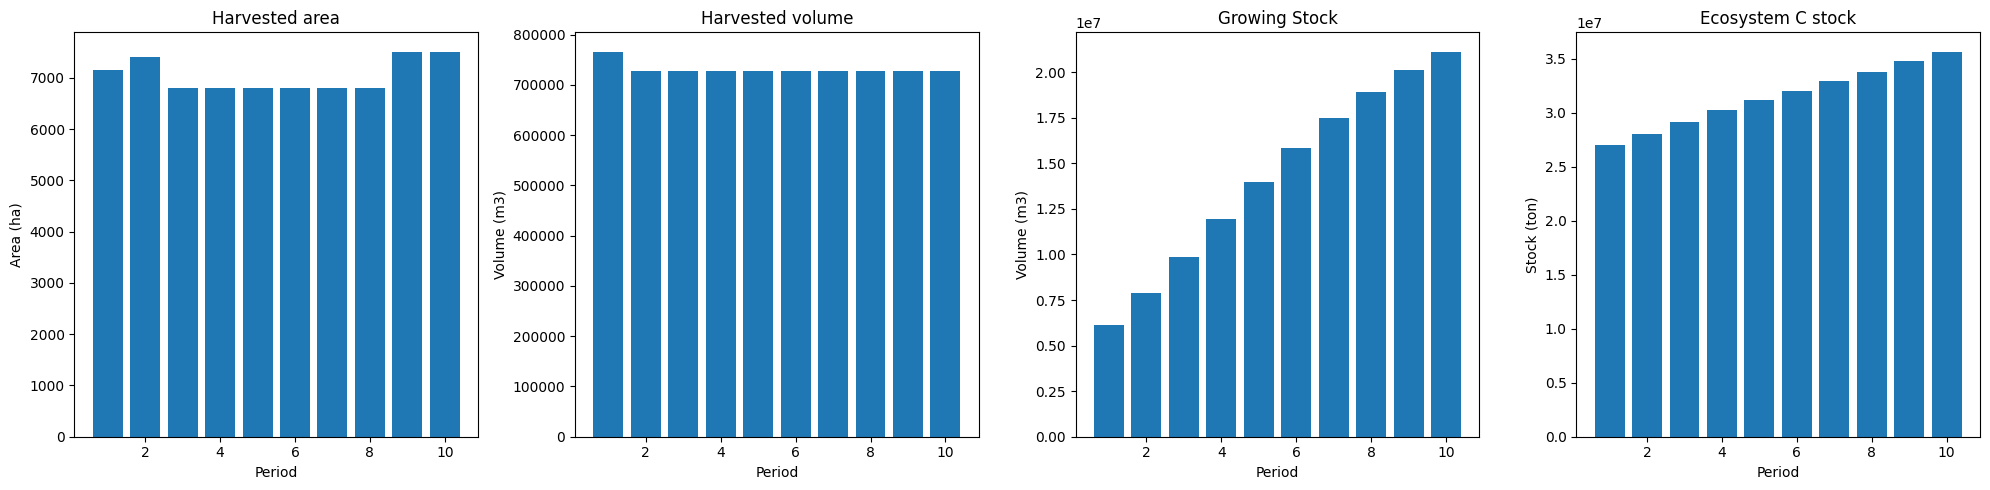

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_bau_gldbr_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  7734
The economic indicator (the provincial government revenues) is:  263762
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


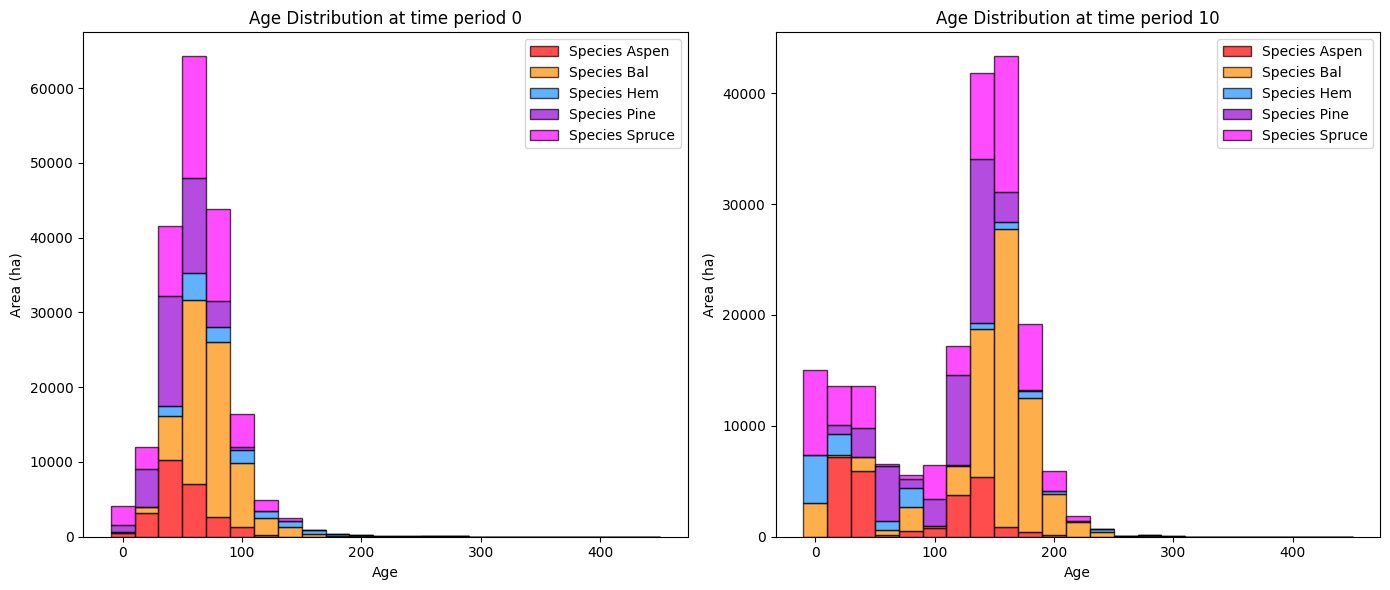

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_bau_gldbr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   4738.556382   4735.847848
Bal     278.565372  11823.627962  11545.062590
Aspen   273.490478   3610.557489   3337.067011
Pine      0.000000   3707.791886   3707.791886
Hem     419.699331    830.482584    410.783253

Old growth has **increased** by 23736.55 hectares from time period 0 to time period 10.


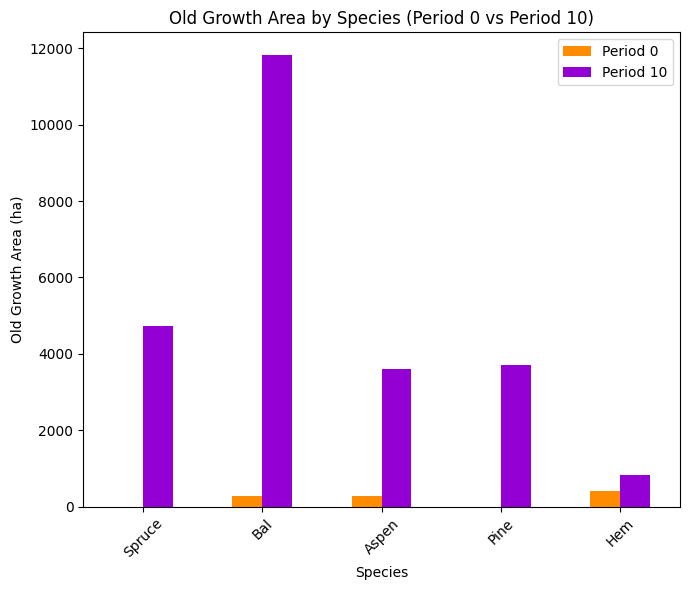

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_bau_gldbr_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.9455
Shannon Evenness Index for time period 10: 0.8181

Diversity has **decreased** by 12.74% from time 0 to time 10.


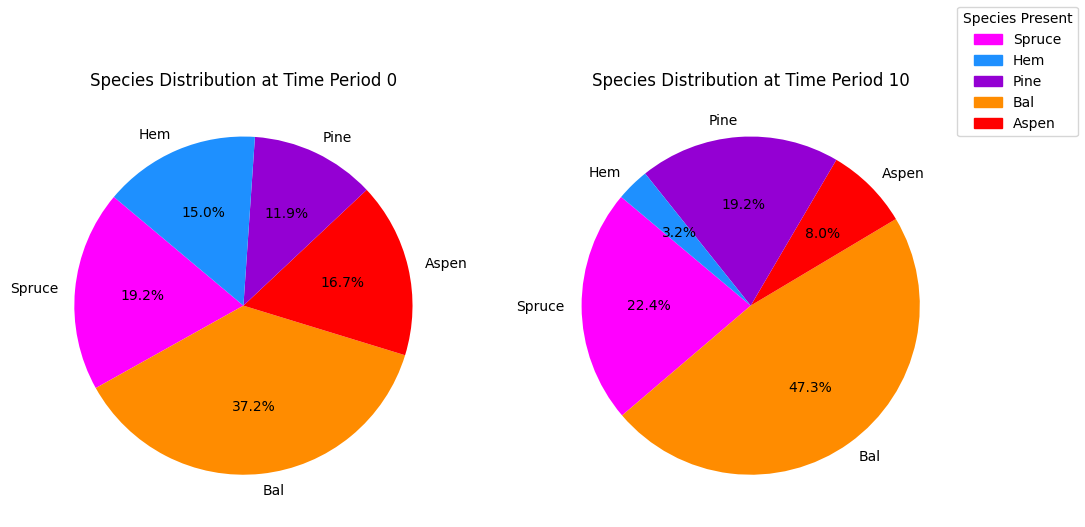

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_st_bau_gldbr_species_pie.pdf


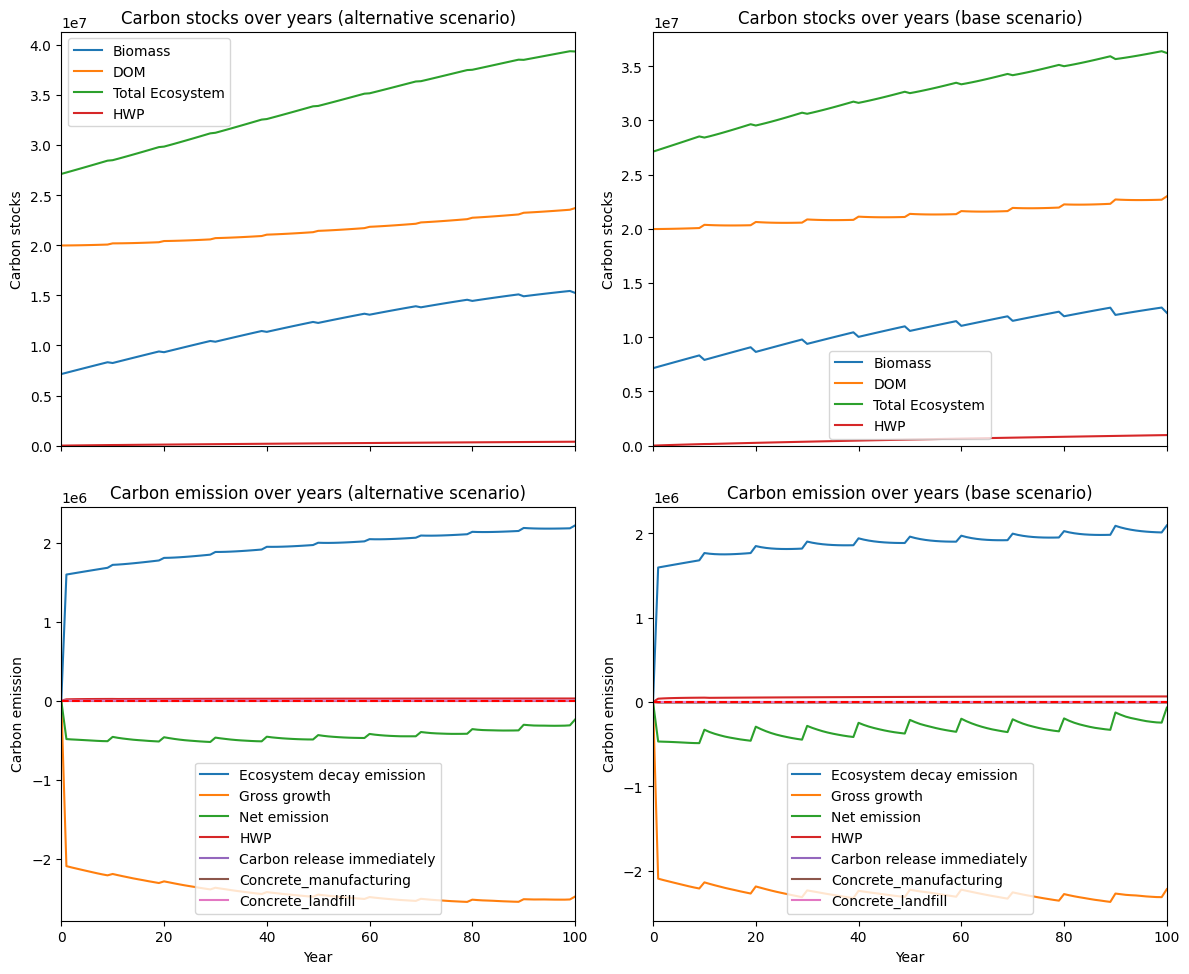

---------------------------------------------------------------------------------------
Net emission difference -11895866.558447696
Net emission base scenario -32702620.346034106
Net emission alternative scenario -44598486.904481806
dollar_per_ton is:  0.840628124976623
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Spruce  0.0  2820.076538  2820.076538
Bal     0.0  3254.545419  3254.545419
Aspen   0.0  1135.224629  1135.224629
Pine    0.0  3149.552033  3149.552033
Hem     0.0  1642.152600  1642.152600

Overall, the old growth area has **increased** by 12001.55 hectares in the alternative scenario compared to the base scenario.


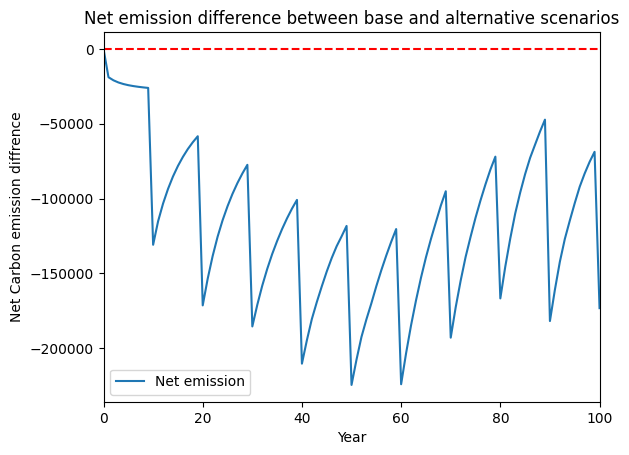

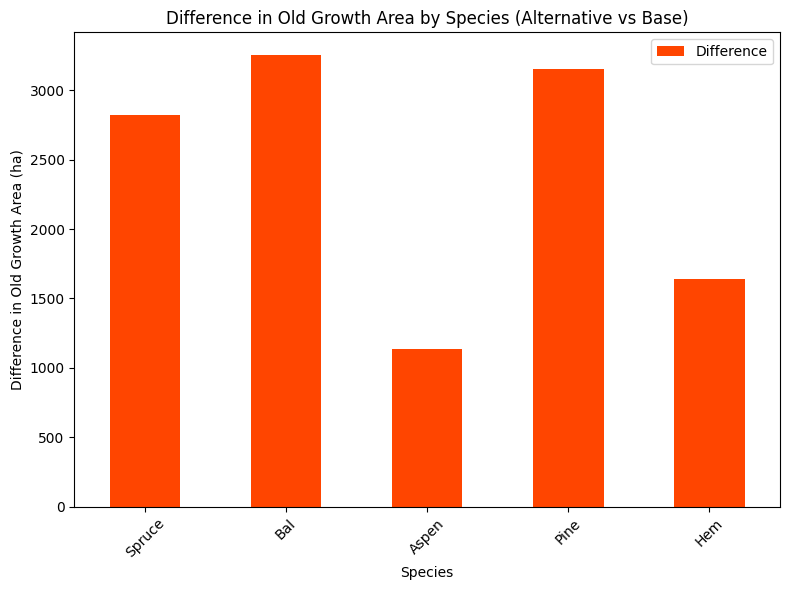

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_kpi_age_difference.pdf


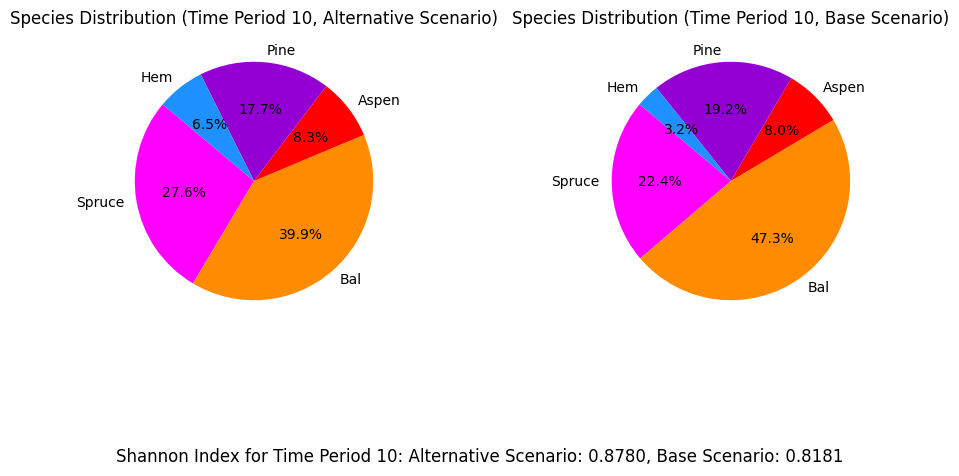

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_st_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for goldenbear_max_st_gldbr_AAC_30%...
running the scenario for the Golden Bear mining site (30%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0x1a4288f1
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e+01, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 2031 columns
Presolve time: 0.13s
Presolved: 1911 rows, 34100 

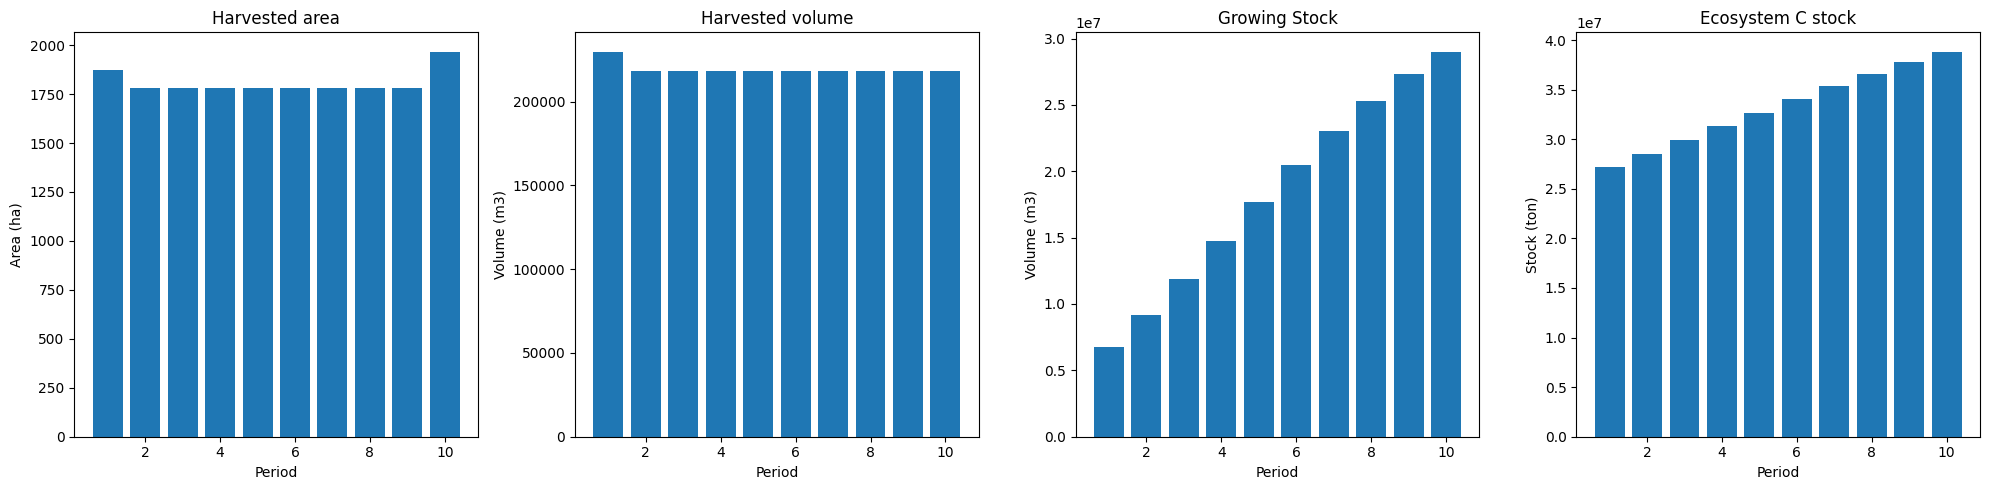

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_gldbr_AAC_30%_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  2320
The economic indicator (the provincial government revenues) is:  79128
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


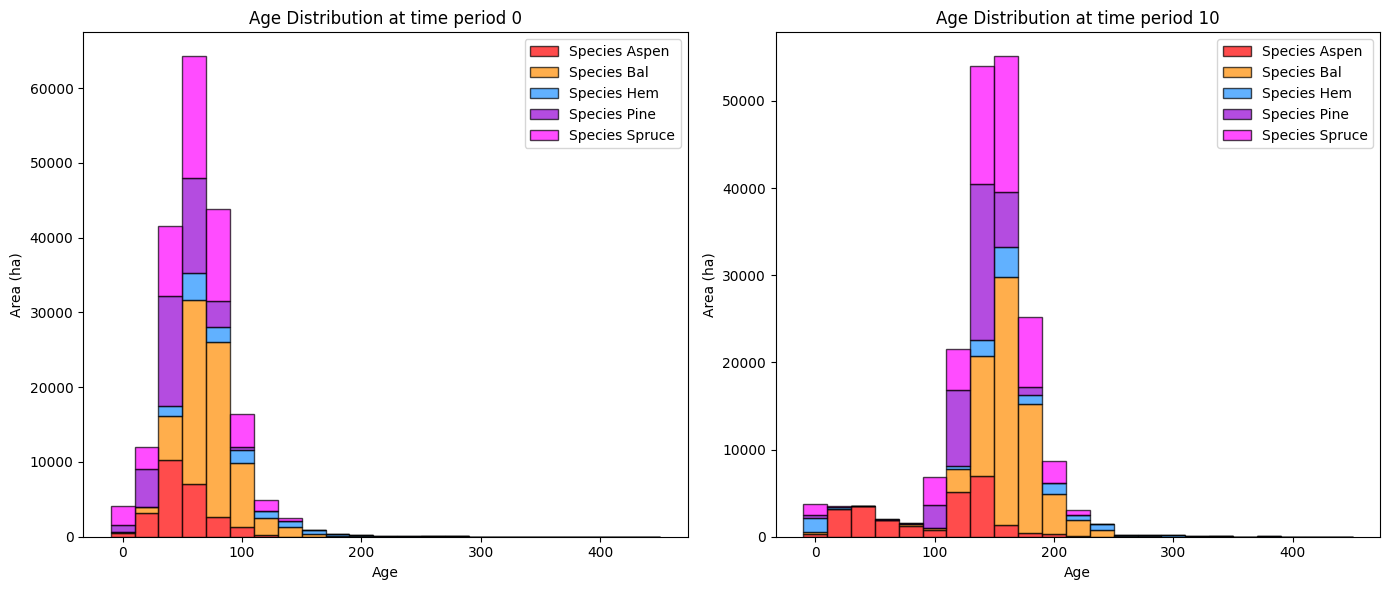

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_gldbr_AAC_30%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   7847.625400   7844.916867
Bal     278.565372  15587.059358  15308.493987
Aspen   273.490478   5313.367827   5039.877349
Pine      0.000000   7134.398603   7134.398603
Hem     419.699331   3087.721970   2668.022639

Old growth has **increased** by 37995.71 hectares from time period 0 to time period 10.


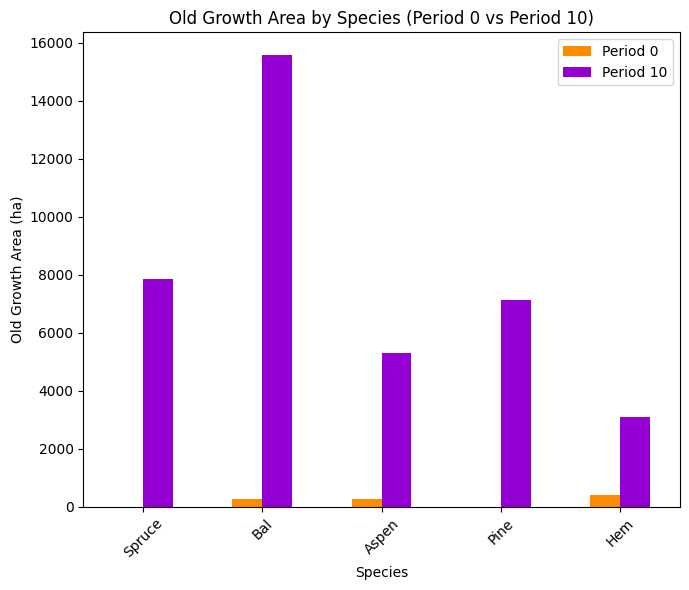

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_gldbr_AAC_30%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.9455
Shannon Evenness Index for time period 10: 0.8963

Diversity has **decreased** by 4.92% from time 0 to time 10.


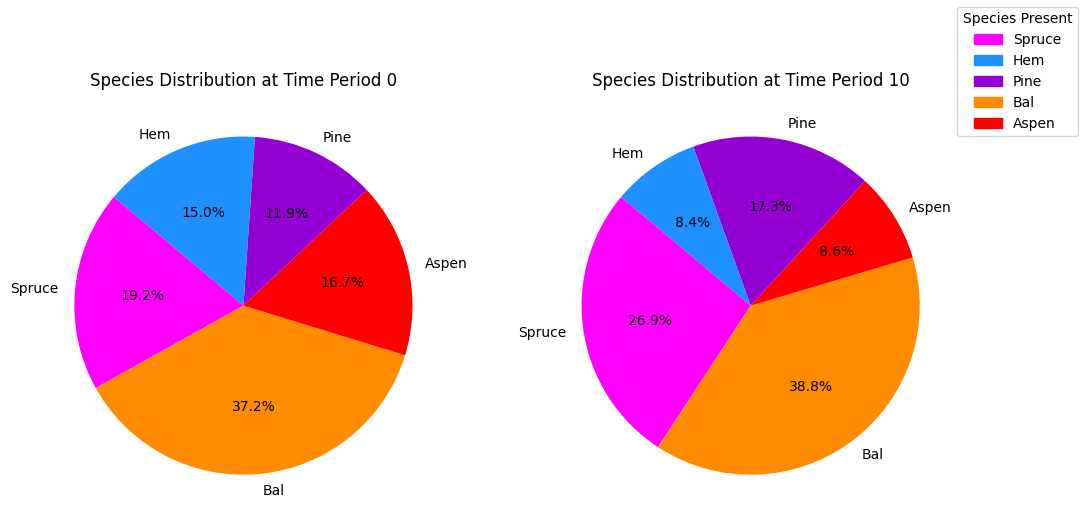

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_st_gldbr_AAC_30%_species_pie.pdf
running business as usual scenario for the Golden Bear mine site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0xf8fbe06d
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e+01, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 2031 columns
Presolve time: 0.15s
Presolved: 1911 rows, 34099 columns, 409165 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time

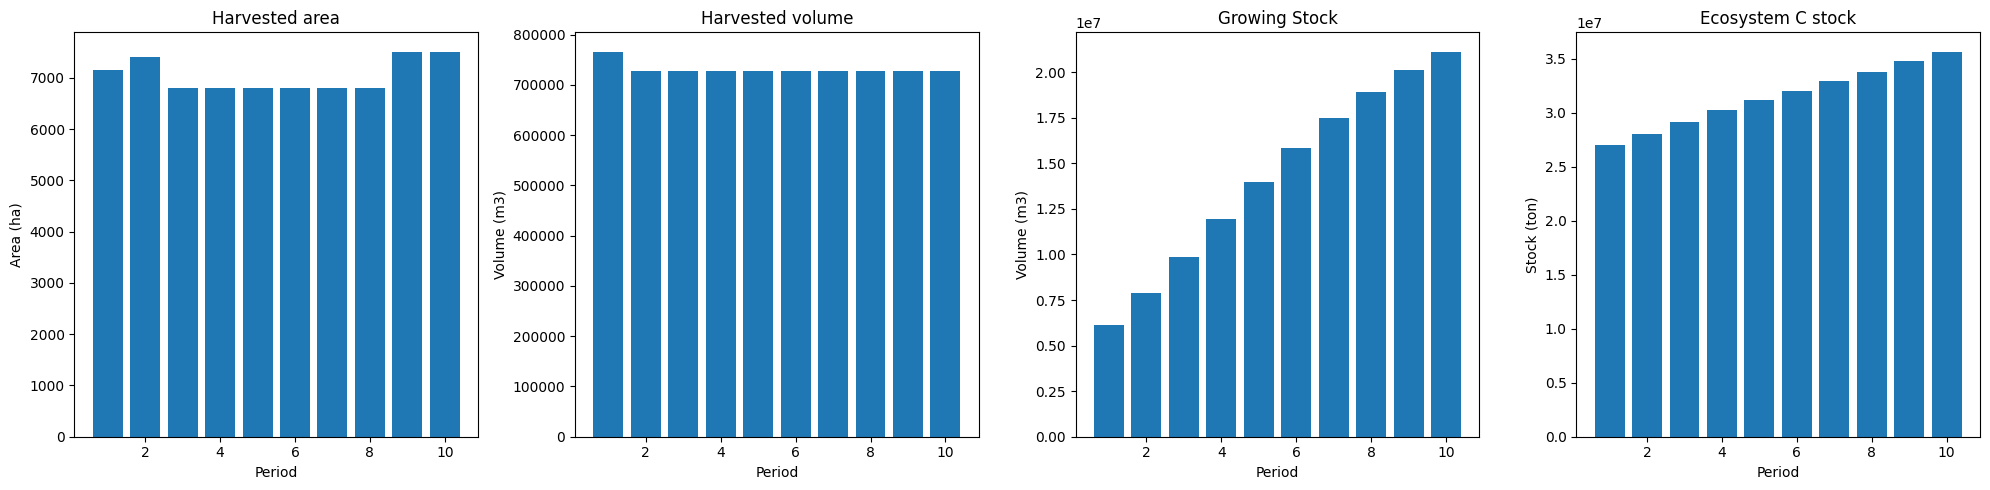

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_bau_gldbr_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  7734
The economic indicator (the provincial government revenues) is:  263762
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


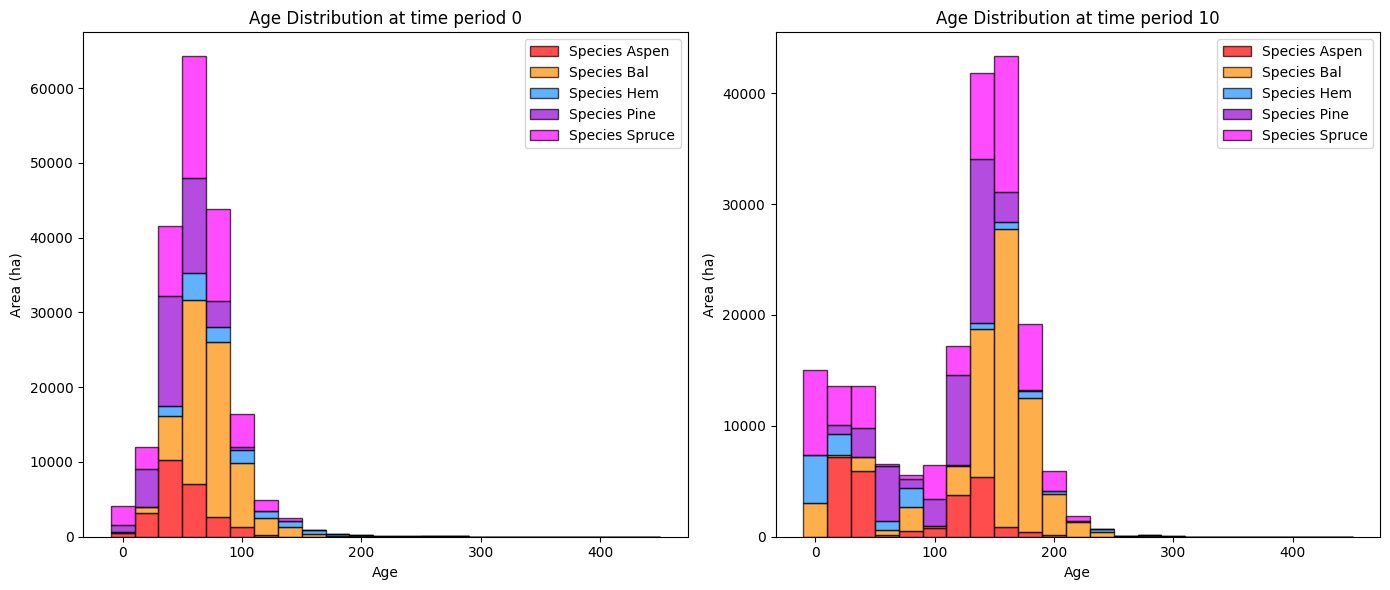

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_bau_gldbr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   4738.556382   4735.847848
Bal     278.565372  11823.627962  11545.062590
Aspen   273.490478   3610.557489   3337.067011
Pine      0.000000   3707.791886   3707.791886
Hem     419.699331    830.482584    410.783253

Old growth has **increased** by 23736.55 hectares from time period 0 to time period 10.


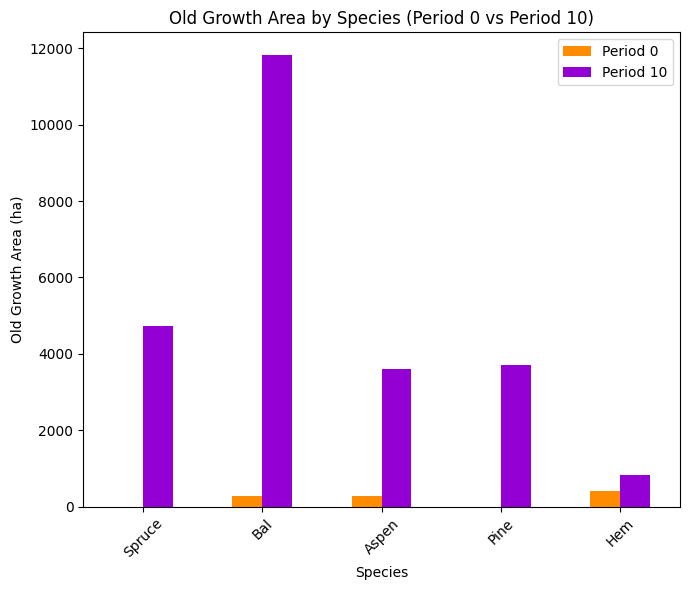

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_bau_gldbr_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.9455
Shannon Evenness Index for time period 10: 0.8181

Diversity has **decreased** by 12.74% from time 0 to time 10.


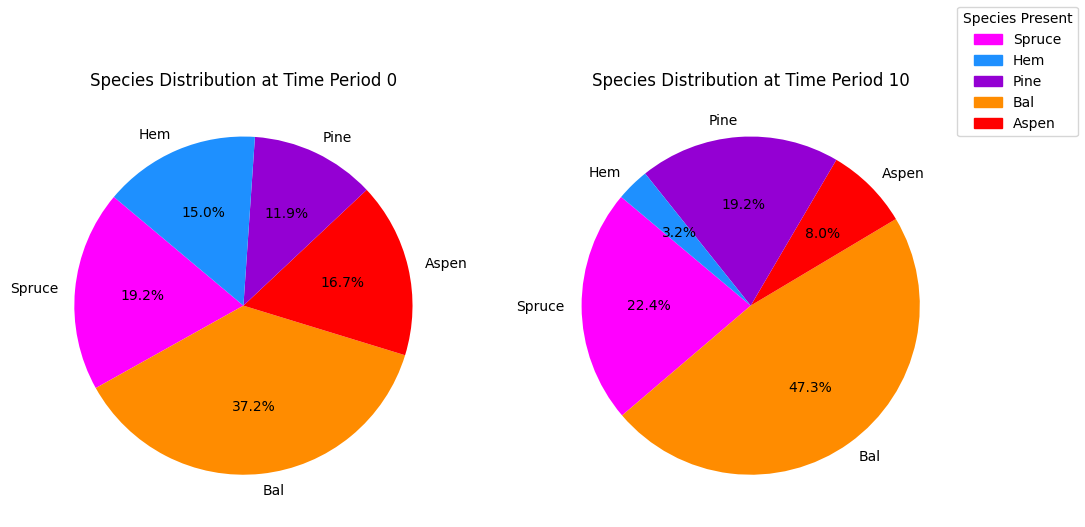

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_st_bau_gldbr_species_pie.pdf


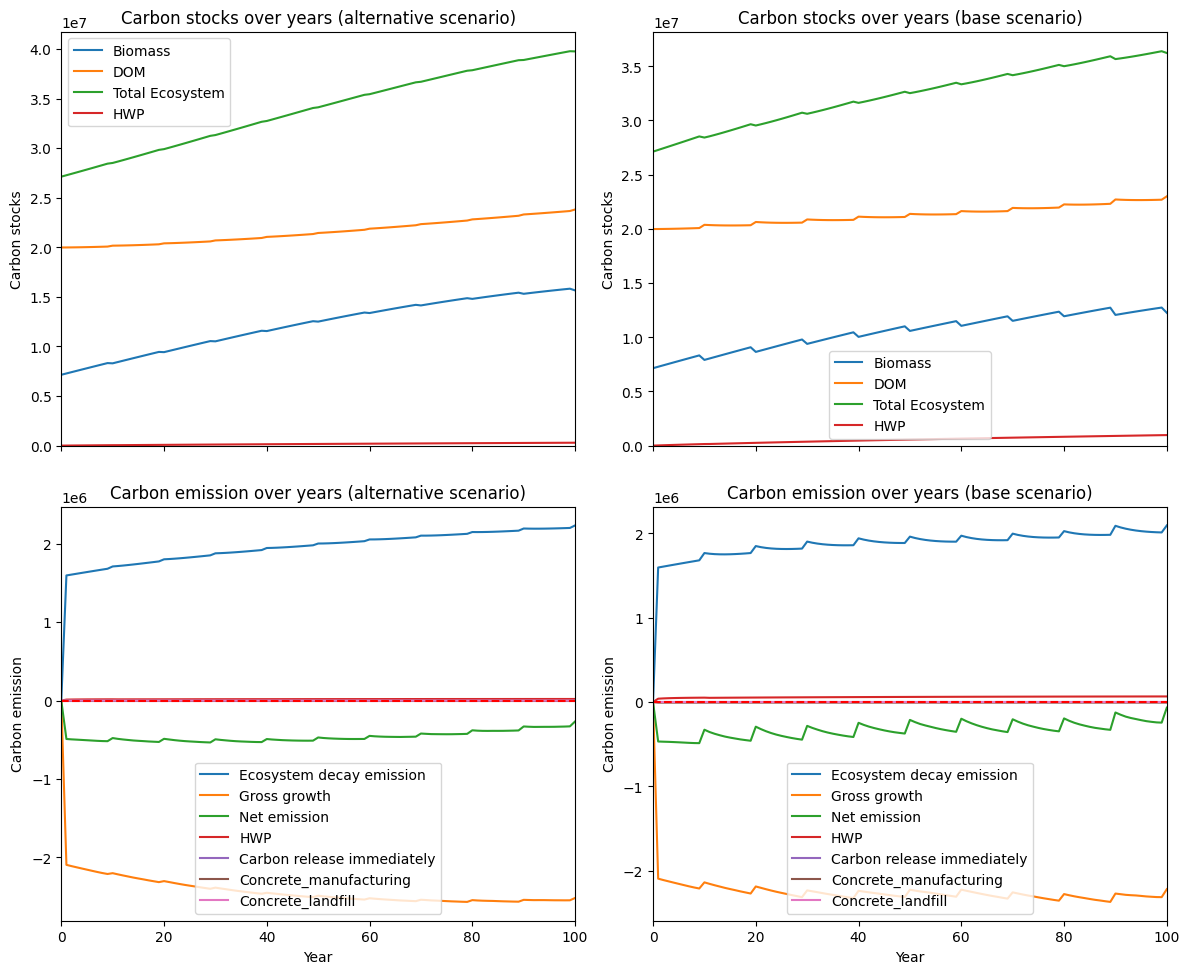

---------------------------------------------------------------------------------------
Net emission difference -13522986.915508194
Net emission base scenario -32702620.346034106
Net emission alternative scenario -46225607.2615423
dollar_per_ton is:  0.7394815999216842
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Spruce  0.0  3109.069018  3109.069018
Bal     0.0  3763.431396  3763.431396
Aspen   0.0  1702.810338  1702.810338
Pine    0.0  3426.606717  3426.606717
Hem     0.0  2257.239386  2257.239386

Overall, the old growth area has **increased** by 14259.16 hectares in the alternative scenario compared to the base scenario.


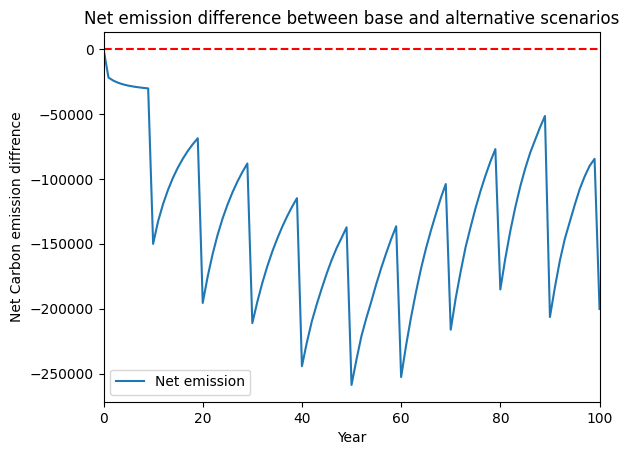

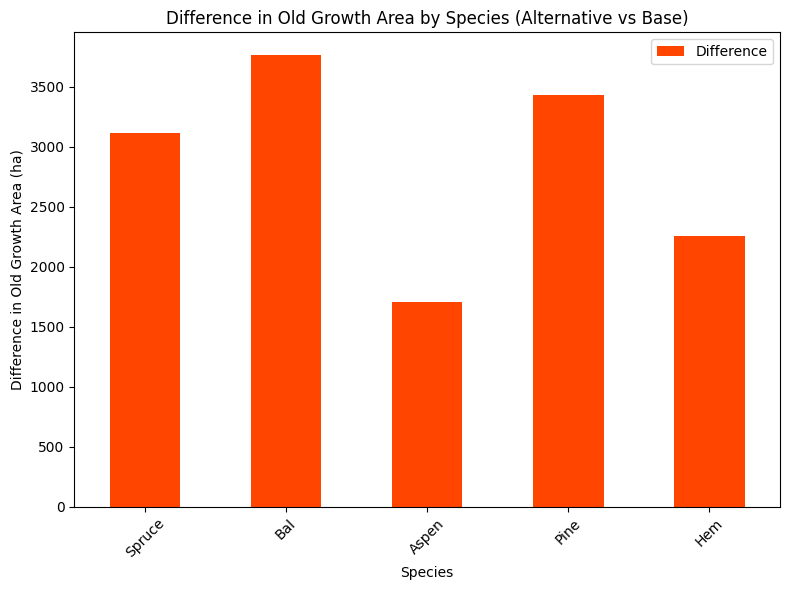

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_kpi_age_difference.pdf


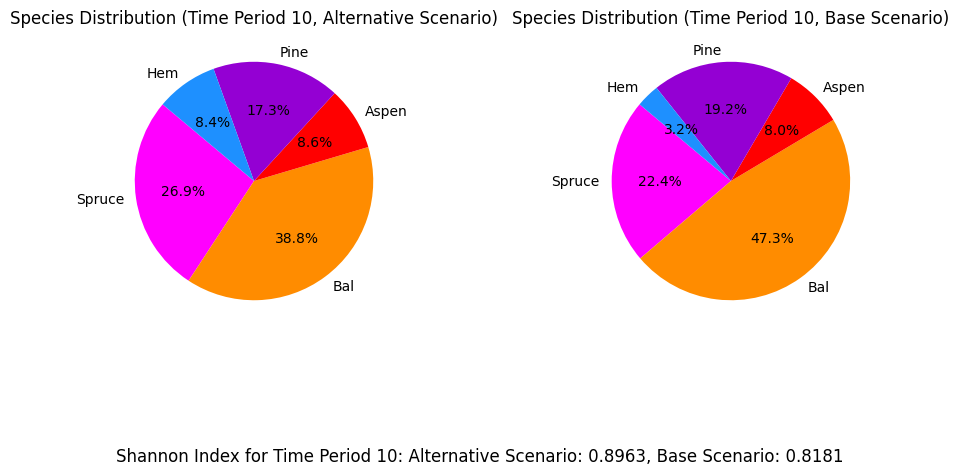

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_st_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for goldenbear_max_st_gldbr_AAC_20%...
running the scenario for the Golden Bear mining site (20%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0x057a4737
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e+01, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 2031 columns
Presolve time: 0.14s
Presolved: 1911 rows, 34100 

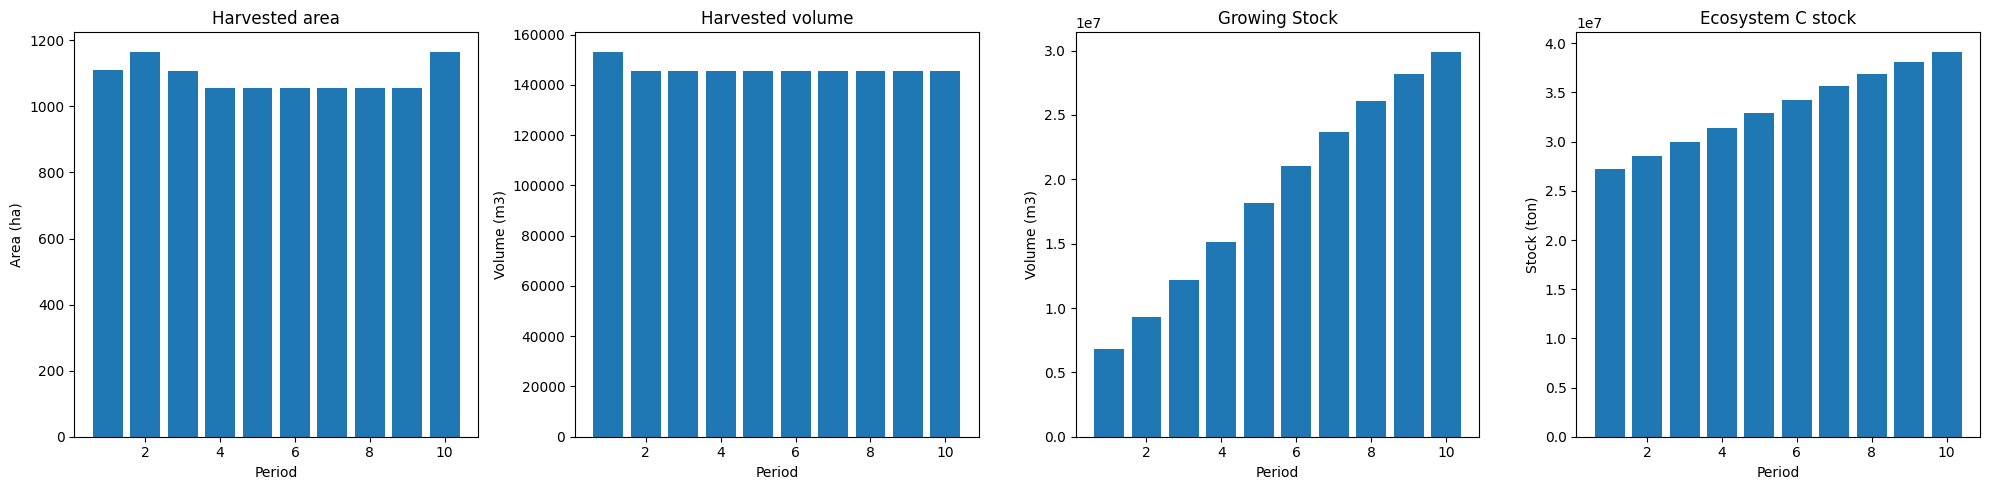

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_gldbr_AAC_20%_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  1546
The economic indicator (the provincial government revenues) is:  52752
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


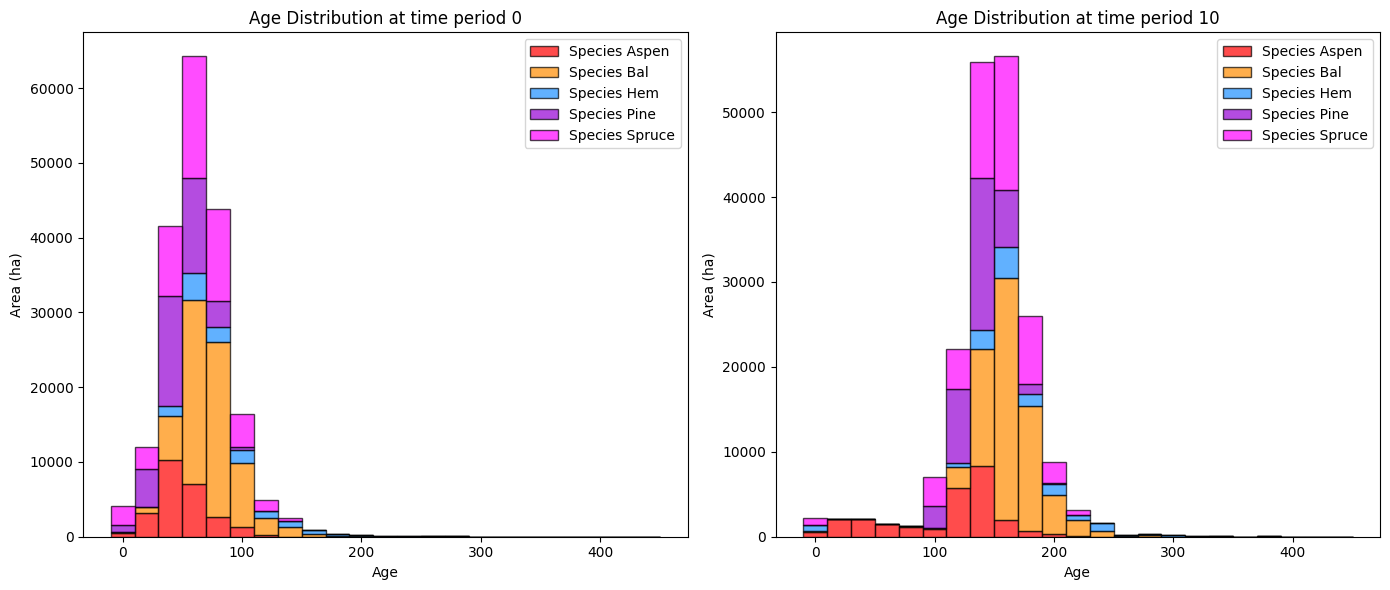

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_gldbr_AAC_20%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   7984.459080   7981.750547
Bal     278.565372  15792.753043  15514.187671
Aspen   273.490478   7097.019978   6823.529500
Pine      0.000000   7631.887200   7631.887200
Hem     419.699331   3523.889083   3104.189752

Old growth has **increased** by 41055.54 hectares from time period 0 to time period 10.


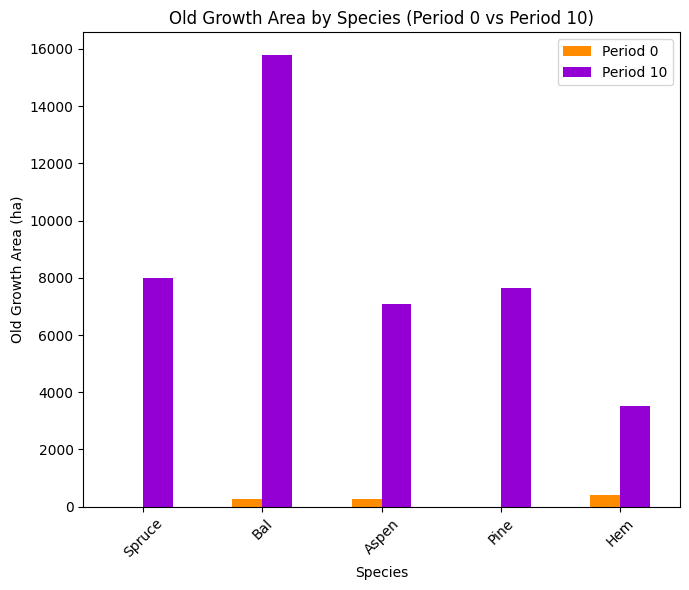

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_gldbr_AAC_20%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.9455
Shannon Evenness Index for time period 10: 0.9092

Diversity has **decreased** by 3.64% from time 0 to time 10.


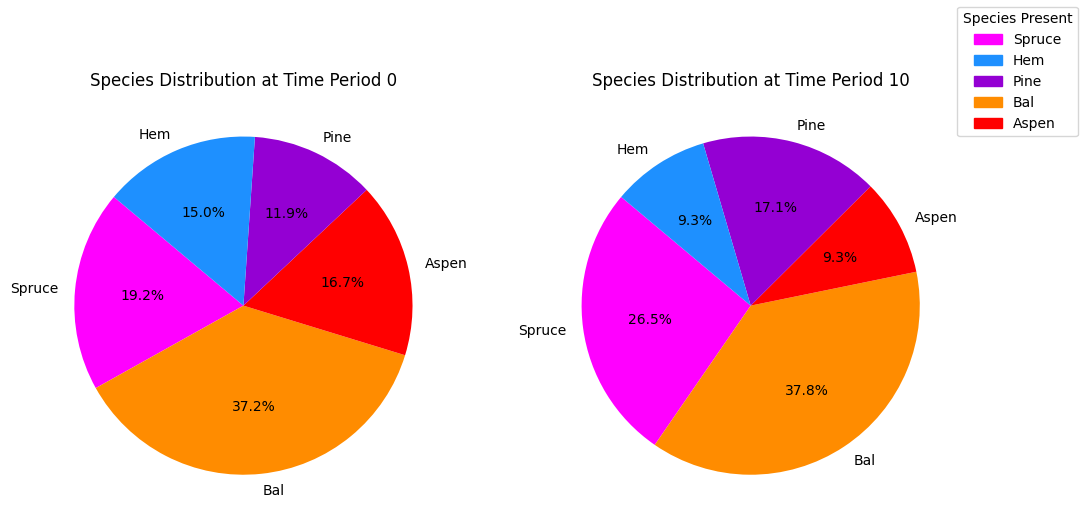

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_st_gldbr_AAC_20%_species_pie.pdf
running business as usual scenario for the Golden Bear mine site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0xf8fbe06d
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e+01, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 2031 columns
Presolve time: 0.15s
Presolved: 1911 rows, 34099 columns, 409165 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time

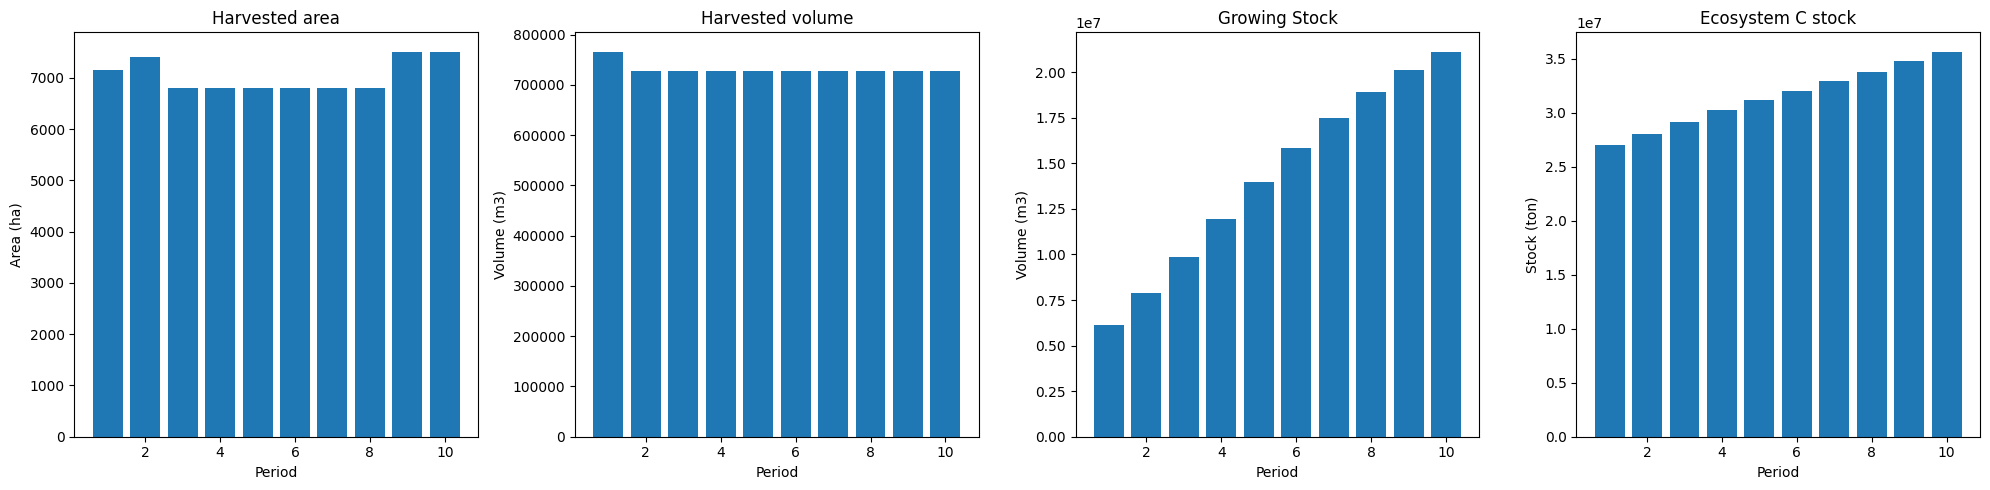

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_bau_gldbr_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  7734
The economic indicator (the provincial government revenues) is:  263762
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


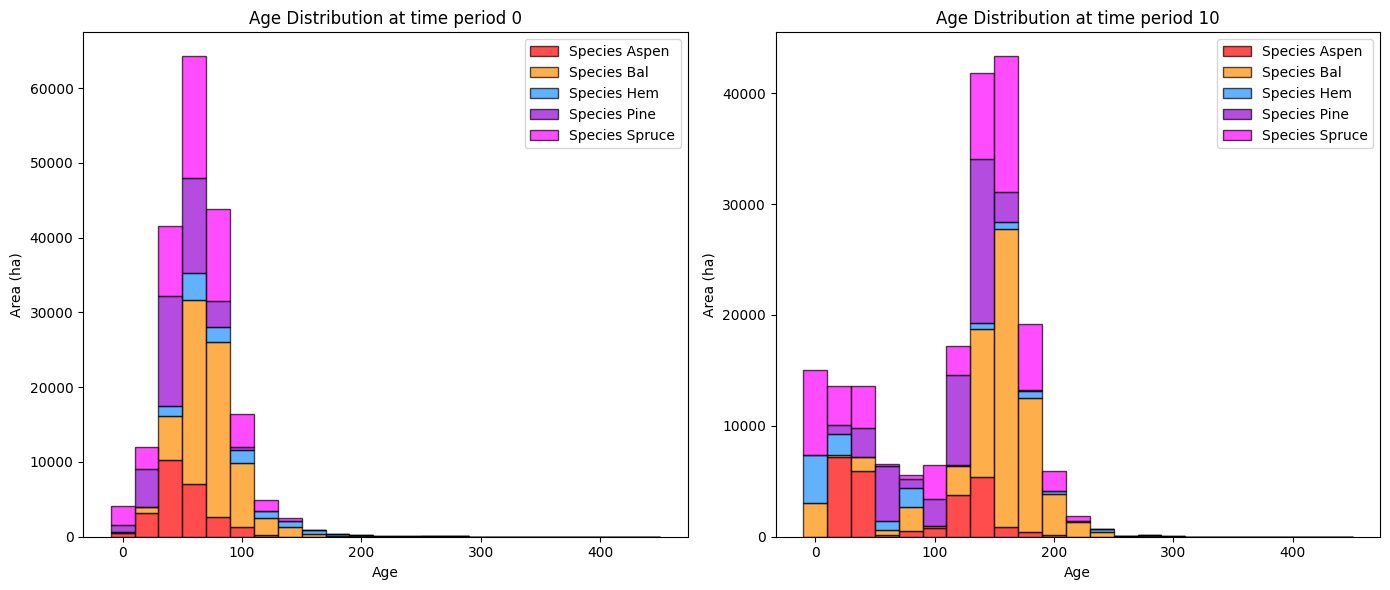

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_bau_gldbr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   4738.556382   4735.847848
Bal     278.565372  11823.627962  11545.062590
Aspen   273.490478   3610.557489   3337.067011
Pine      0.000000   3707.791886   3707.791886
Hem     419.699331    830.482584    410.783253

Old growth has **increased** by 23736.55 hectares from time period 0 to time period 10.


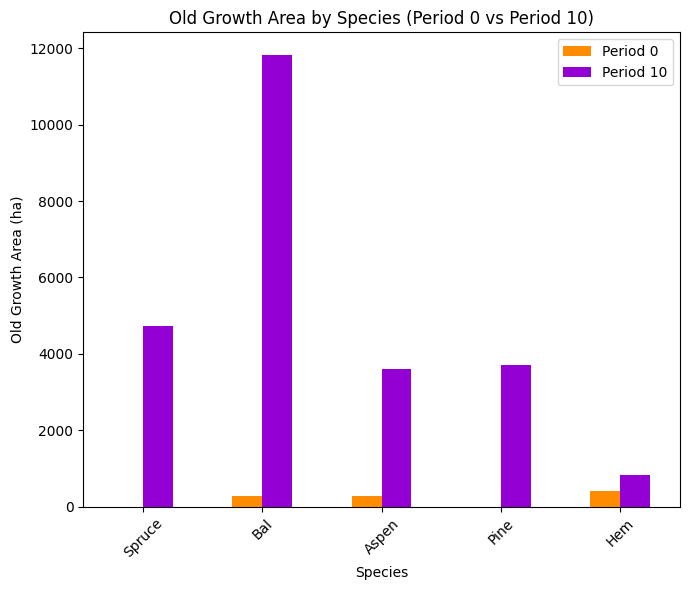

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_bau_gldbr_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.9455
Shannon Evenness Index for time period 10: 0.8181

Diversity has **decreased** by 12.74% from time 0 to time 10.


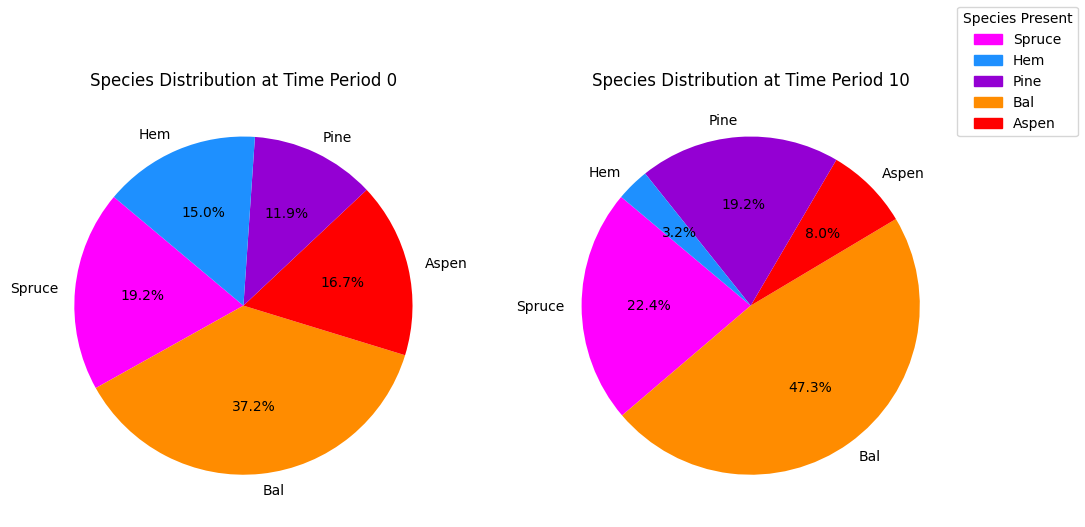

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_st_bau_gldbr_species_pie.pdf


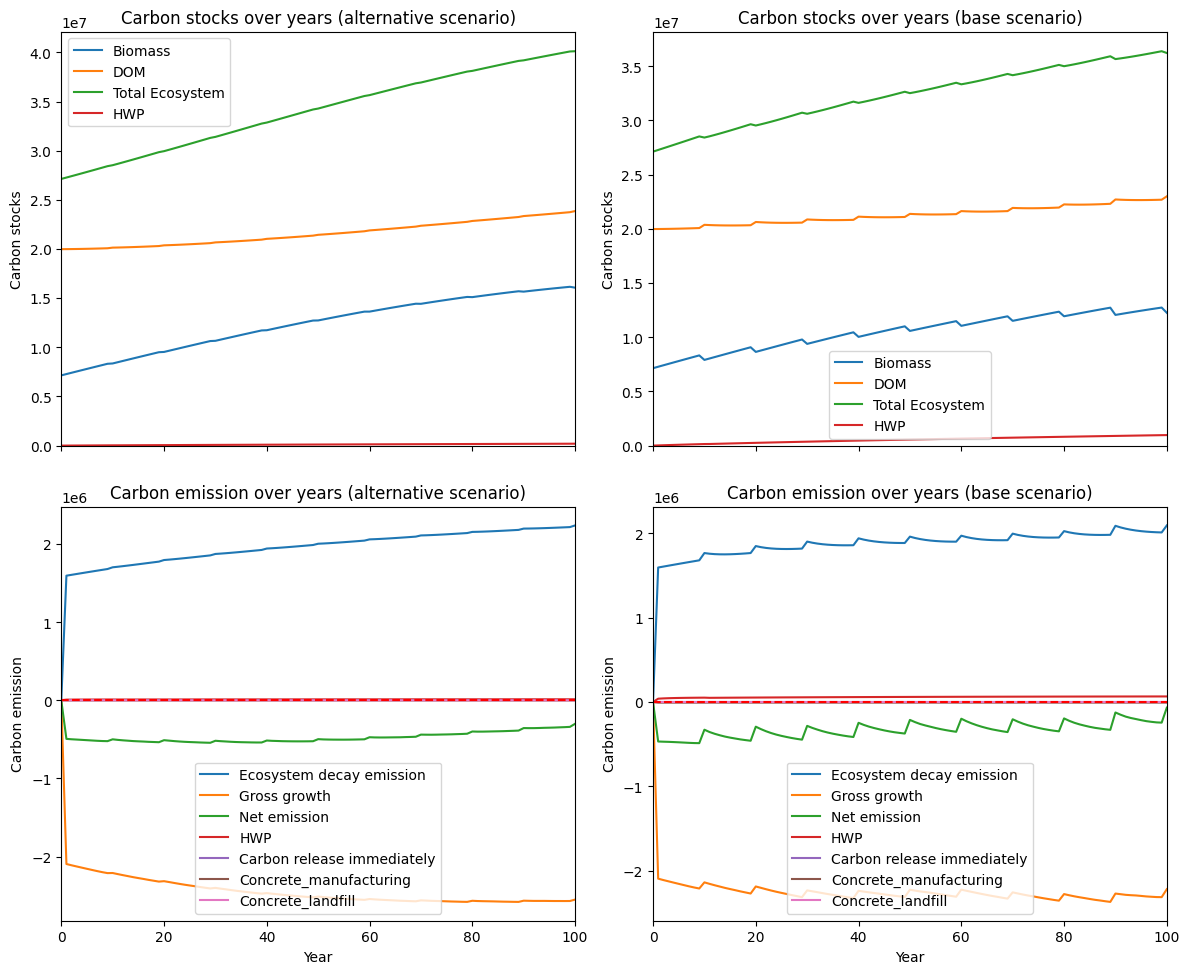

---------------------------------------------------------------------------------------
Net emission difference -14837055.770277277
Net emission base scenario -32702620.346034106
Net emission alternative scenario -47539676.116311386
dollar_per_ton is:  0.673988165497953
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Spruce  0.0  3245.902698  3245.902698
Bal     0.0  3969.125081  3969.125081
Aspen   0.0  3486.462489  3486.462489
Pine    0.0  3924.095315  3924.095315
Hem     0.0  2693.406499  2693.406499

Overall, the old growth area has **increased** by 17318.99 hectares in the alternative scenario compared to the base scenario.


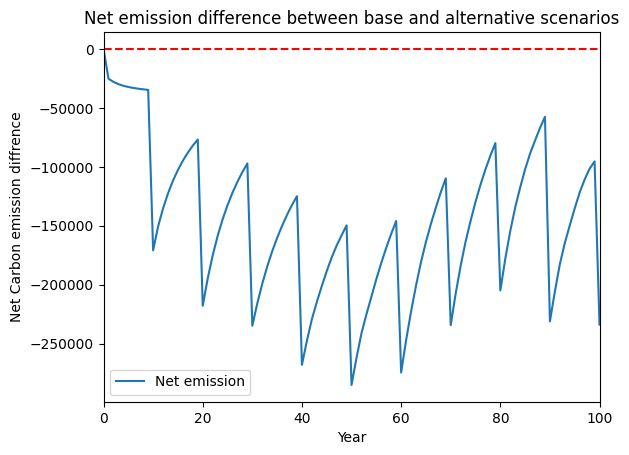

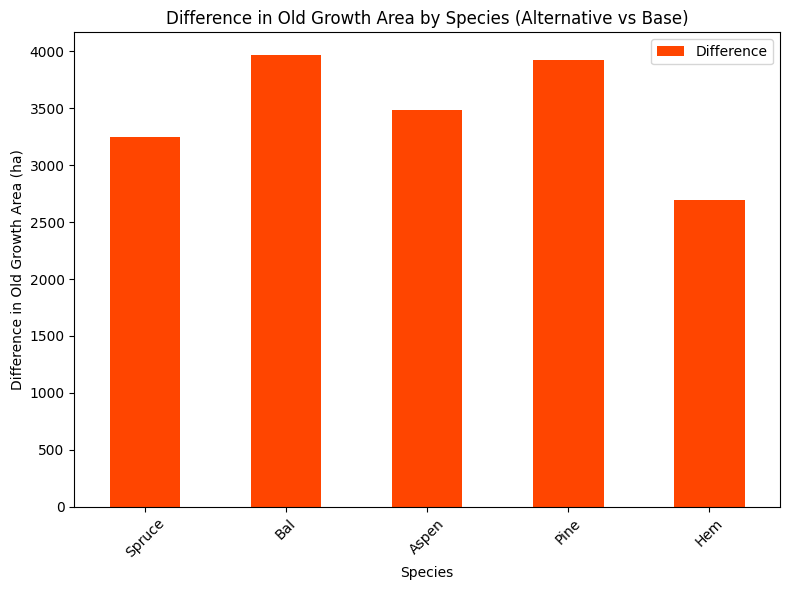

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_kpi_age_difference.pdf


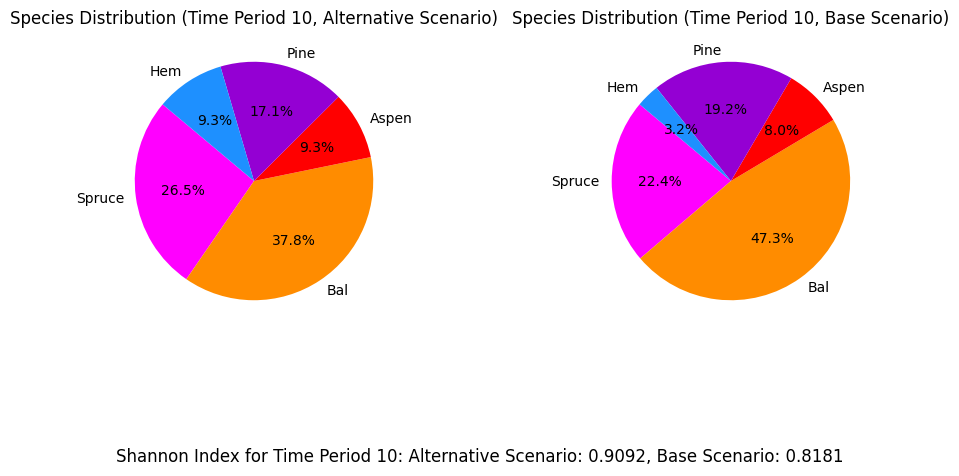

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_st_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for goldenbear_max_st_gldbr_AAC_10%...
running the scenario for the Golden Bear mining site (10%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0xed45d568
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e+01, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 2031 columns
Presolve time: 0.13s
Presolved: 1911 rows, 34100 

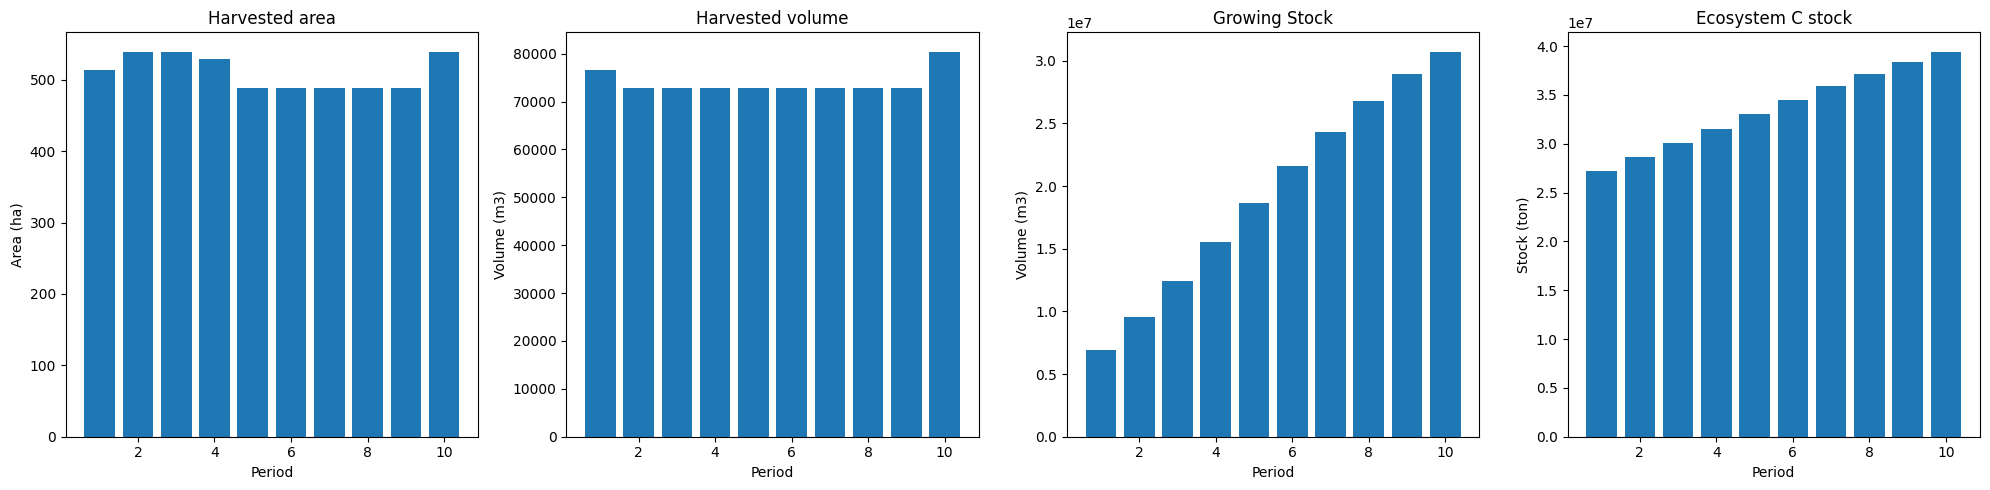

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_gldbr_AAC_10%_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  781
The economic indicator (the provincial government revenues) is:  26652
------------------------------------------------


In [ ]:
Start = time.time()
scenario_names = scenario_options.get(case_study, [])
for scenario_name in scenario_names:
    print(f"Running for {case_study}_{obj_mode}_{scenario_name}...")
    results_scenarios(fm, 
                      clt_percentage, 
                      credibility, 
                      budget_input, 
                      n_steps, 
                      max_harvest, 
                      scenario_name, 
                      displacement_effect, 
                      hwp_pool_effect_value, 
                      release_immediately_value, 
                      case_study, 
                      obj_mode,                   
                      pickle_output_base=False, 
                      pickle_output_alter=False)
print('It took', round((time.time() - Start) / 60, 1), "minutes to run all scenarios.")

Running for goldenbear_max_st_gldbr_AAC_10%...
running the scenario for the Golden Bear mining site (10%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0xed45d568
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e+01, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 2031 columns
Presolve time: 0.17s
Presolved: 1911 rows, 34100 columns, 409166 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.685e+04
 Factor NZ  : 9.050e

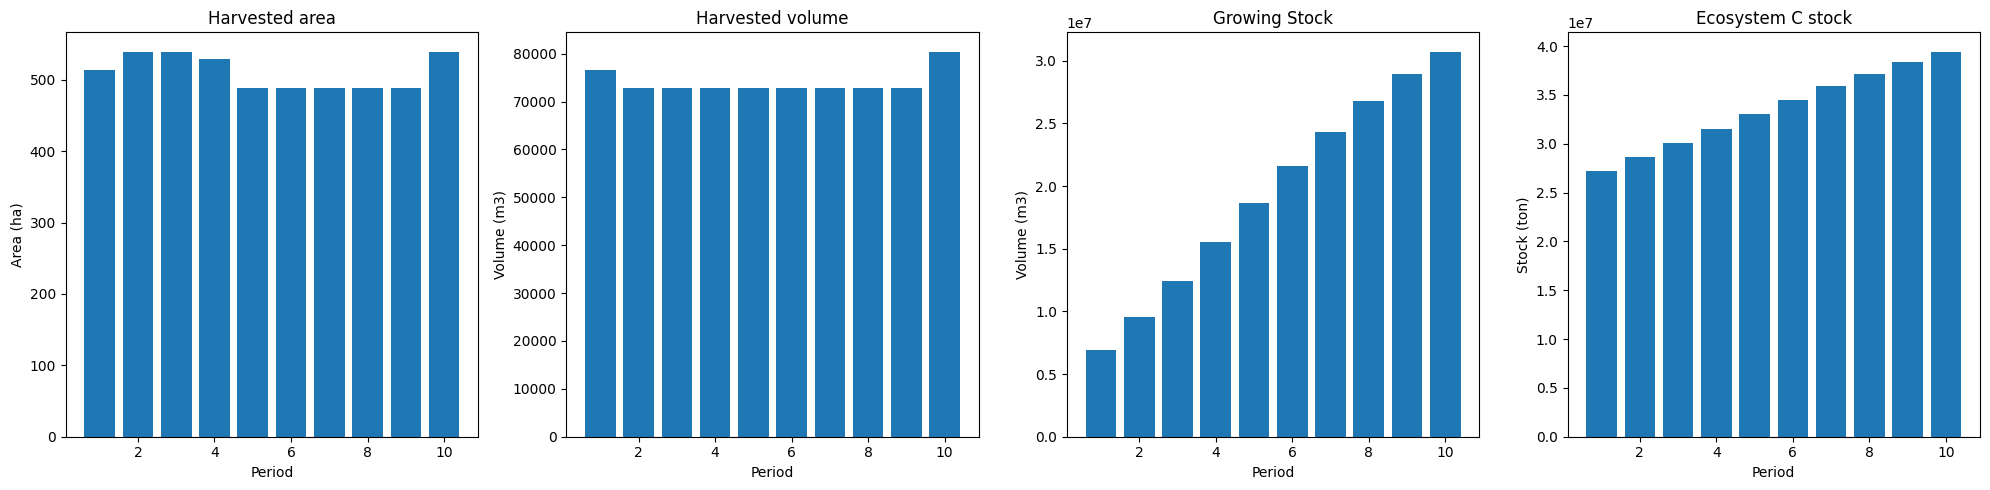

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_gldbr_AAC_10%_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  781
The economic indicator (the provincial government revenues) is:  26652
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


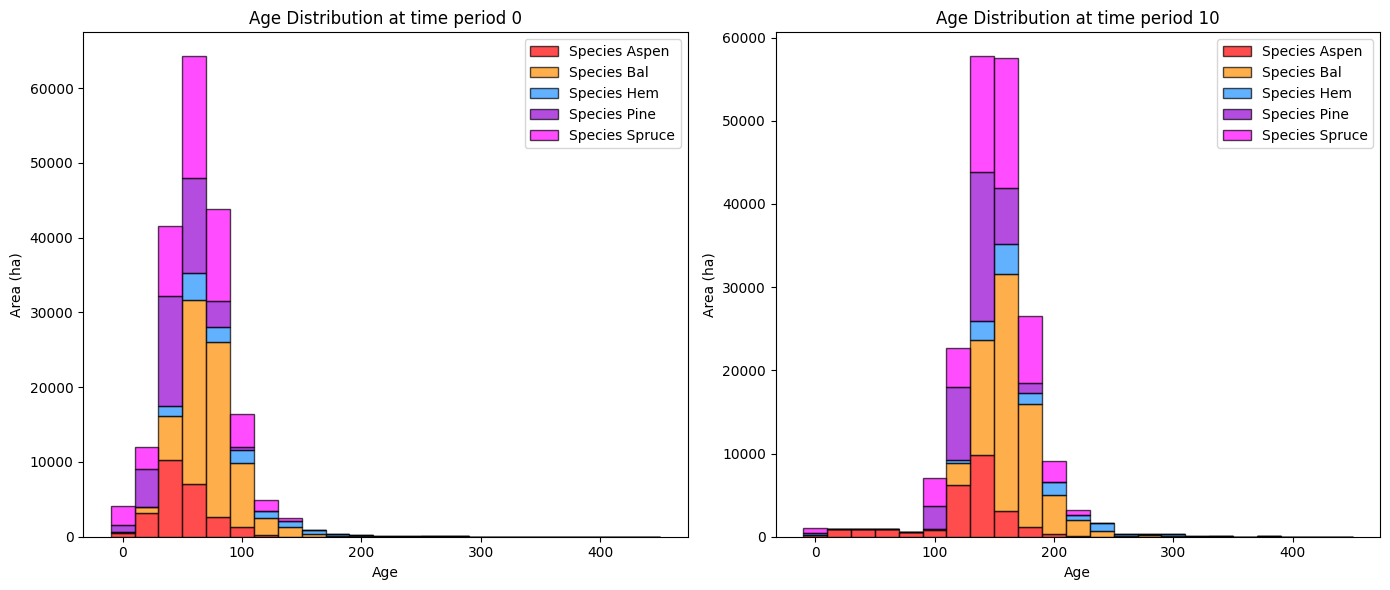

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_gldbr_AAC_10%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   8040.264040   8037.555506
Bal     278.565372  15963.007735  15684.442363
Aspen   273.490478  10038.353836   9764.863358
Pine      0.000000   7631.887200   7631.887200
Hem     419.699331   3873.618109   3453.918778

Old growth has **increased** by 44572.67 hectares from time period 0 to time period 10.


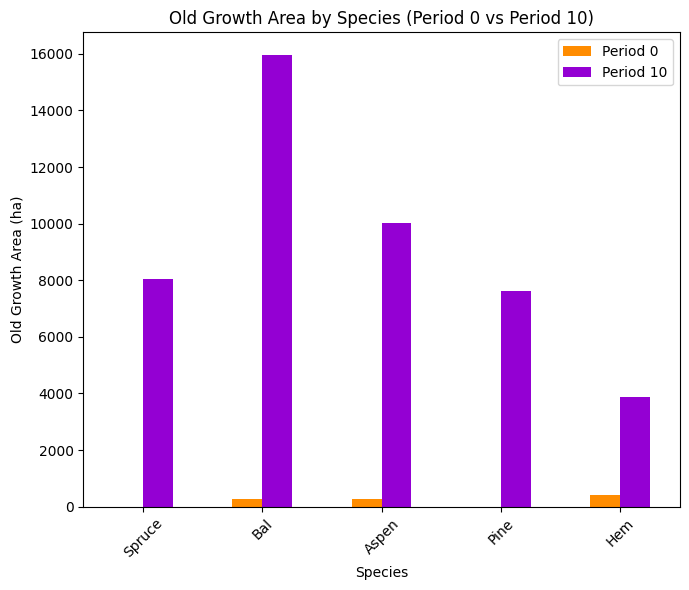

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_gldbr_AAC_10%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.9455
Shannon Evenness Index for time period 10: 0.9208

Diversity has **decreased** by 2.48% from time 0 to time 10.


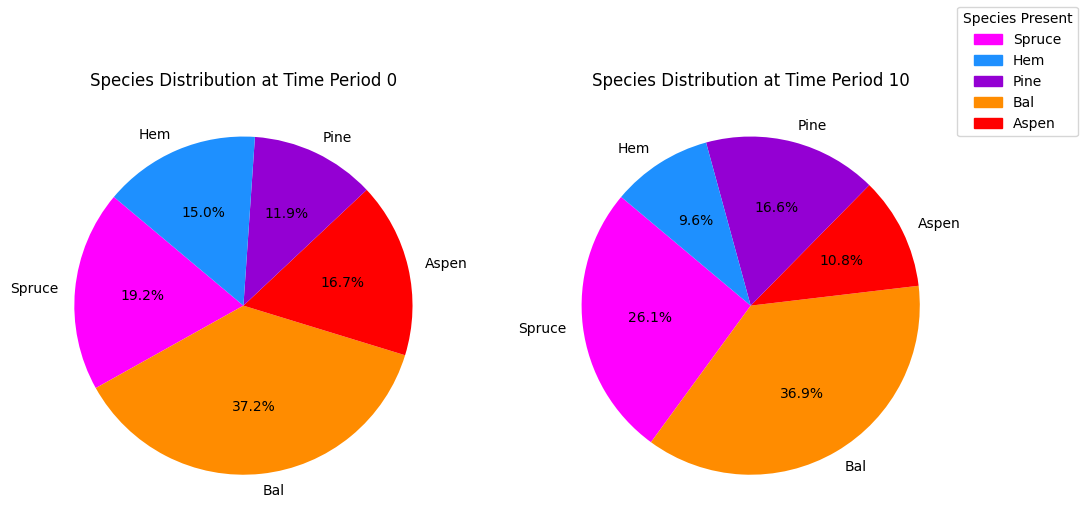

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_st_gldbr_AAC_10%_species_pie.pdf
running business as usual scenario for the Golden Bear mine site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0xf8fbe06d
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e+01, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 2031 columns
Presolve time: 0.16s
Presolved: 1911 rows, 34099 columns, 409165 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time

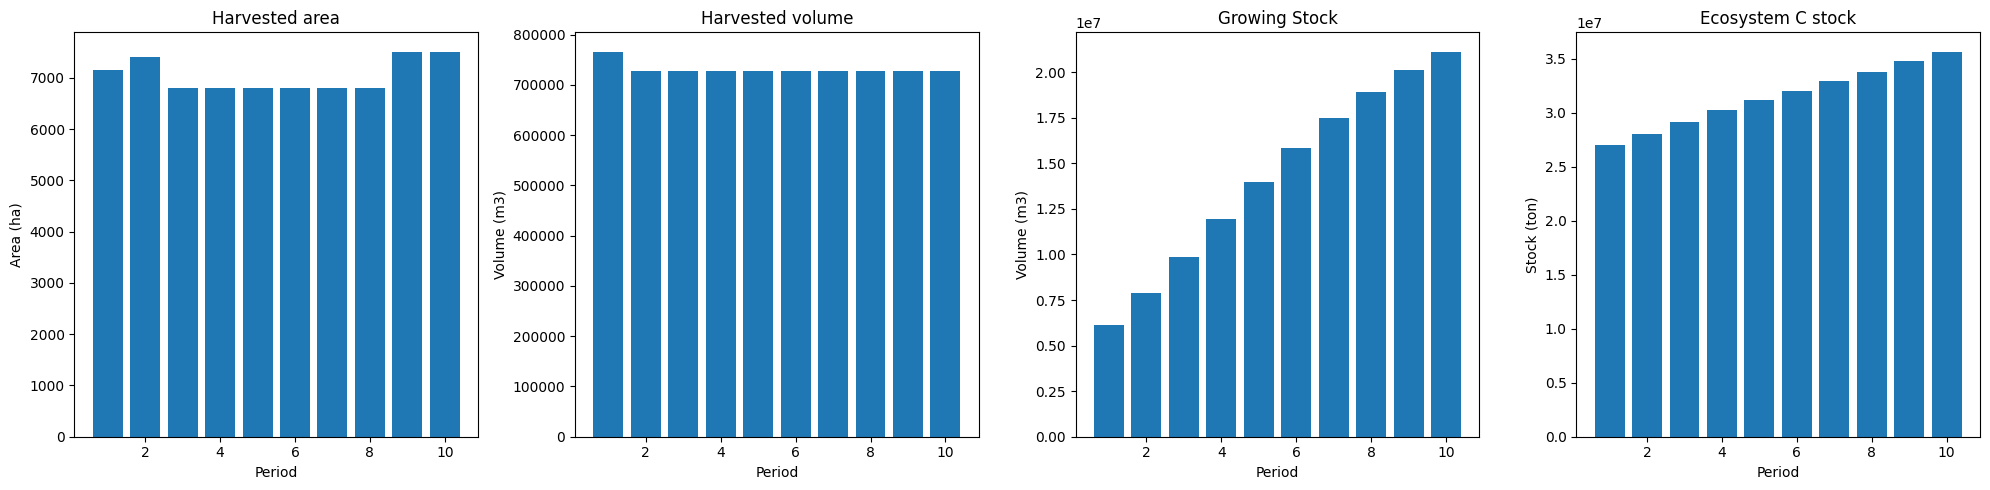

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_bau_gldbr_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  7734
The economic indicator (the provincial government revenues) is:  263762
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


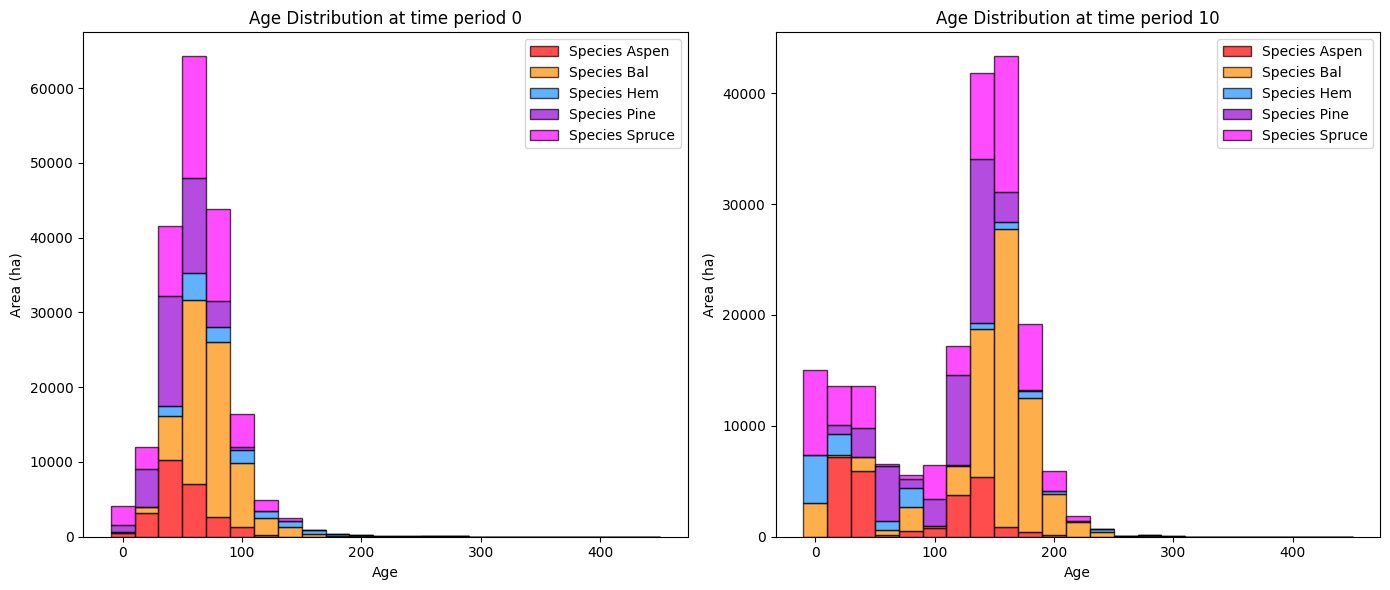

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_bau_gldbr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   4738.556382   4735.847848
Bal     278.565372  11823.627962  11545.062590
Aspen   273.490478   3610.557489   3337.067011
Pine      0.000000   3707.791886   3707.791886
Hem     419.699331    830.482584    410.783253

Old growth has **increased** by 23736.55 hectares from time period 0 to time period 10.


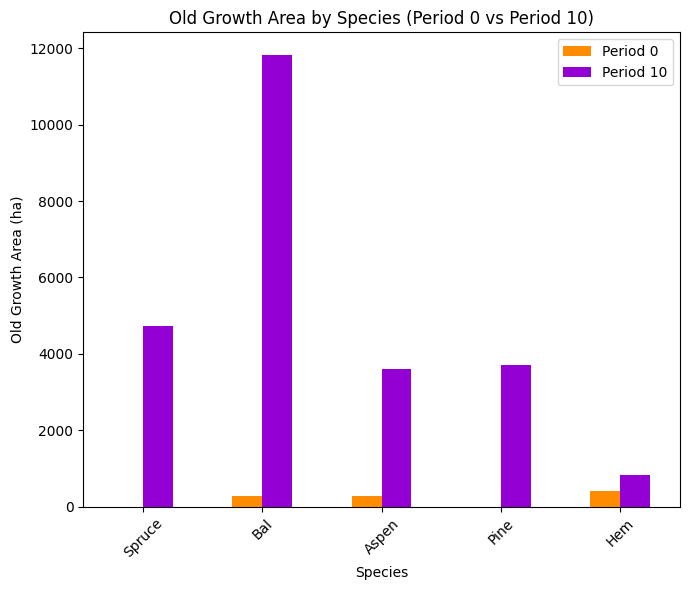

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_bau_gldbr_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.9455
Shannon Evenness Index for time period 10: 0.8181

Diversity has **decreased** by 12.74% from time 0 to time 10.


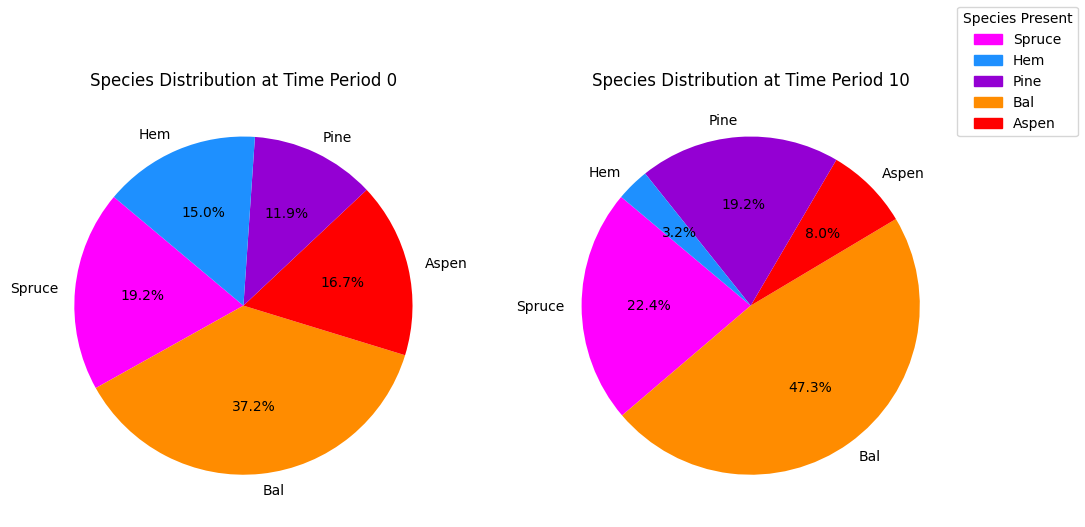

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_st_bau_gldbr_species_pie.pdf


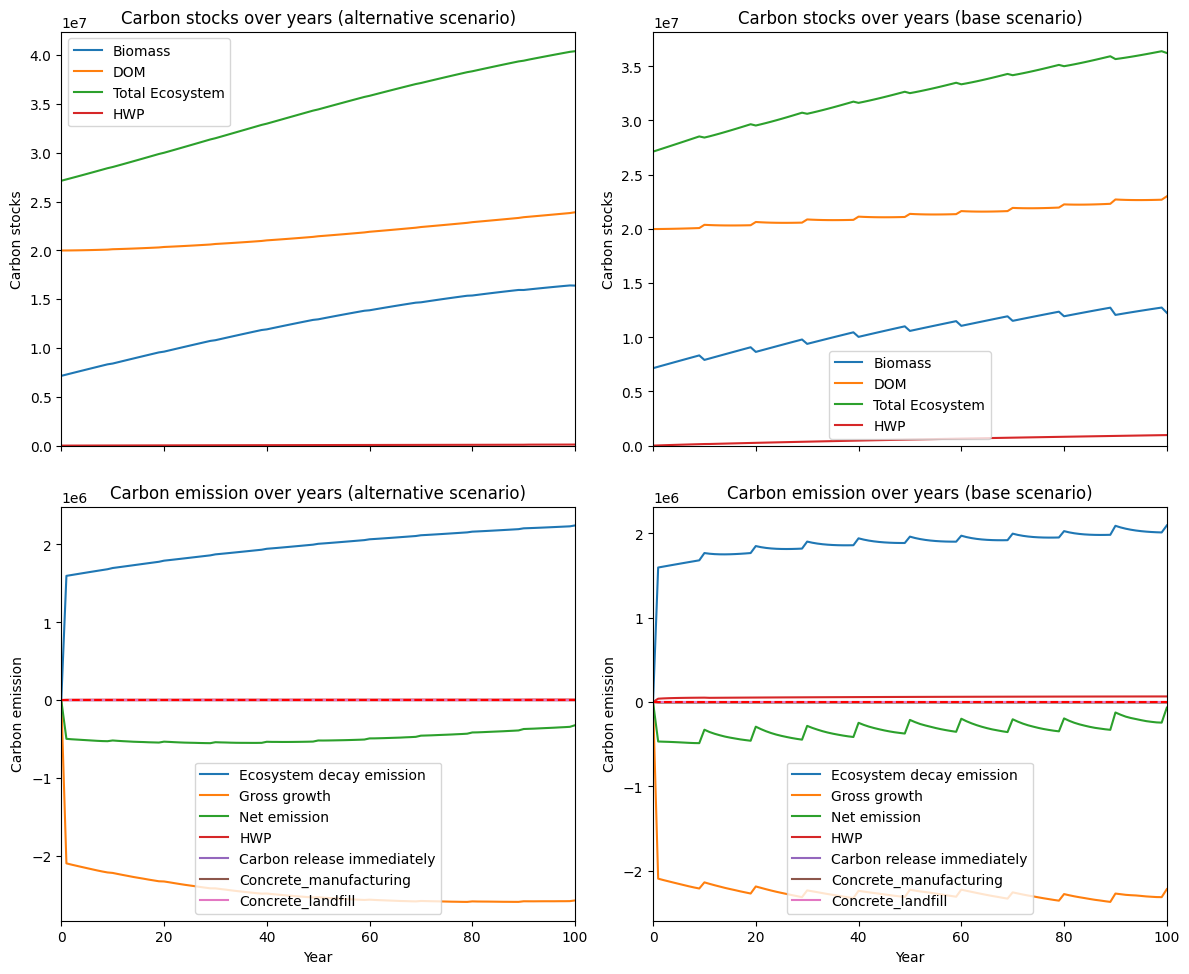

---------------------------------------------------------------------------------------
Net emission difference -15873858.172901435
Net emission base scenario -32702620.346034106
Net emission alternative scenario -48576478.51893555
dollar_per_ton is:  0.6299665708914541
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Spruce  0.0  3301.707658  3301.707658
Bal     0.0  4139.379773  4139.379773
Aspen   0.0  6427.796347  6427.796347
Pine    0.0  3924.095315  3924.095315
Hem     0.0  3043.135525  3043.135525

Overall, the old growth area has **increased** by 20836.11 hectares in the alternative scenario compared to the base scenario.


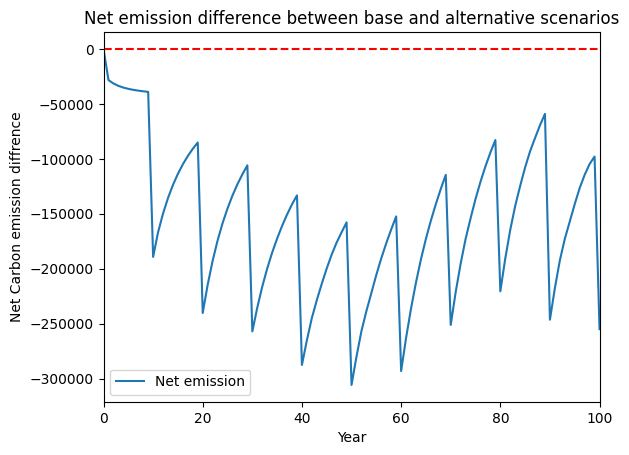

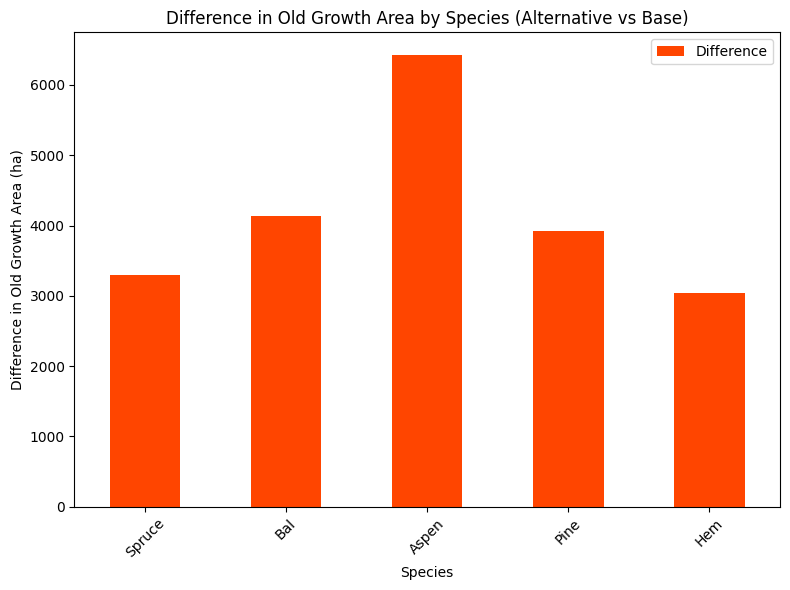

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_st_kpi_age_difference.pdf


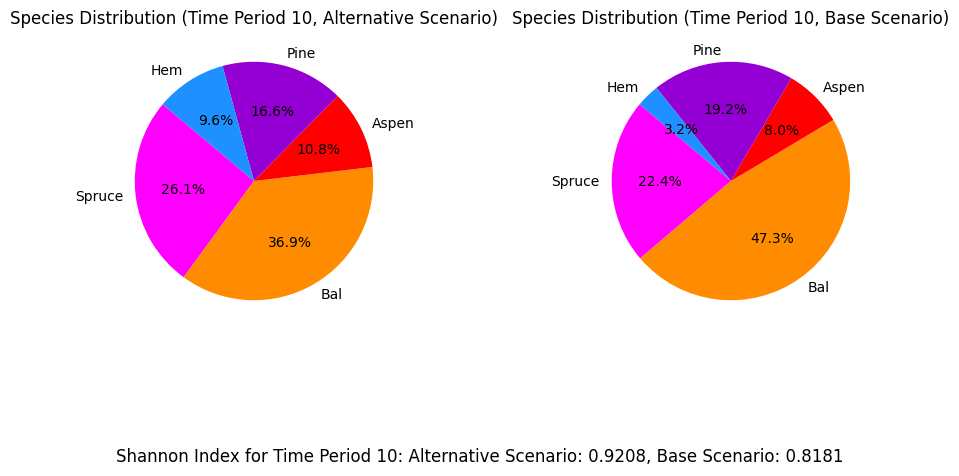

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_st_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
It took 8.0 minutes to run all scenarios.


In [14]:
Start = time.time()
scenario_names = ['gldbr_AAC_10%']
for scenario_name in scenario_names:
    print(f"Running for {case_study}_{obj_mode}_{scenario_name}...")
    results_scenarios(fm, 
                      clt_percentage, 
                      credibility, 
                      budget_input, 
                      n_steps, 
                      max_harvest, 
                      scenario_name, 
                      displacement_effect, 
                      hwp_pool_effect_value, 
                      release_immediately_value, 
                      case_study, 
                      obj_mode,                   
                      pickle_output_base=False, 
                      pickle_output_alter=False)
print('It took', round((time.time() - Start) / 60, 1), "minutes to run all scenarios.")

In [ ]:
print('It took', round((time.time() - Start) / 60, 1), "minutes to run this script.")